# SW 1700

In [1]:
import numpy as np
import os
#import ipdb

def connect_dataset(file_list, icond_file_list, outputdir,
                    topodx=15, roi=2500, offset=5000,gclass_num=5,test_data_num=500):
    """
    複数のデータセットを連結する
    """
    #ipdb.set_trace()
    
    #Reading and combining files Decide start and end points of the learning area and convert them to grid numbers
    H = np.loadtxt(file_list[0], delimiter = ',')
    icond = np.loadtxt(icond_file_list[0], delimiter = ',')
    
    #Reading and combining files
    if len(file_list) > 1:
        for i in range(1, len(file_list)):
            H_temp = np.loadtxt(file_list[i], delimiter = ',')
            icond_temp = np.loadtxt(icond_file_list[i], delimiter = ',')
            H = np.concatenate((H,H_temp),axis=0)
            icond = np.concatenate((icond,icond_temp),axis = 0)
    
    roi_grids = int(roi / topodx)
    num_grids = int(H.shape[1] / gclass_num)
    H_subset = np.zeros([H.shape[0], roi_grids * gclass_num])
    for i in range(gclass_num):
        H_subset[:, i*roi_grids:(i+1)*roi_grids] = H[:, i*num_grids:(i*num_grids+roi_grids)]
    
    #Obtain the maximum and minimum values of data
    max_x = np.max(H_subset)
    min_x = np.min(H_subset)
    icond_max = np.max(icond, axis=0)
    icond_min = np.min(icond, axis=0)
    
    #Split the data into tests and training
    H_train = H_subset[0:-test_data_num,:]
    H_test = H_subset[H_subset.shape[0] - test_data_num:,:]
    icond_train = icond[0:-test_data_num,:]
    icond_test = icond[H.shape[0] - test_data_num:,:]
    
    #Save the data
    if not os.path.exists(outputdir):
        os.mkdir(outputdir)
    np.savetxt(outputdir + '/x_train.txt',H_train,delimiter = ',')
    np.savetxt(outputdir + '/x_test.txt',H_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_train.txt',icond_train,delimiter = ',')
    np.savetxt(outputdir + '/icond_test.txt',icond_test,delimiter = ',')
    np.savetxt(outputdir + '/icond_min.txt',icond_min,delimiter = ',')
    np.savetxt(outputdir + '/icond_max.txt',icond_max,delimiter = ',')
    np.savetxt(outputdir + '/x_minmax.txt',[min_x, max_x],delimiter = ',')
    
    
if __name__=="__main__":
    original_data_dir = "/home/rimali2009/Journal_2"
    parent_dir = "/home/rimali2009/Journal_2"
    if not os.path.exists(parent_dir):
        os.mkdir(parent_dir)
    outputdir = parent_dir + "/data_g6_j2_roi1700_thai_revised_1"
    file_list = ['/home/rimali2009/Journal_2/eta_5000_g6_300grid_thai_g5_revised_1.csv']
    initial_conditions = ['/home/rimali2009/Journal_2/start_param_random_5000_thai_g5_revised_1.csv']
connect_dataset(file_list, initial_conditions, outputdir, test_data_num=500, gclass_num=5, topodx=15., roi=1700)
        
        
    

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar  7 15:43:18 2017

@author: hanar
"""
import time
import numpy as np
import os
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.models import load_model
#from keras.utils.visualize_util import plot
import matplotlib.pyplot as plt
import keras.callbacks
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

#Global variables for normalizing parameters
max_x = 1.0
min_x = 0.0
max_y = 1.0
min_y = 0.0


def deep_learning_tsunami(resdir, X_train_raw, y_train_raw, X_test_raw, y_test_raw,
                            _lr=0.02, _decay=0,
                            _validation_split=0.2, _batch_size=32,
                            _momentum=0.9, _nesterov=True,
                            num_layers=4, dropout=0.5,
                            node_num = 2500,
                            _epochs=2000):
    """
    Creating the inversion model of turbidity currents by deep learning
    """
    #Normalizing dataset
    X_train = get_normalized_data(X_train_raw, min_x, max_x)
    X_test = get_normalized_data(X_test_raw, min_x, max_x)
    y_train = get_normalized_data(y_train_raw, min_y, max_y)
    y_test = get_normalized_data(y_test_raw, min_y, max_y)
    
    #Generation of neural network model
    model = Sequential()
    model.add(Dense(node_num, input_dim=X_train.shape[1], activation='relu', kernel_initializer ='glorot_uniform'))#1st layer
    model.add(Dropout(dropout))
    for i in range(num_layers - 2):
        model.add(Dense(node_num, activation='relu', kernel_initializer ='glorot_uniform'))#2nd layer
        model.add(Dropout(dropout))
    model.add(Dense(y_train.shape[1], activation = 'relu', kernel_initializer ='glorot_uniform')) #last layer
    
    #Compiling the model
    model.compile(loss="mean_squared_error", 
              optimizer=SGD(lr=_lr, decay=_decay, momentum=_momentum, nesterov=_nesterov),
              #optimizer=Adadelta(),
              metrics=["mean_squared_error"])    
    
    #Perform learning
    t = time.time()
    check = ModelCheckpoint("model3.hdf5")
    #es_cb = EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    #tb_cb = TensorBoard(log_dir=resdir, histogram_freq=2, write_graph=True, write_images=True)
    history = model.fit(X_train, y_train, epochs=_epochs, 
                    validation_split=_validation_split, batch_size=_batch_size,
                    callbacks=[check])
    
    #Evaluate learning result
    loss_and_metrics = model.evaluate(X_test,y_test)
    print("\nloss:{} mse:{}".format(loss_and_metrics[0],loss_and_metrics[1]))
    
    print("Elapsed time: {:.1f} sec.".format(time.time()-t))
    
    #Visualize learning result   
    #plot(model, to_file="model.png", show_shapes=True, show_layer_names=True)

    # model The state of change when letting you learnplot
    plot_history(history)
    
    return model, history

def apply_model(model, X, min_x, max_x, min_y, max_y):
    """
    Apply model
    Maximum and minimum values ​​of X and Y are required to normalize
    """
    X_norm =  (X - min_x) / (max_x - min_x)
    Y_norm = model.predict(X_norm)
    Y = Y_norm*(max_y - min_y)+min_y
    return Y

def plot_history(history):
    # Plot accuracy history
    plt.plot(history.history['mean_squared_error'],"o-",label="mse")
    plt.plot(history.history['val_mean_squared_error'],"o-",label="val mse")
    plt.title('model mse')
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.legend(loc="upper right")
    plt.show()

#    # 損失の履歴をプロット
#    plt.plot(history.history['loss'],"o-",label="loss",)
#    plt.plot(history.history['val_loss'],"o-",label="val_loss")
#    plt.title('model loss')
#    plt.xlabel('epoch')
#    plt.ylabel('loss')
#    plt.legend(loc='upper right')
#    plt.show()

def test_model(model, x_test):
    #Test the results
    
    x_test_norm = get_normalized_data(x_test, min_x, max_x)
    test_result_norm = model.predict(x_test_norm)
    test_result = get_raw_data(test_result_norm, min_y, max_y)
    
    return test_result


def save_result(savedir, model, history, test_result):
    
    
    np.savetxt(savedir + 'test_result.txt',test_result,delimiter=',')
    np.savetxt(savedir+'loss.txt',history.history.get('loss'),delimiter=',')
    np.savetxt(savedir+'val_loss.txt',history.history.get('val_loss'),delimiter=',')
    
    #Serialize model and save
    print('save the model')
    model.save(savedir + 'model3.hdf5')

def load_data(datadir):
    """
    This function load training and test data sets, and returns variables
    """
    global min_x, max_x, min_y, max_y
    
    x_train = np.loadtxt(datadir + 'x_train.txt',delimiter=',')
    x_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
    y_train = np.loadtxt(datadir + 'icond_train.txt',delimiter=',')
    y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
    min_y = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
    max_y = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')
    [min_x, max_x] = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
    
    return x_train, y_train, x_test, y_test

def set_minmax_data(_min_x, _max_x, _min_y, _max_y):
    global min_x, max_x, min_y, max_y
    
    min_x, max_x, min_y, max_y = _min_x, _max_x, _min_y, _max_y
    return
    


def get_normalized_data(x, min_val, max_val):
    """
    Normalizing the training and test dataset
    """
    x_norm = (x - min_val) / (max_val - min_val)
    
    return x_norm

def get_raw_data(x_norm, min_val, max_val):
    """
    
    Get raw data from the normalized dataset
    """
    x = x_norm * (max_val - min_val) + min_val
    
    return x

if __name__ == "__main__":
    
    #Reading data  
    datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1700_thai_revised_1/'
    resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1700_thai_revised_1/'
    if not os.path.exists(resdir):
        os.mkdir(resdir)
    
    x_train, y_train, x_test, y_test = load_data(datadir)
    
     
    #Execution of learning
    testcases = [5000]
    for i in range(len(testcases)):
        resdir_case = resdir + '{}/'.format(testcases[i])        
        if not os.path.exists(resdir_case):
            os.mkdir(resdir_case)
        x_train_sub = x_train[0:testcases[i],:]
        y_train_sub = y_train[0:testcases[i],:]
        model, history = deep_learning_tsunami(resdir_case, x_train_sub, y_train_sub, x_test, y_test, num_layers=5)
        #Verify and save results
        result = test_model(model, x_test)
        save_result(resdir_case,model,history,result)






Using TensorFlow backend.


Train on 4000 samples, validate on 1000 samples
Epoch 1/2000
4000/4000 [==============================] - 2s 524us/step - loss: 0.0878 - mean_squared_error: 0.0878 - val_loss: 0.0636 - val_mean_squared_error: 0.0636
Epoch 2/2000
4000/4000 [==============================] - 1s 270us/step - loss: 0.0570 - mean_squared_error: 0.0570 - val_loss: 0.0526 - val_mean_squared_error: 0.0526
Epoch 3/2000
4000/4000 [==============================] - 1s 270us/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0448 - val_mean_squared_error: 0.0448
Epoch 4/2000
4000/4000 [==============================] - 1s 266us/step - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0392 - val_mean_squared_error: 0.0392
Epoch 5/2000
4000/4000 [==============================] - 1s 259us/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 6/2000
4000/4000 [==============================] - 1s 267us/step - loss: 0.0340 - mean_squared_error: 0.0

4000/4000 [==============================] - 1s 266us/step - loss: 0.0135 - mean_squared_error: 0.0135 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 50/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0133 - mean_squared_error: 0.0133 - val_loss: 0.0121 - val_mean_squared_error: 0.0121
Epoch 51/2000
4000/4000 [==============================] - 1s 282us/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 52/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 53/2000
4000/4000 [==============================] - 1s 268us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 54/2000
4000/4000 [==============================] - 1s 316us/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0106 - val_mean_squared_error: 0.0106


4000/4000 [==============================] - 1s 273us/step - loss: 0.0099 - mean_squared_error: 0.0099 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 98/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 99/2000
4000/4000 [==============================] - 1s 283us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 100/2000
4000/4000 [==============================] - 1s 268us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 101/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0098 - mean_squared_error: 0.0098 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 102/2000
4000/4000 [==============================] - 1s 263us/step - loss: 0.0097 - mean_squared_error: 0.0097 - val_loss: 0.0072 - val_mean_squared_error: 0.00

4000/4000 [==============================] - 1s 253us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 146/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 147/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0053 - val_mean_squared_error: 0.0053
Epoch 148/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0050 - val_mean_squared_error: 0.0050
Epoch 149/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 150/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0047 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 264us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 194/2000
4000/4000 [==============================] - 1s 259us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0039 - val_mean_squared_error: 0.0039
Epoch 195/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 196/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 197/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 198/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0072 - mean_squared_error: 0.0072 - val_loss: 0.0042 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 266us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 242/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 243/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 244/2000
4000/4000 [==============================] - 1s 282us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 245/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 246/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0038 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 280us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 290/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0045 - val_mean_squared_error: 0.0045
Epoch 291/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 292/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 293/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 294/2000
4000/4000 [==============================] - 1s 260us/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0035 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 277us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Epoch 338/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0061 - mean_squared_error: 0.0061 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 339/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 340/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 341/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 342/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0029 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 275us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 386/2000
4000/4000 [==============================] - 1s 270us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 387/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 388/2000
4000/4000 [==============================] - 1s 268us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 389/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 390/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0027 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 277us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 434/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 435/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 436/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 437/2000
4000/4000 [==============================] - 1s 261us/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 438/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0033 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 274us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 482/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 483/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 484/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 485/2000
4000/4000 [==============================] - 1s 271us/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 486/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0029 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 278us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 530/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 531/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 532/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 533/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 534/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0025 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 294us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 578/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0028 - val_mean_squared_error: 0.0028
Epoch 579/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 580/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 581/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 582/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0025 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 282us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 626/2000
4000/4000 [==============================] - 1s 304us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 627/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 628/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 629/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 630/2000
4000/4000 [==============================] - 1s 271us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0024 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 289us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 674/2000
4000/4000 [==============================] - 1s 283us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 675/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 676/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 677/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 678/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0025 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 273us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 722/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 723/2000
4000/4000 [==============================] - 1s 268us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 724/2000
4000/4000 [==============================] - 1s 275us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 725/2000
4000/4000 [==============================] - 1s 283us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 726/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0025 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 273us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 770/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 771/2000
4000/4000 [==============================] - 1s 290us/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 772/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 773/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 774/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0023 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 275us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 818/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 819/2000
4000/4000 [==============================] - 1s 266us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 820/2000
4000/4000 [==============================] - 1s 267us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 821/2000
4000/4000 [==============================] - 1s 282us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0025 - val_mean_squared_error: 0.0025
Epoch 822/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0024 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 278us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 866/2000
4000/4000 [==============================] - 1s 270us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 867/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 868/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 869/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 870/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0020 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 278us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 914/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 915/2000
4000/4000 [==============================] - 1s 281us/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 916/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 917/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 918/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 276us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 962/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 963/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 964/2000
4000/4000 [==============================] - 1s 290us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 965/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 966/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.

4000/4000 [==============================] - 1s 283us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1010/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1011/2000
4000/4000 [==============================] - 1s 271us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1012/2000
4000/4000 [==============================] - 1s 265us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1013/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1014/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0021 - val_mean_squared_erro

4000/4000 [==============================] - 1s 268us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1058/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1059/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1060/2000
4000/4000 [==============================] - 1s 282us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1061/2000
4000/4000 [==============================] - 1s 283us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1062/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0024 - val_mean_squared_erro

4000/4000 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0022 - val_mean_squared_error: 0.0022
Epoch 1106/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1107/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1108/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1109/2000
4000/4000 [==============================] - 1s 281us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1110/2000
4000/4000 [==============================] - 1s 275us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0016 - val_mean_squared_erro

4000/4000 [==============================] - 1s 282us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1154/2000
4000/4000 [==============================] - 1s 261us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 1155/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1156/2000
4000/4000 [==============================] - 1s 269us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1157/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1158/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_erro

4000/4000 [==============================] - 1s 280us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1202/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1203/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1204/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1205/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1206/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_erro

4000/4000 [==============================] - 1s 276us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1250/2000
4000/4000 [==============================] - 1s 282us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1251/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1252/2000
4000/4000 [==============================] - 1s 284us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1253/2000
4000/4000 [==============================] - 1s 290us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1254/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0018 - val_mean_squared_erro

4000/4000 [==============================] - 1s 270us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1298/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 1299/2000
4000/4000 [==============================] - 1s 275us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1300/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 1301/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1302/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0019 - val_mean_squared_erro

4000/4000 [==============================] - 1s 305us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1346/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1347/2000
4000/4000 [==============================] - 1s 280us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1348/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1349/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1350/2000
4000/4000 [==============================] - 1s 270us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0021 - val_mean_squared_erro

4000/4000 [==============================] - 1s 284us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1394/2000
4000/4000 [==============================] - 1s 296us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1395/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1396/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1397/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1398/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0017 - val_mean_squared_erro

4000/4000 [==============================] - 1s 272us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1442/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1443/2000
4000/4000 [==============================] - 1s 253us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1444/2000
4000/4000 [==============================] - 1s 292us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1445/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1446/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0017 - val_mean_squared_erro

4000/4000 [==============================] - 1s 281us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1490/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1491/2000
4000/4000 [==============================] - 1s 283us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1492/2000
4000/4000 [==============================] - 1s 257us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1493/2000
4000/4000 [==============================] - 1s 299us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1494/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0015 - val_mean_squared_erro

4000/4000 [==============================] - 1s 271us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1538/2000
4000/4000 [==============================] - 1s 281us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1539/2000
4000/4000 [==============================] - 1s 290us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1540/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1541/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1542/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_erro

4000/4000 [==============================] - 1s 281us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1586/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1587/2000
4000/4000 [==============================] - 1s 266us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1588/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1589/2000
4000/4000 [==============================] - 1s 271us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1590/2000
4000/4000 [==============================] - 1s 275us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0015 - val_mean_squared_erro

4000/4000 [==============================] - 1s 286us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1634/2000
4000/4000 [==============================] - 1s 305us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1635/2000
4000/4000 [==============================] - 1s 275us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1636/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1637/2000
4000/4000 [==============================] - 1s 296us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1638/2000
4000/4000 [==============================] - 1s 293us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0017 - val_mean_squared_erro

4000/4000 [==============================] - 1s 281us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1682/2000
4000/4000 [==============================] - 1s 283us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1683/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1684/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1685/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1686/2000
4000/4000 [==============================] - 1s 291us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0015 - val_mean_squared_erro

4000/4000 [==============================] - 1s 273us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1730/2000
4000/4000 [==============================] - 1s 277us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1731/2000
4000/4000 [==============================] - 1s 285us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1732/2000
4000/4000 [==============================] - 1s 278us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1733/2000
4000/4000 [==============================] - 1s 270us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1734/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0017 - val_mean_squared_erro

4000/4000 [==============================] - 1s 272us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 1778/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1779/2000
4000/4000 [==============================] - 1s 302us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1780/2000
4000/4000 [==============================] - 1s 275us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1781/2000
4000/4000 [==============================] - 1s 283us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1782/2000
4000/4000 [==============================] - 1s 281us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0015 - val_mean_squared_erro

4000/4000 [==============================] - 1s 275us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1826/2000
4000/4000 [==============================] - 1s 282us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1827/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1828/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1829/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1830/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_erro

4000/4000 [==============================] - 1s 291us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 1874/2000
4000/4000 [==============================] - 1s 275us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 1875/2000
4000/4000 [==============================] - 1s 268us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1876/2000
4000/4000 [==============================] - 1s 273us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1877/2000
4000/4000 [==============================] - 1s 276us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1878/2000
4000/4000 [==============================] - 1s 272us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0015 - val_mean_squared_erro

4000/4000 [==============================] - 1s 282us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1922/2000
4000/4000 [==============================] - 1s 287us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1923/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1924/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1925/2000
4000/4000 [==============================] - 1s 279us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 1926/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0015 - val_mean_squared_erro

4000/4000 [==============================] - 1s 273us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 1970/2000
4000/4000 [==============================] - 1s 274us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 1971/2000
4000/4000 [==============================] - 1s 271us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 1972/2000
4000/4000 [==============================] - 1s 286us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1973/2000
4000/4000 [==============================] - 1s 269us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 1974/2000
4000/4000 [==============================] - 1s 288us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0013 - val_mean_squared_erro

<Figure size 640x480 with 1 Axes>

save the model


(500, 8)


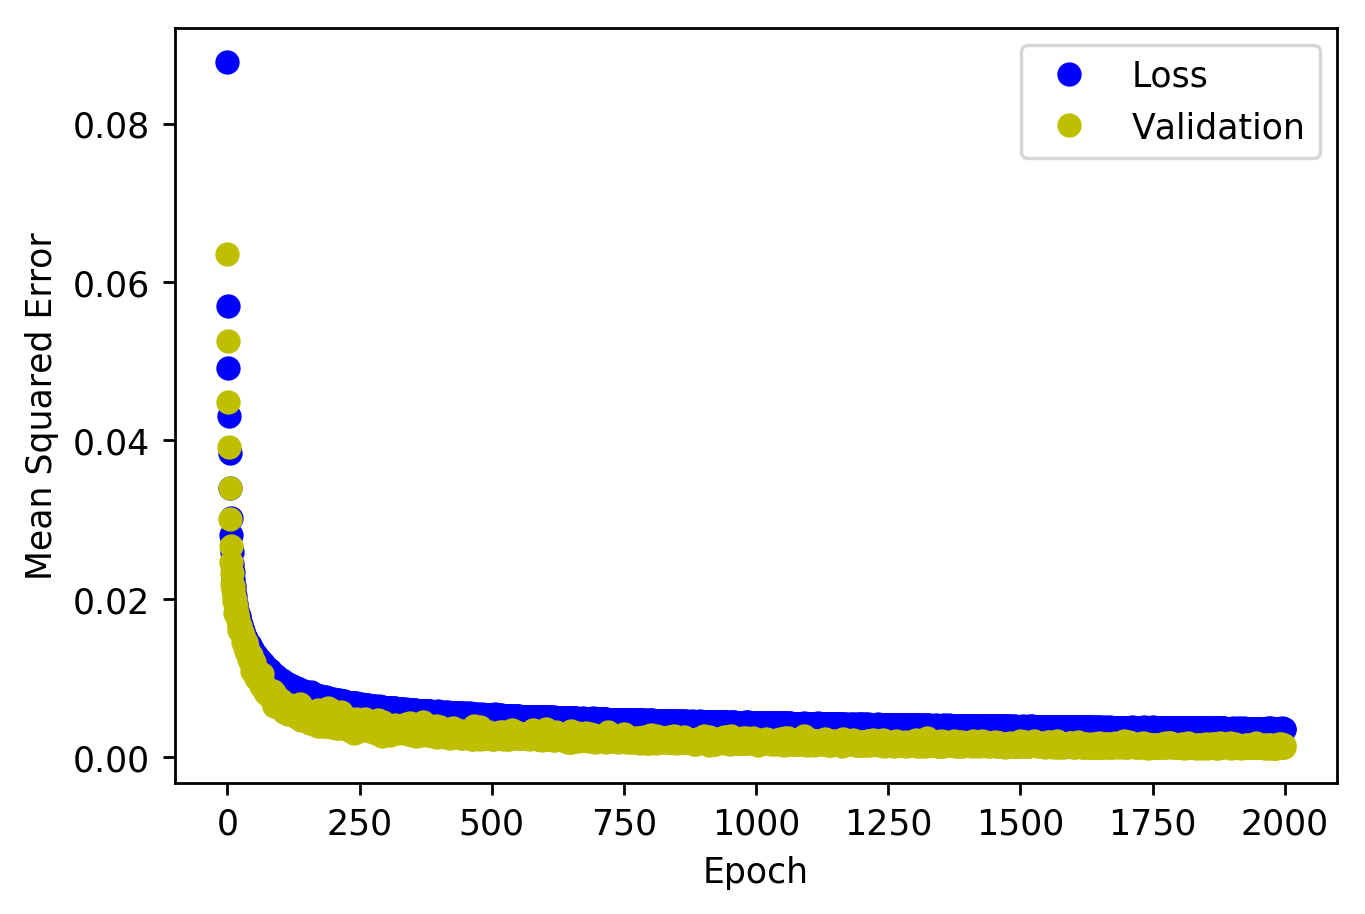

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

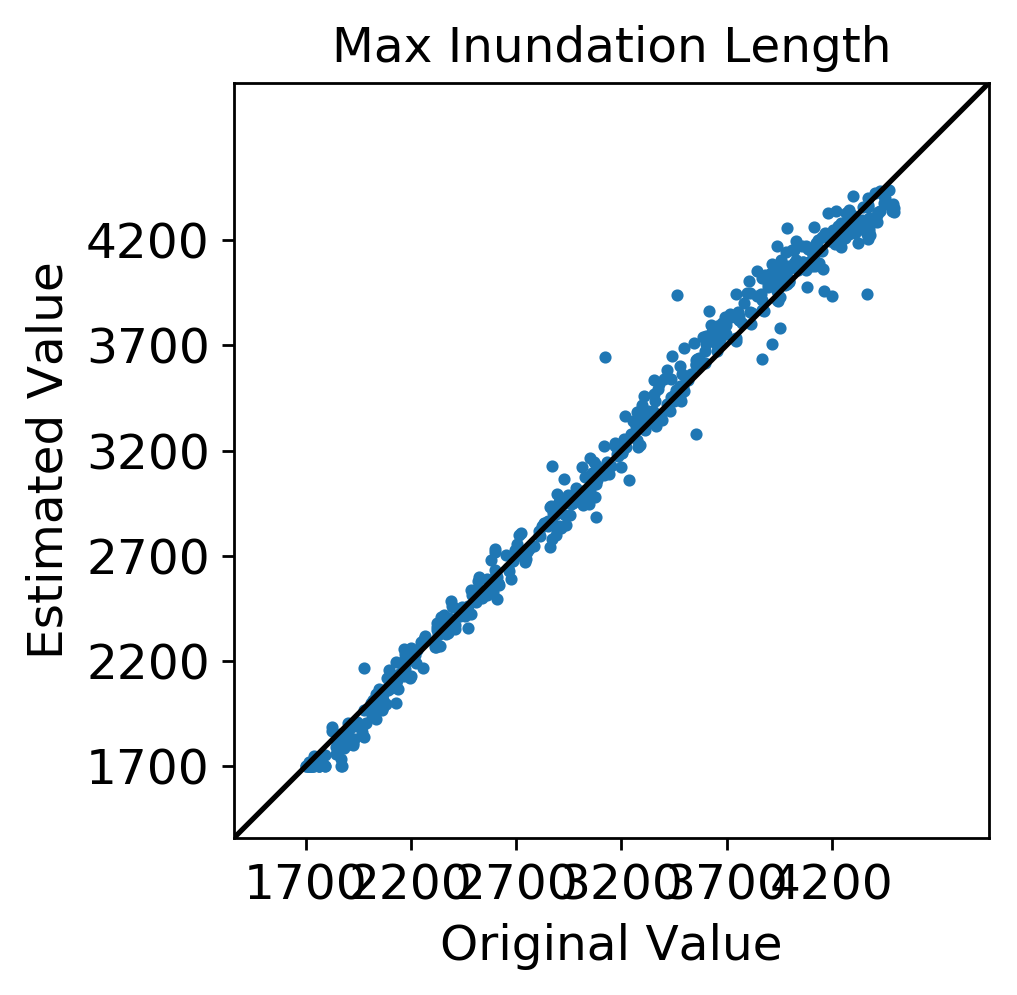

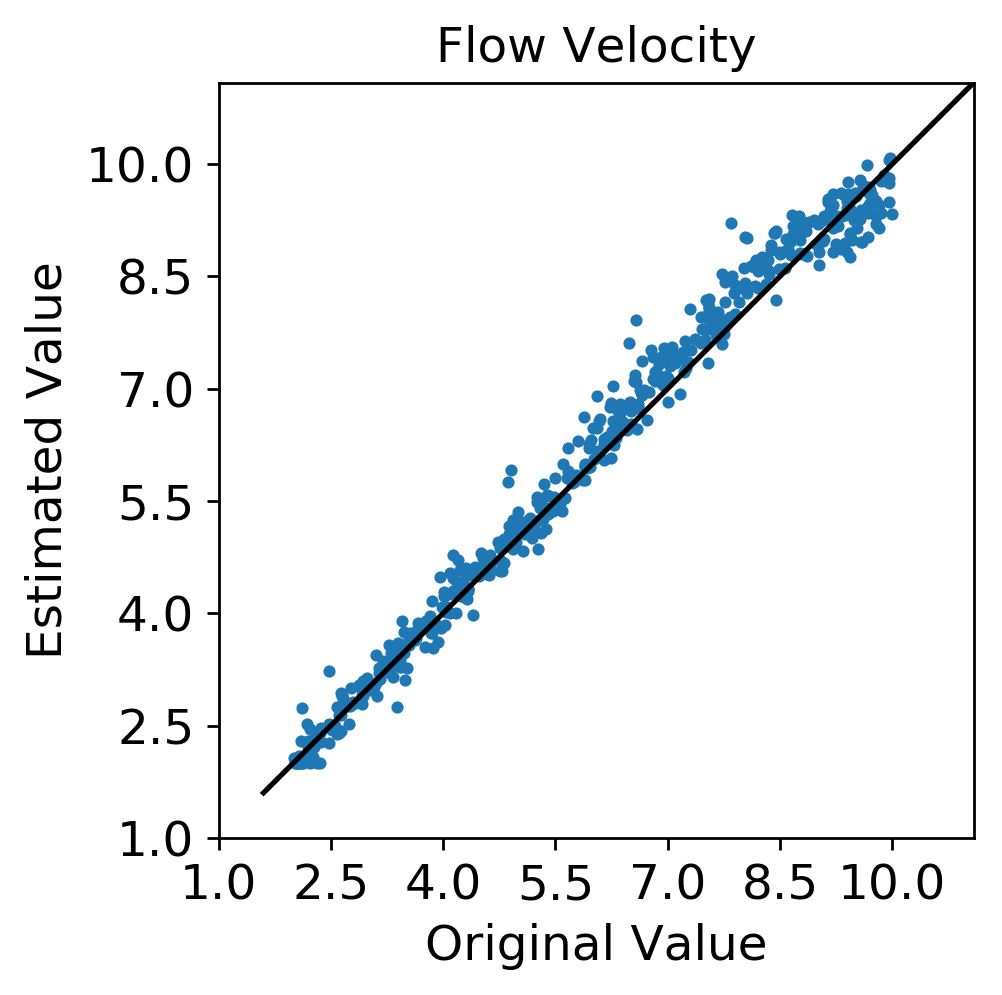

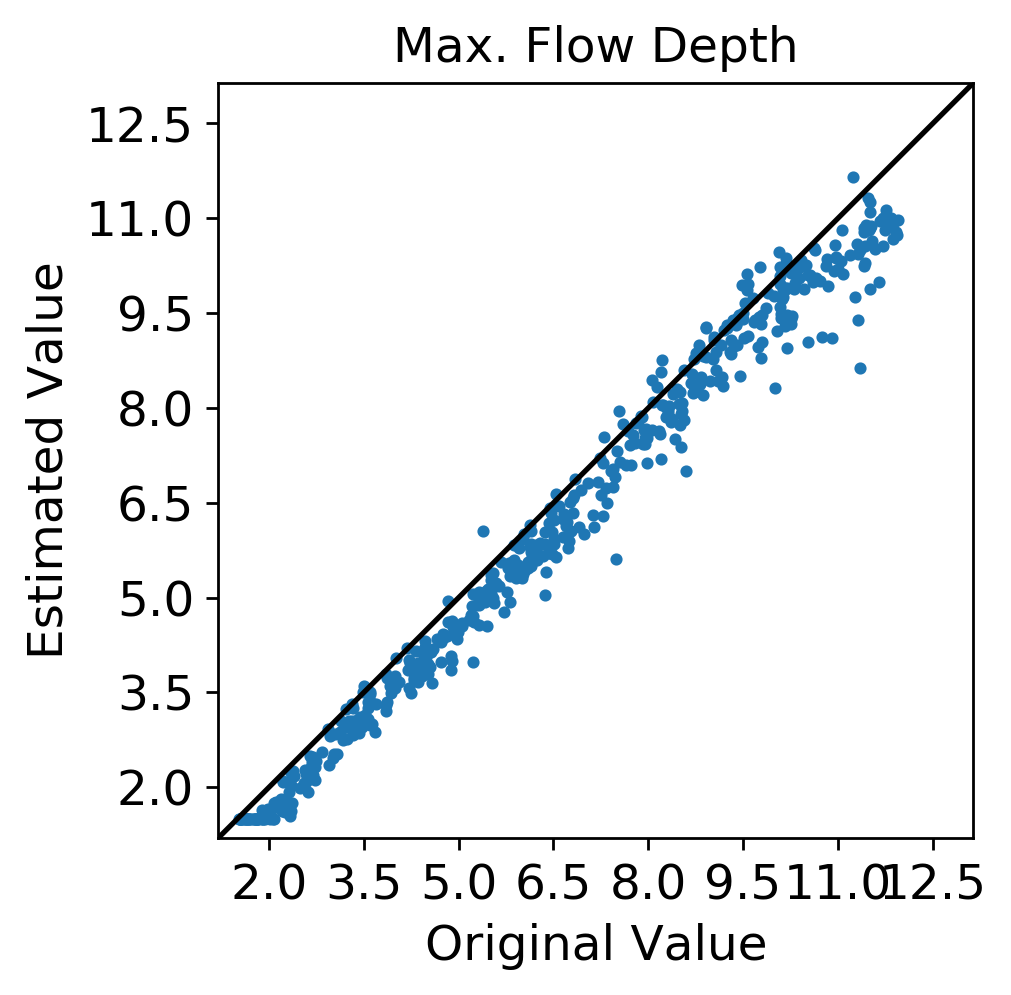

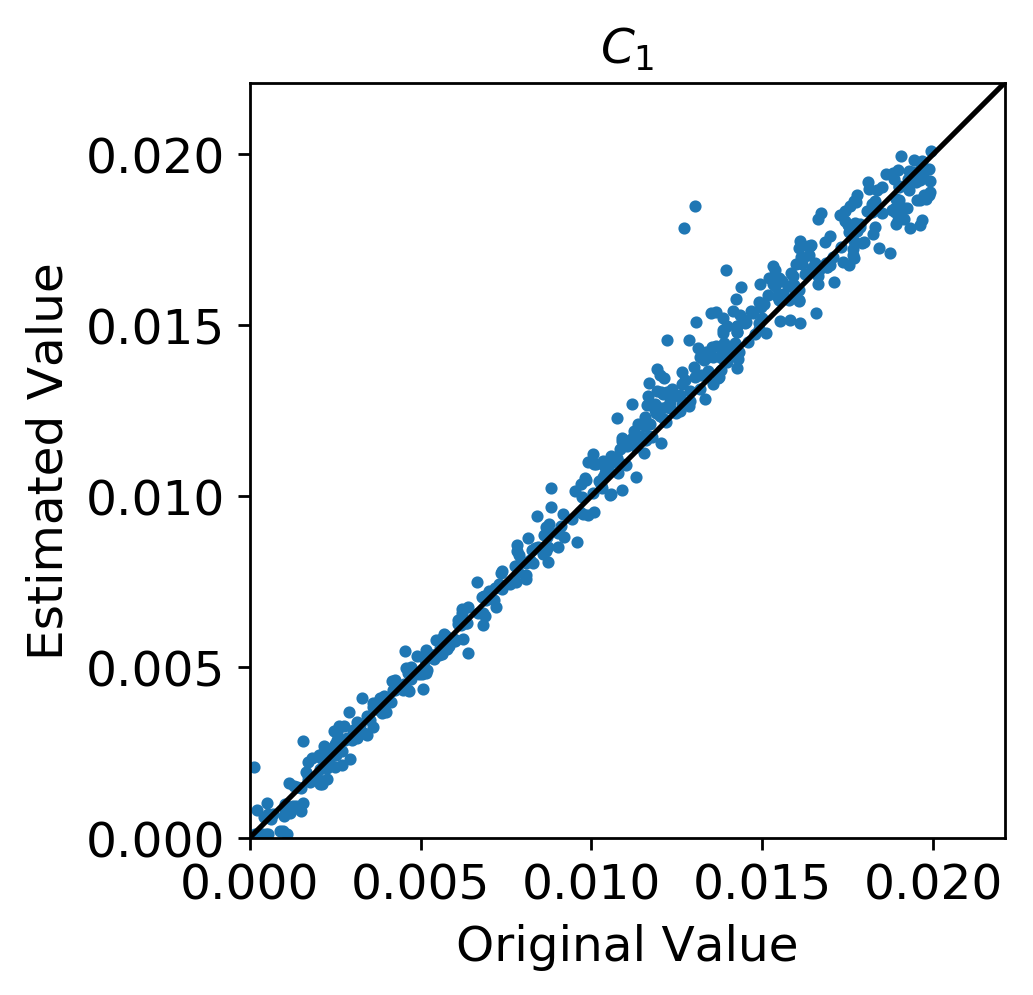

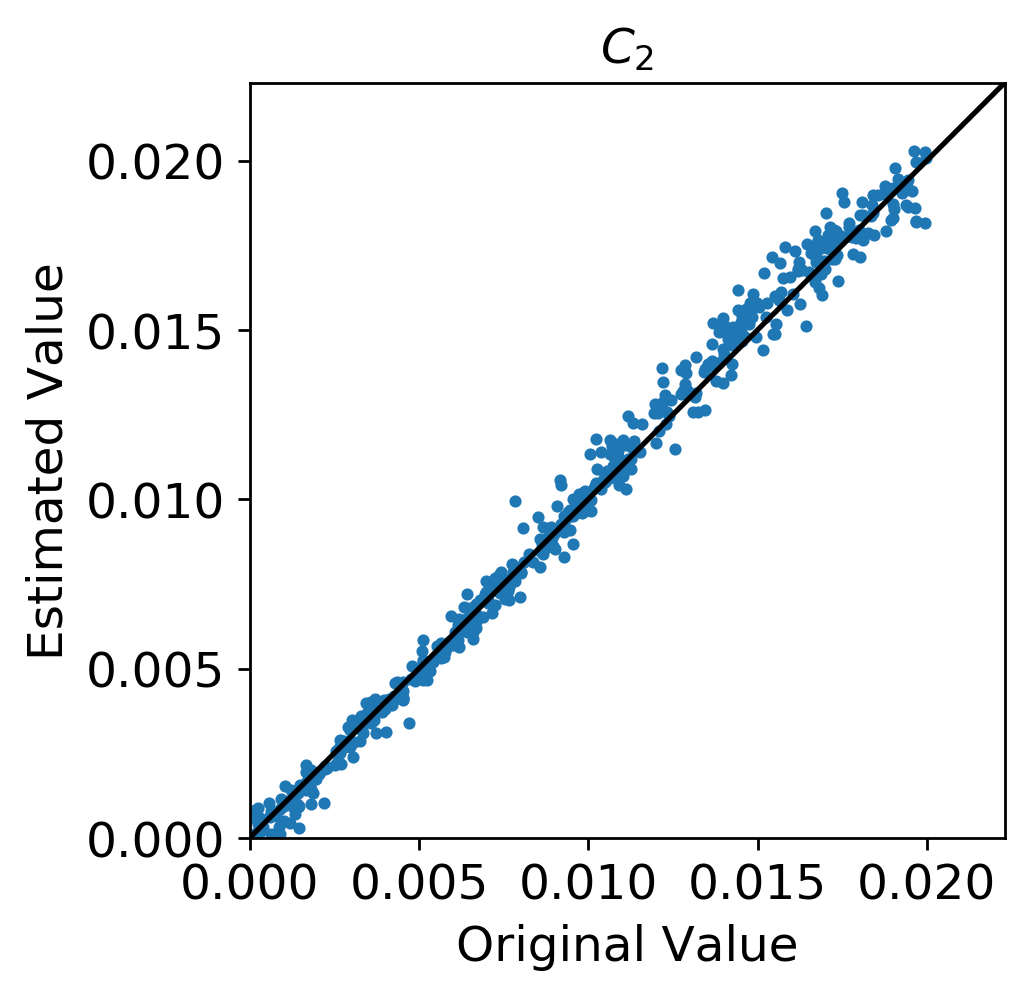

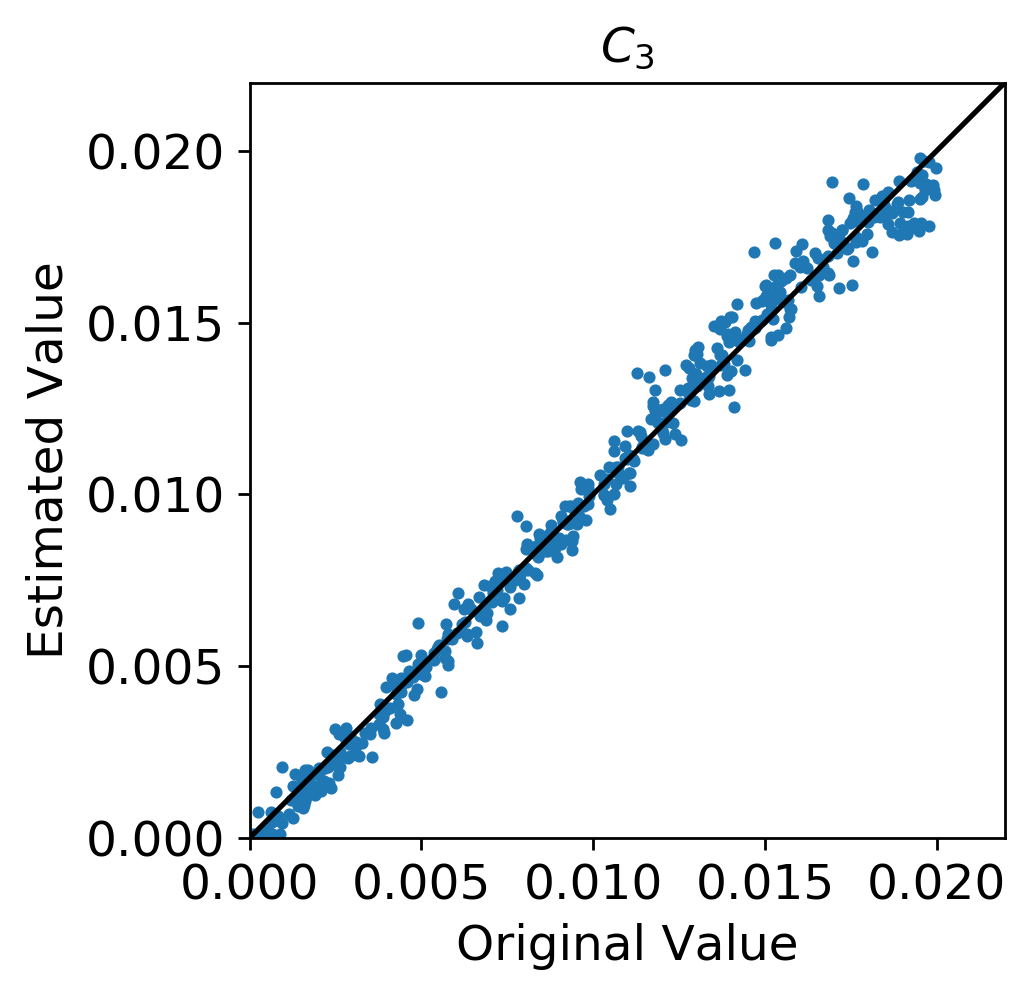

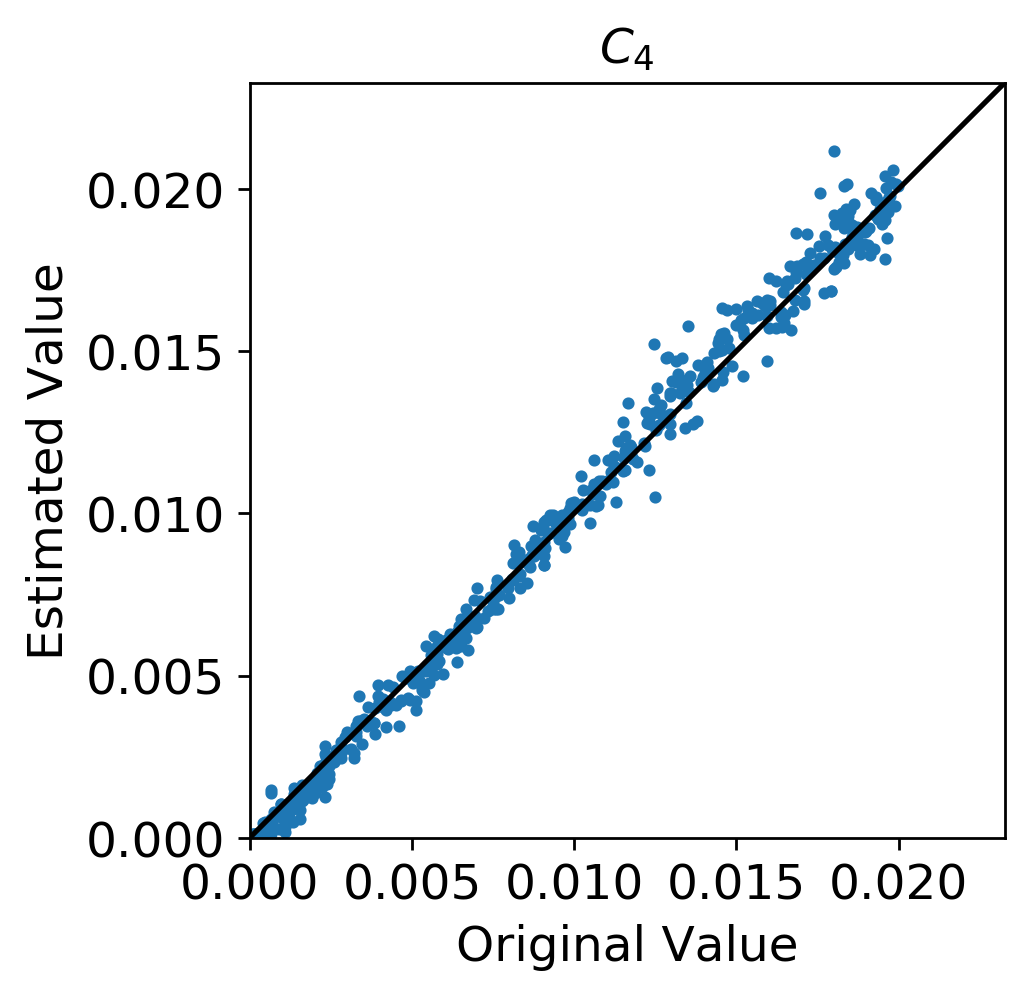

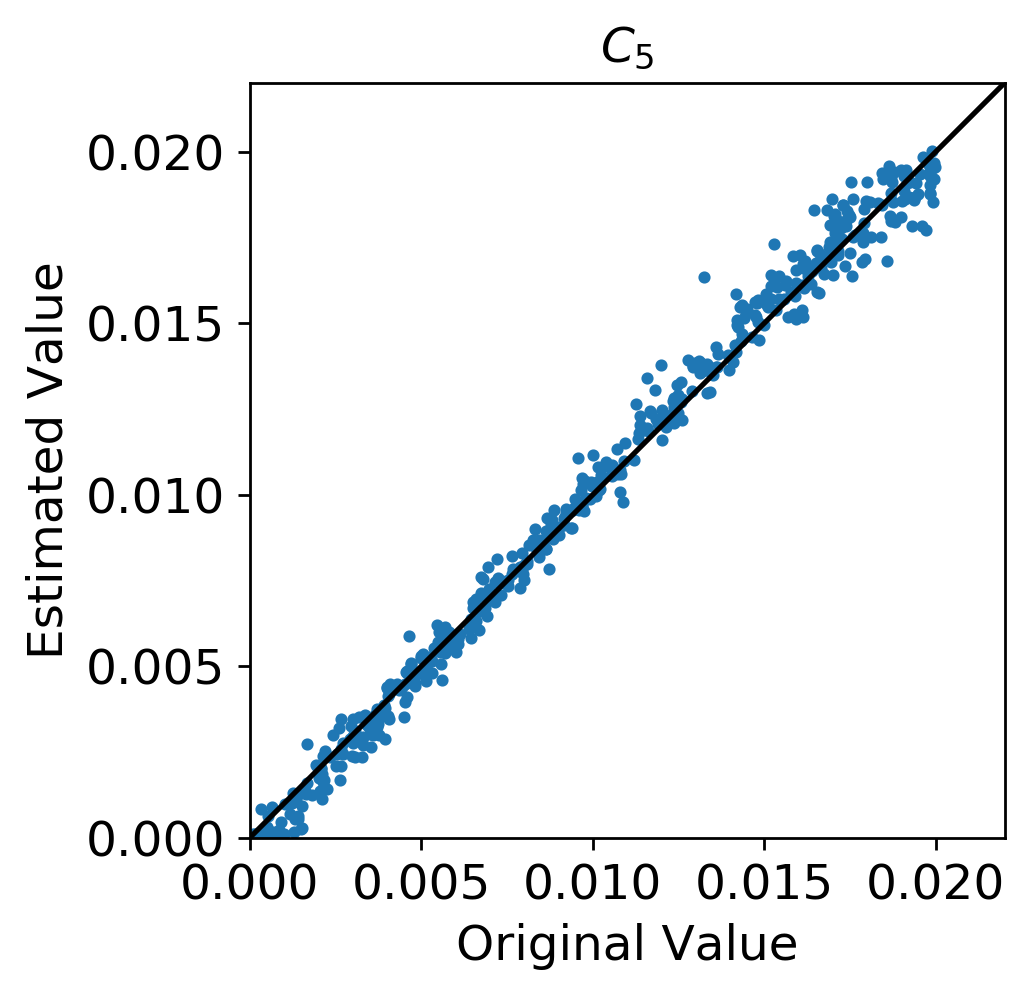

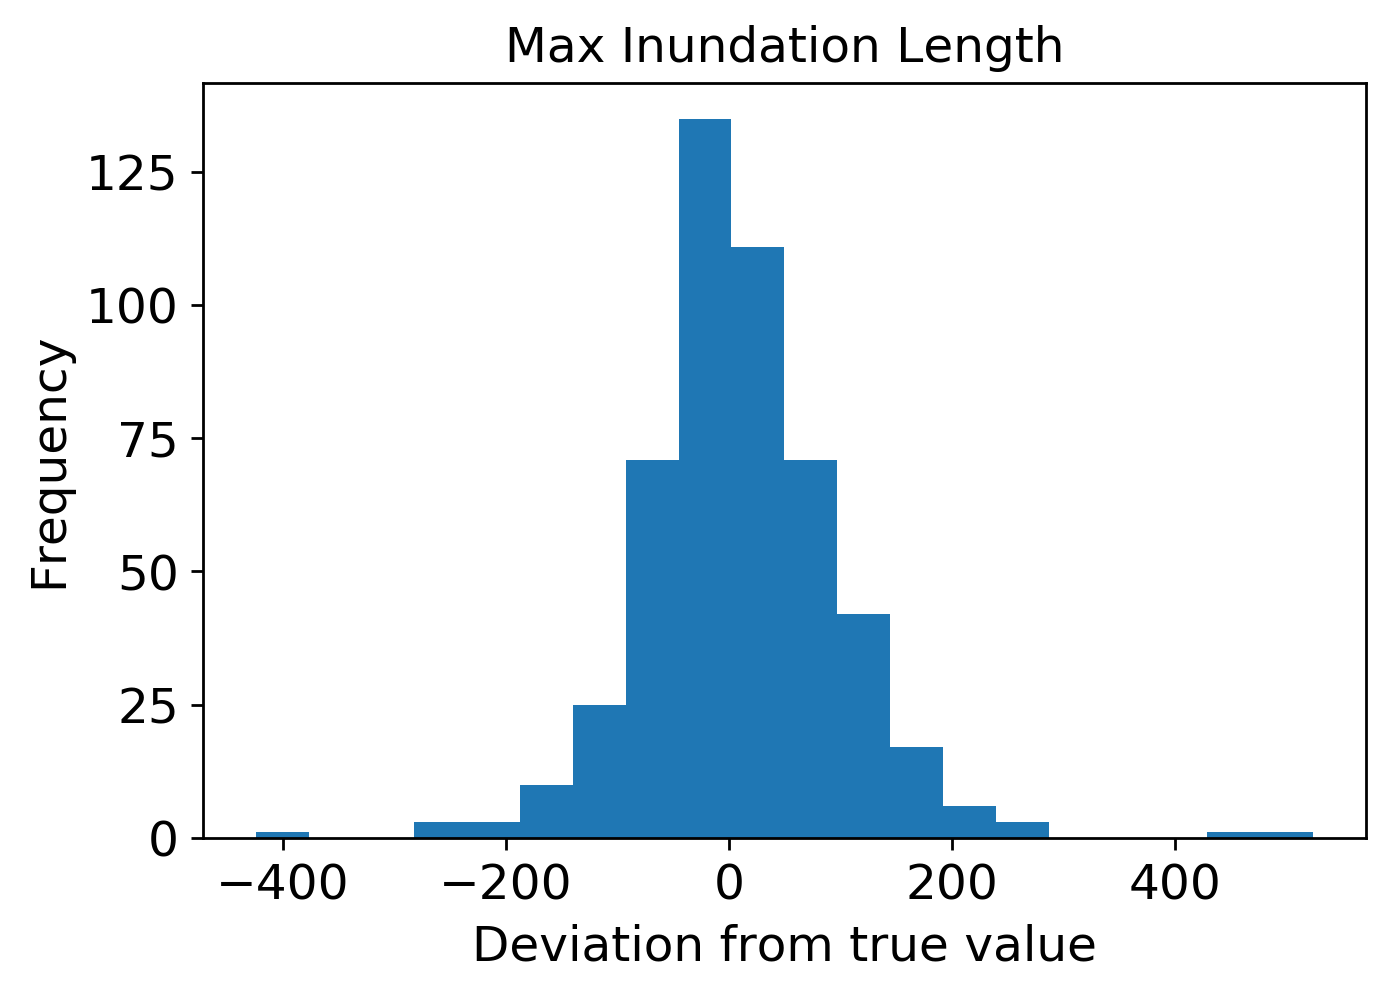

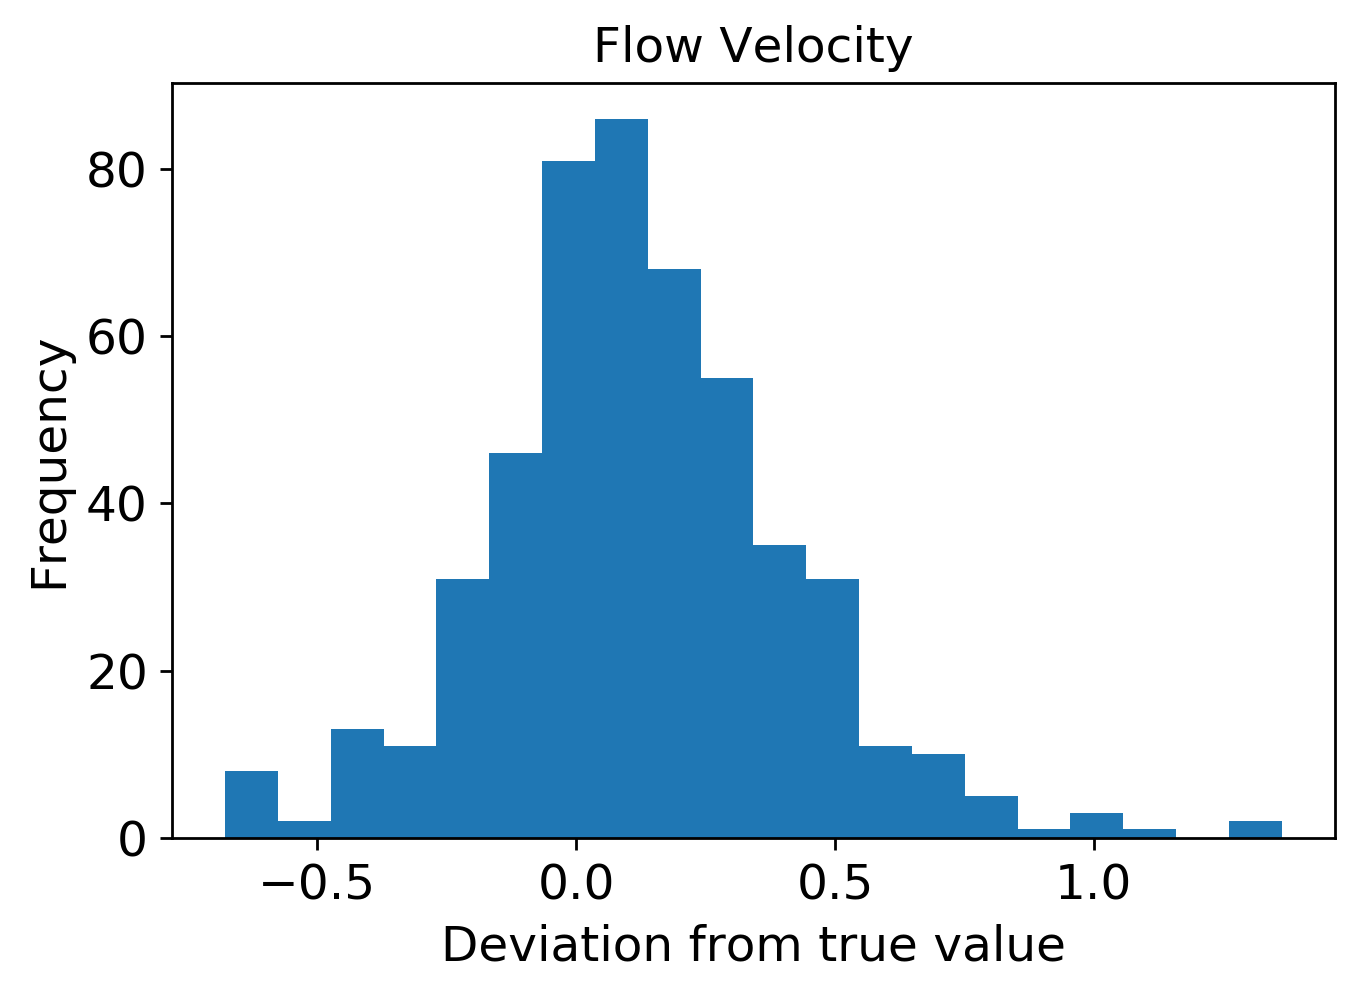

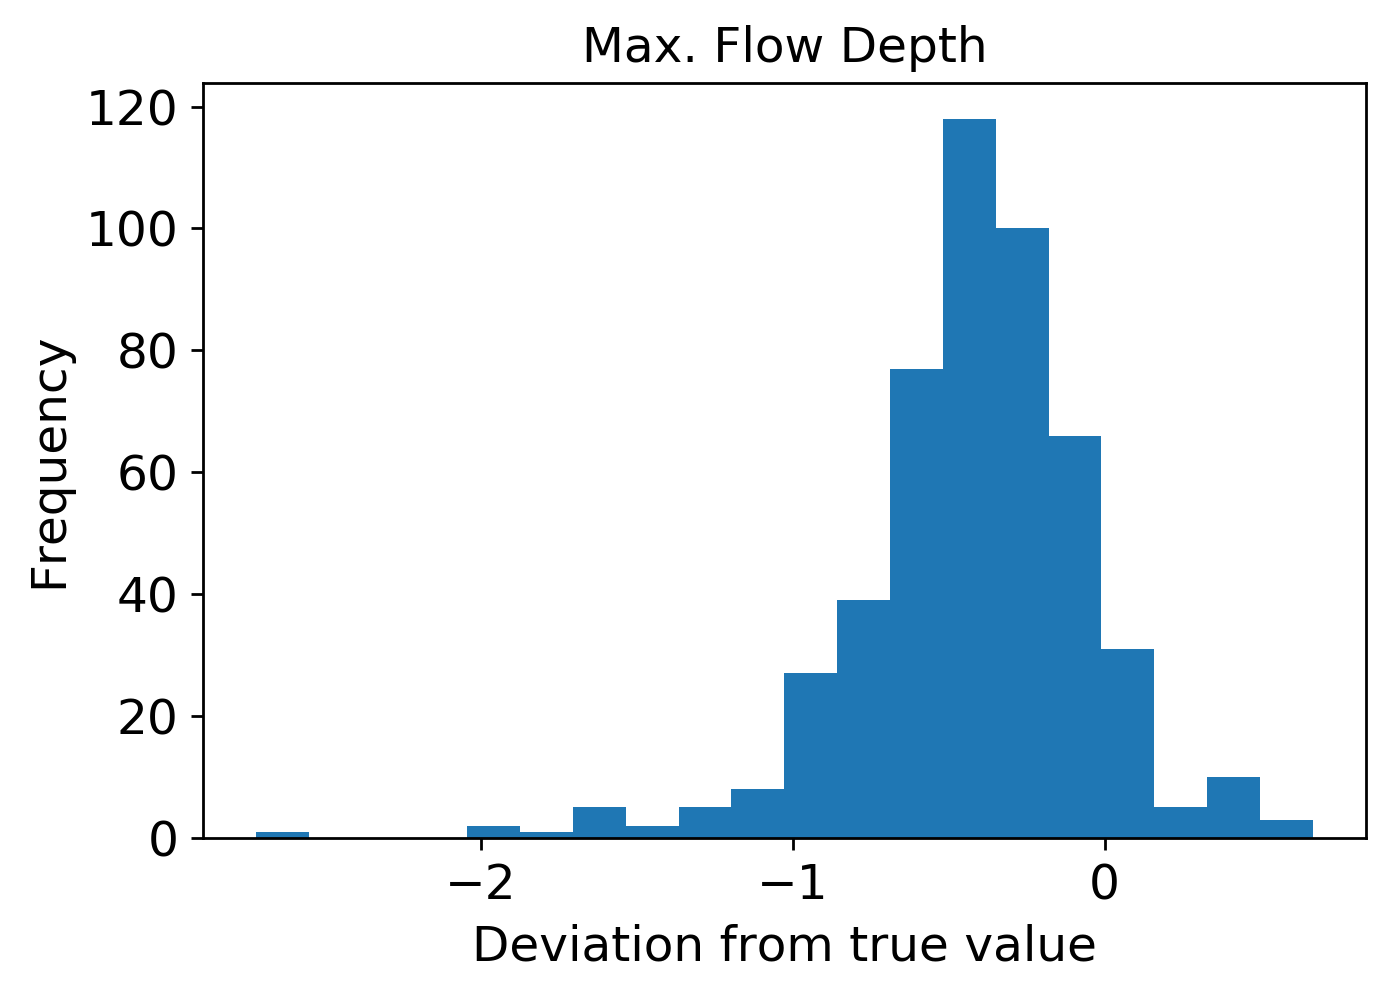

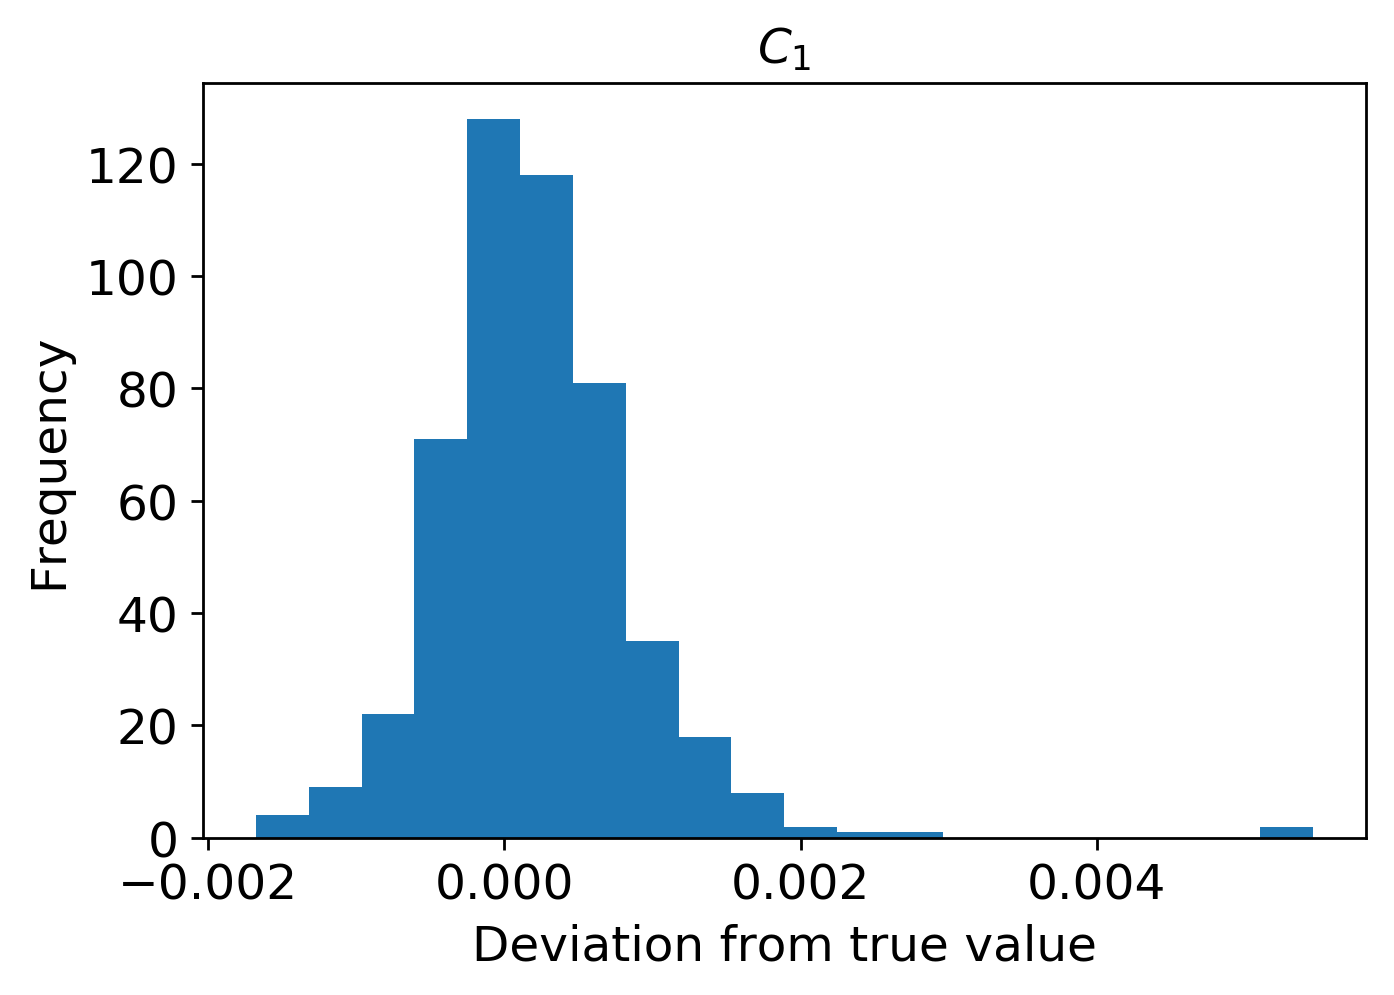

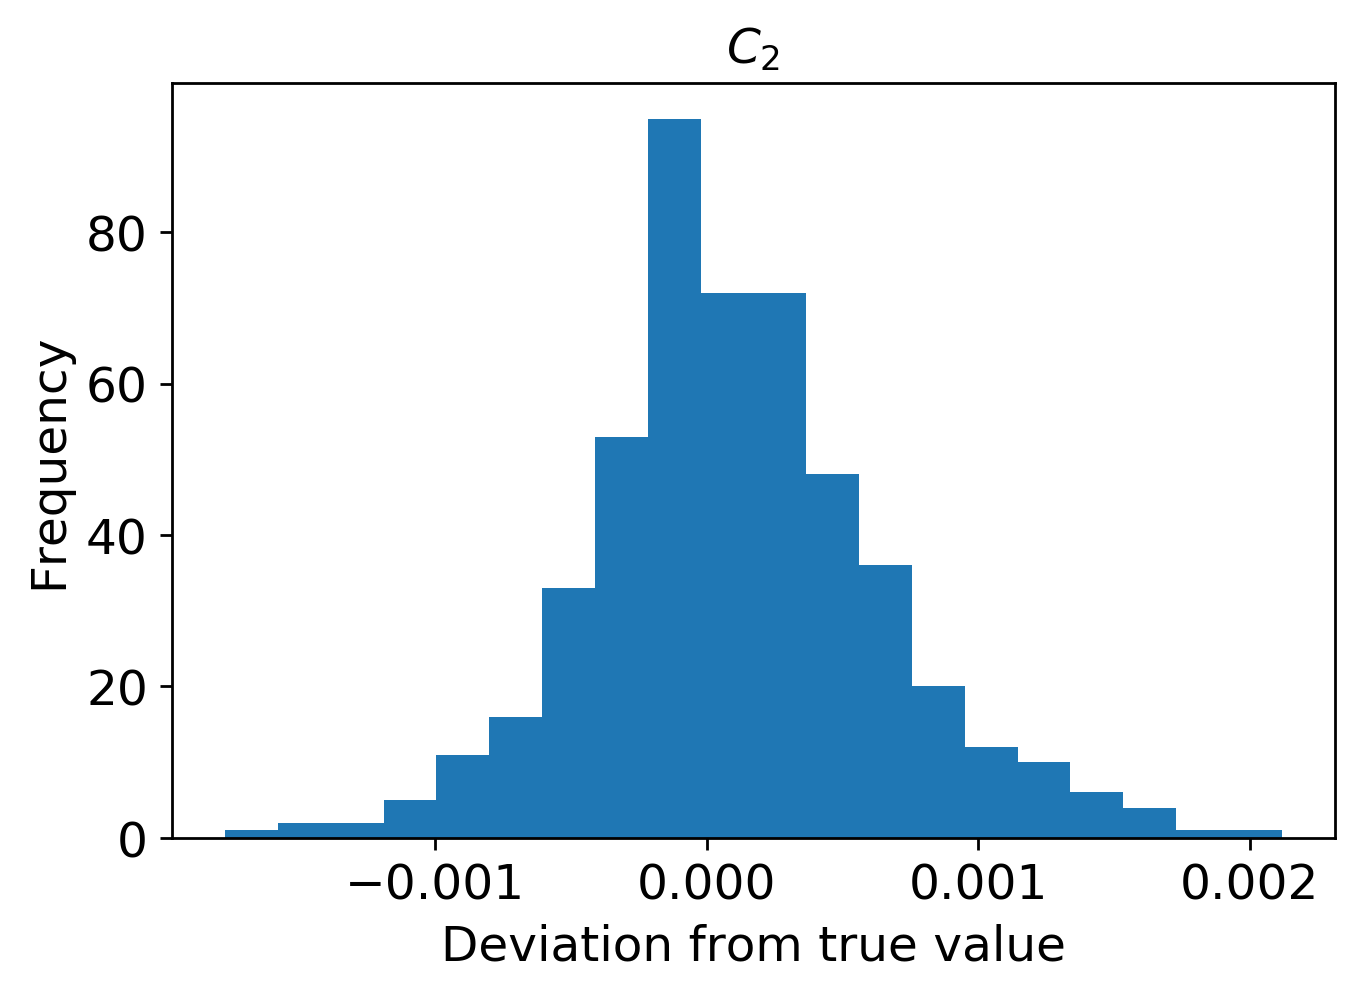

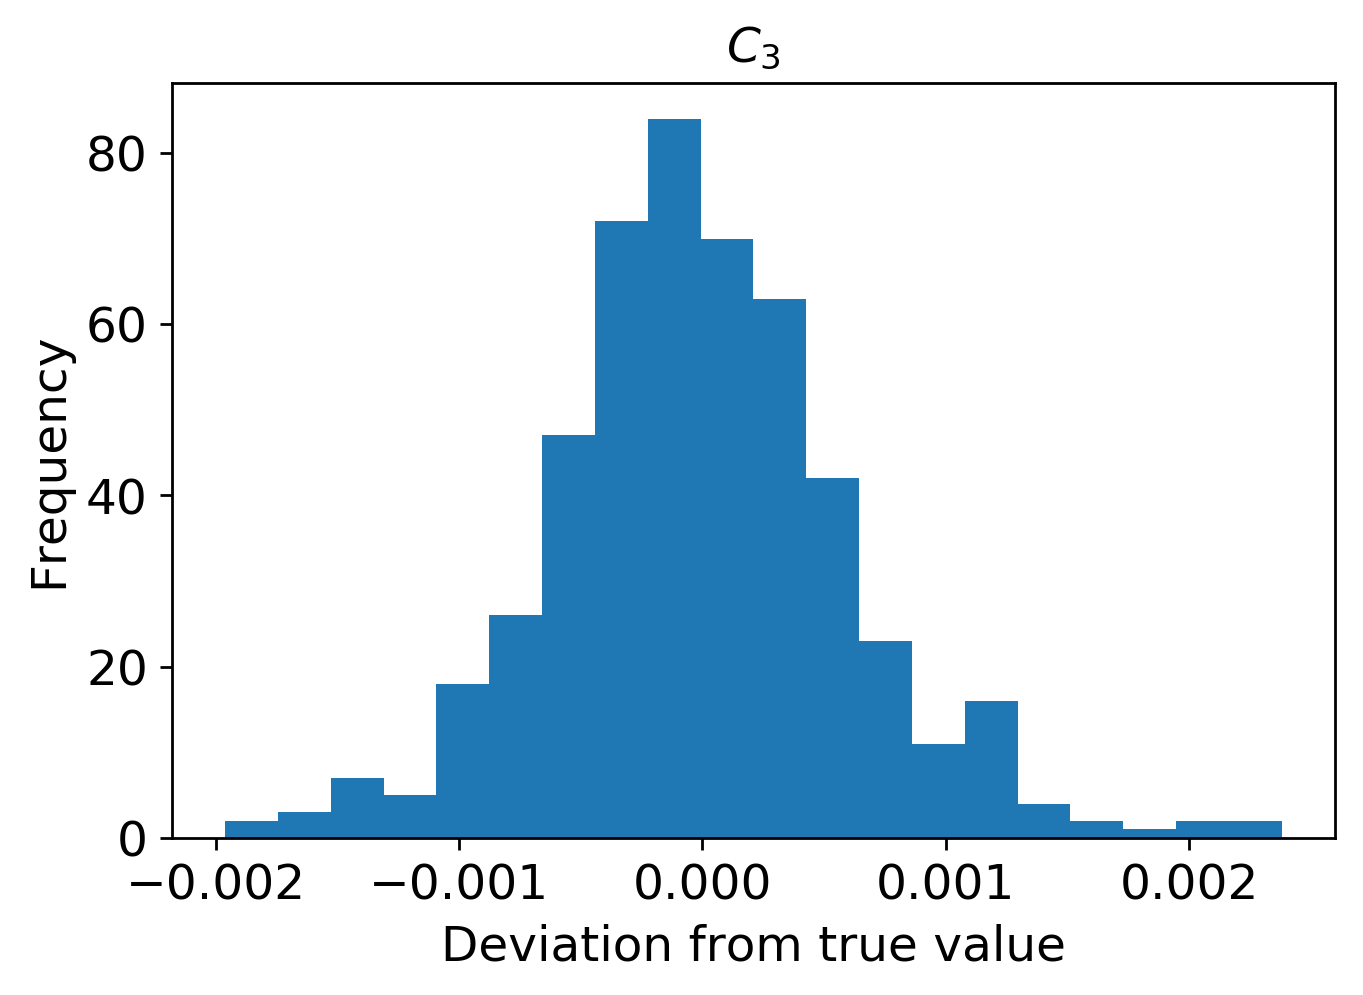

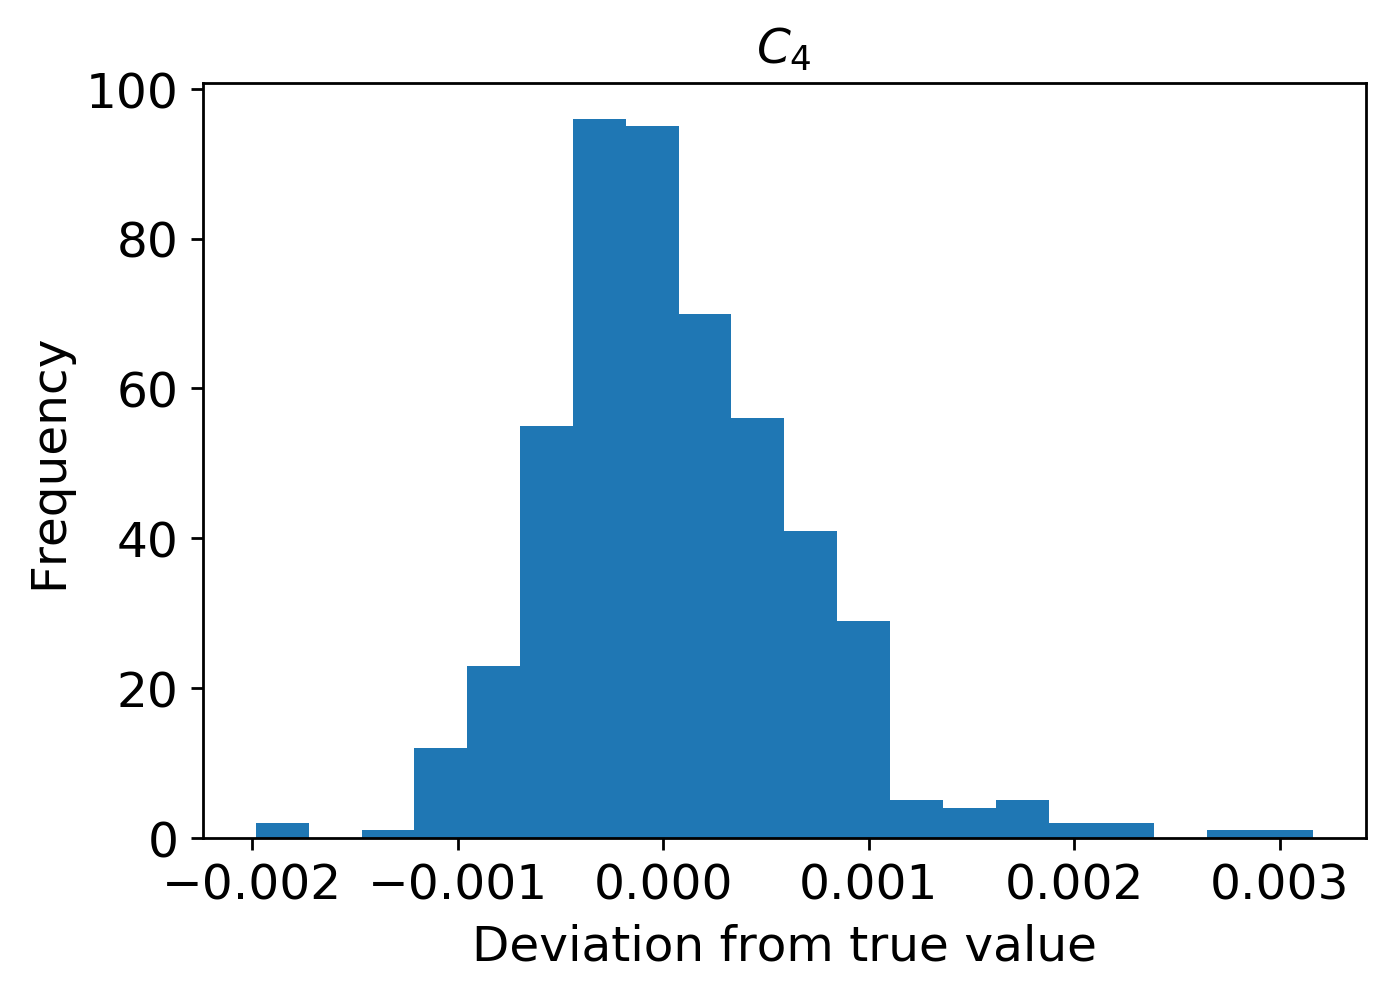

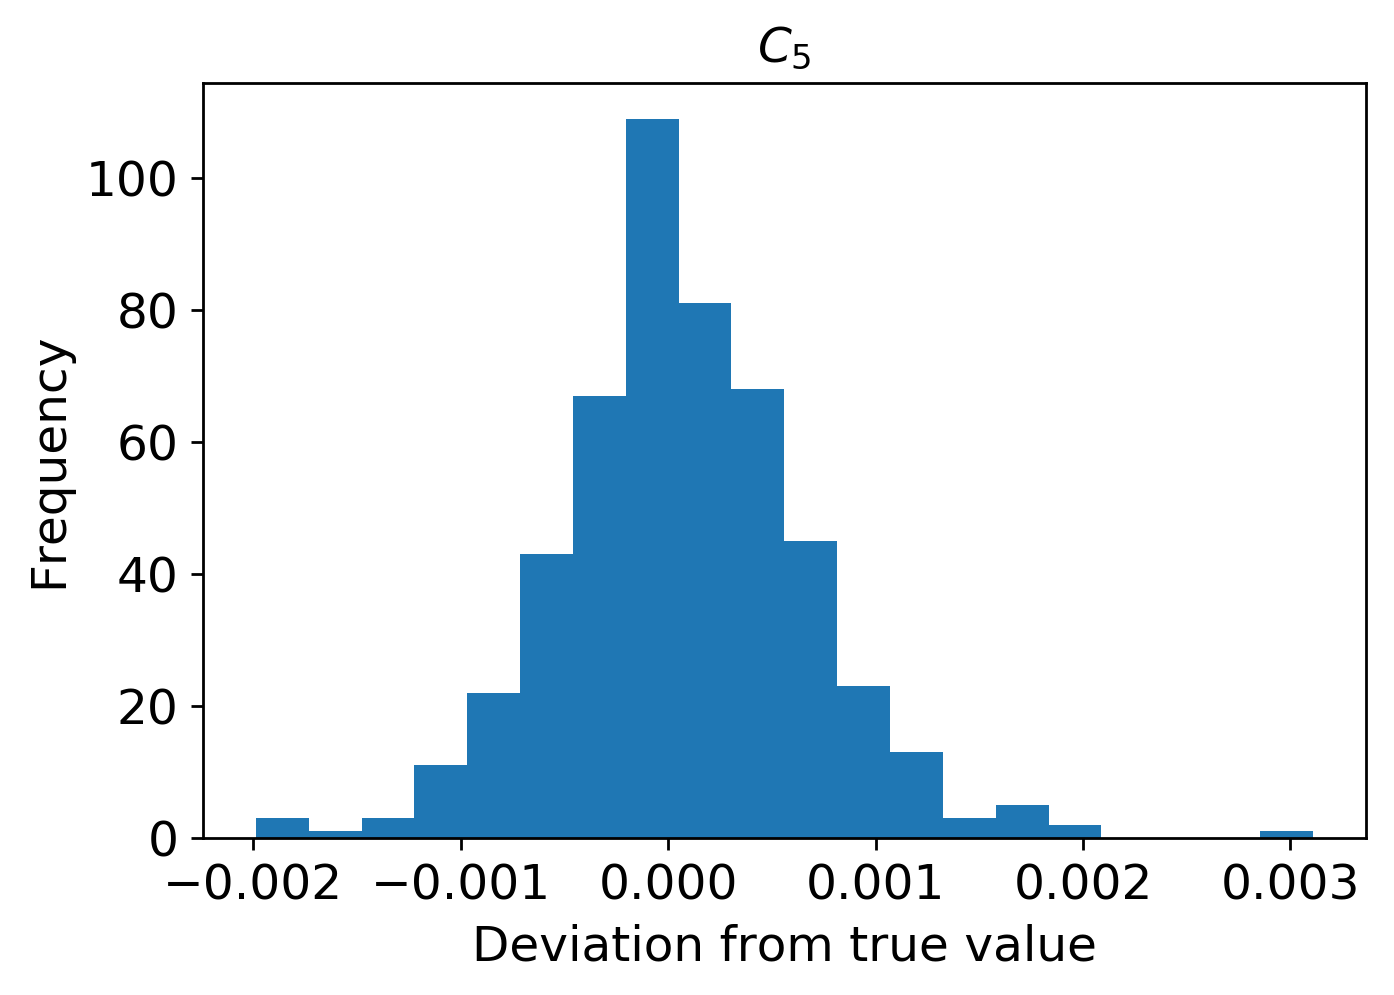

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1700_thai_revised_1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1700_thai_revised_1/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
loss = np.loadtxt(resdir+'loss.txt',delimiter=',')
epoch = range(0,2000)
vloss = np.loadtxt(resdir+'val_loss.txt',delimiter=',')
resi = test_result - icond

fig = plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
plt.plot(epoch, loss, 'bo',label='Loss')
plt.plot(epoch, vloss, 'yo',label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend(loc="upper right")
plt.savefig(resdir+ 'mse.pdf')
plt.show()

fig2 = plt.figure()
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', '$C_1$', '$C_2$', '$C_3$', '$C_4$','$C_5$']
xymin=[1700,2.0,1.5,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005]
stepmin=[1700,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025]

    
for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(icond[:,i],test_result[:,i],"o",markersize = 2.5)
    x=icond[:,i]
    y=test_result[:,i]
    max_value = np.max([x, y])
    min_value = np.min([x, y])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    #plt.plot([xymin[i],xymax[i]],[xymin[i],xymax[i]],"-",color = 'k')
    plt.axes().set_aspect('equal')
    #plt.ylim(xymin[i],xymax[i])
    #plt.xlim(xymin[i],xymax[i])
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.xlabel('Original Value',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated Value',color=textcol,size=14,**hfont)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + '.eps')
    plt.savefig(resdir+titlelabel[i] + '.pdf')
    #plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

(500, 8)
Standard Deviation: 88.61889652852102
Standard Deviation sample: 88.70764857532998
Mean: 8.87696260589481
CV: 9.993018165517903


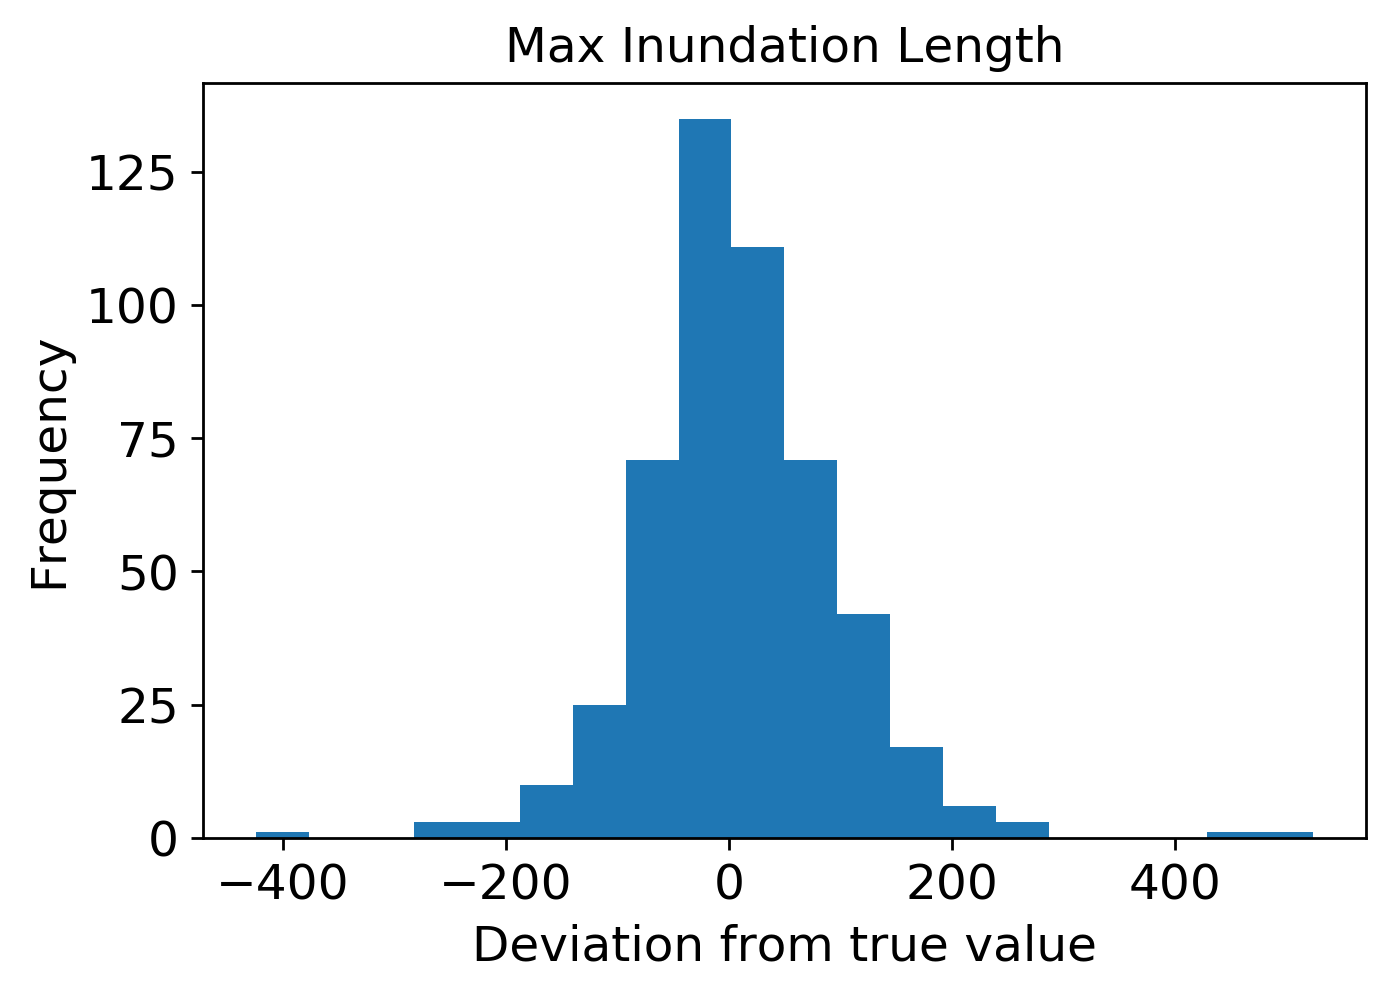

Standard Deviation: 0.2918457646671137
Standard Deviation sample: 0.29213804893132134
Mean: 0.12414741295854784
CV: 2.353154544016674


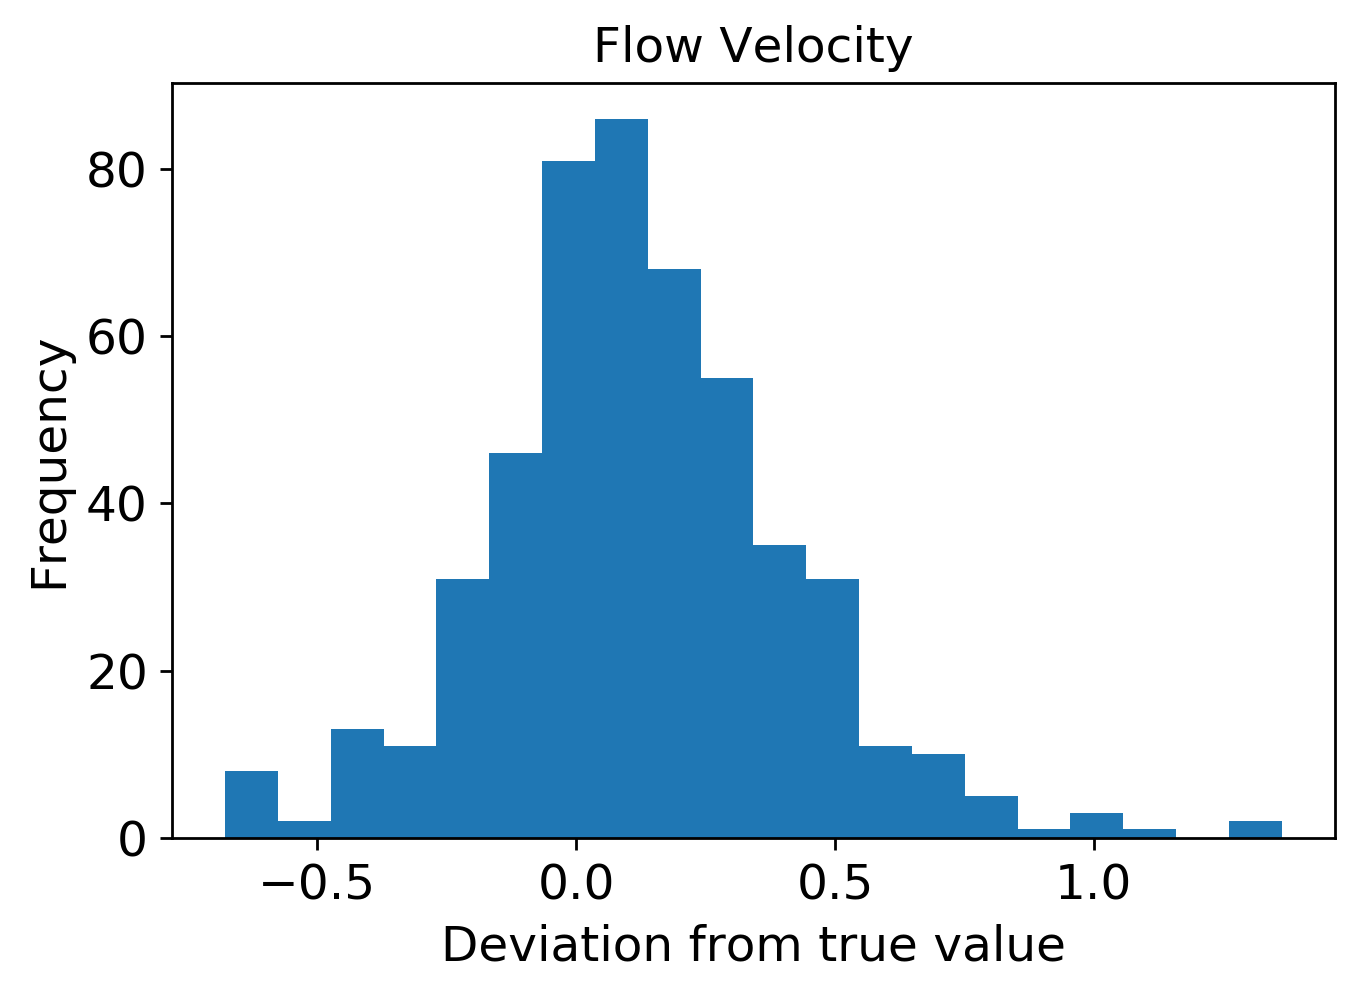

Standard Deviation: 0.3777829287800879
Standard Deviation sample: 0.37816127932937427
Mean: -0.42594962618934334
CV: -0.8878075154390999


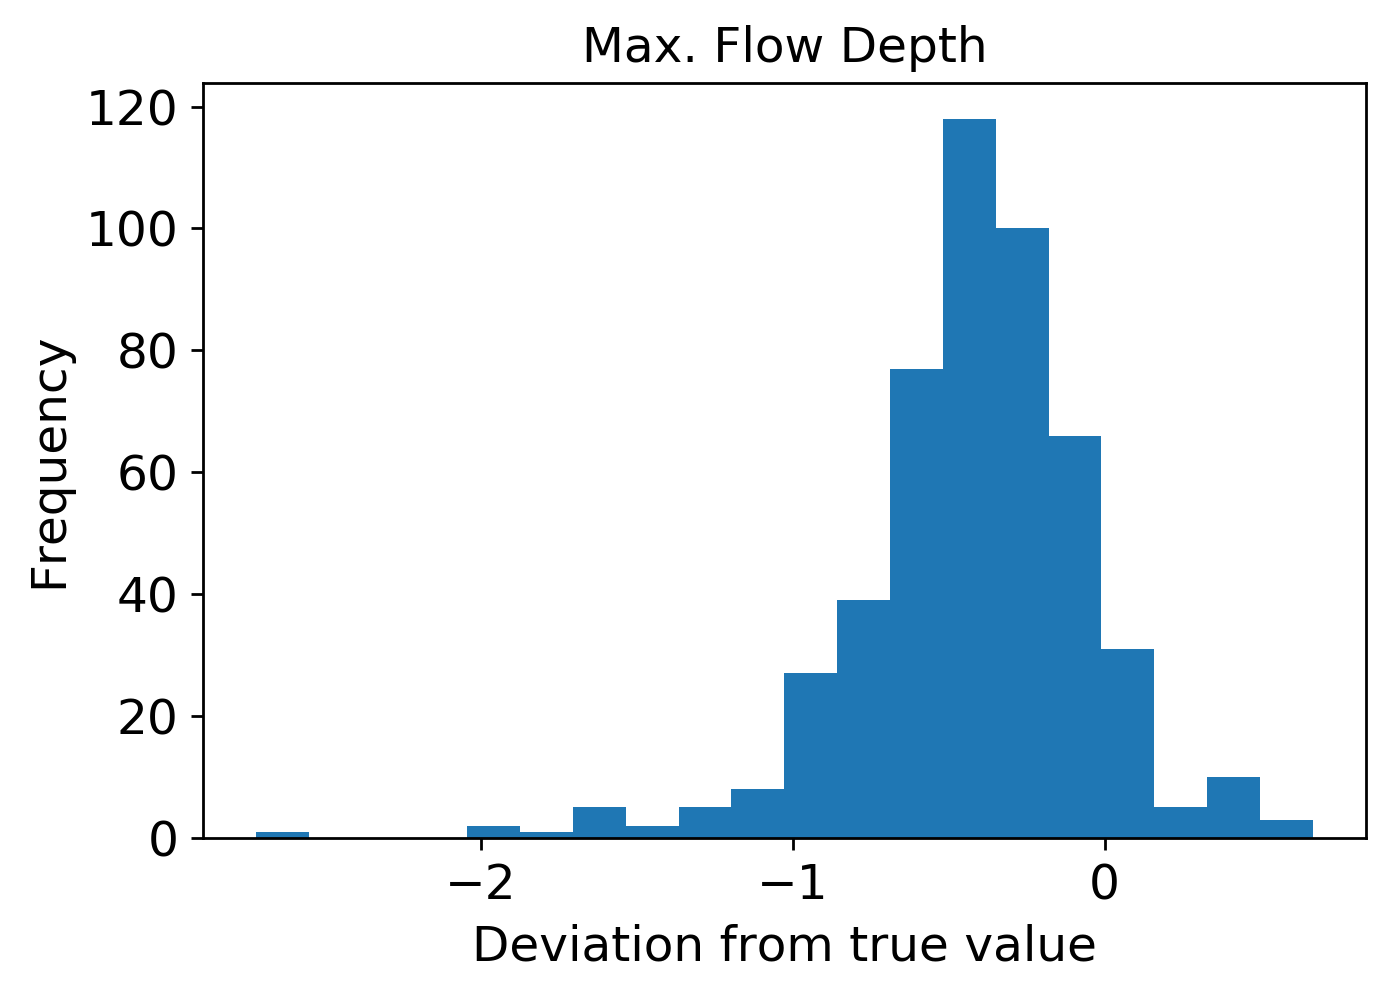

Standard Deviation: 0.0006841706508535628
Standard Deviation sample: 0.0006848558494738178
Mean: 0.00020570726483857464
CV: 3.329274005034519


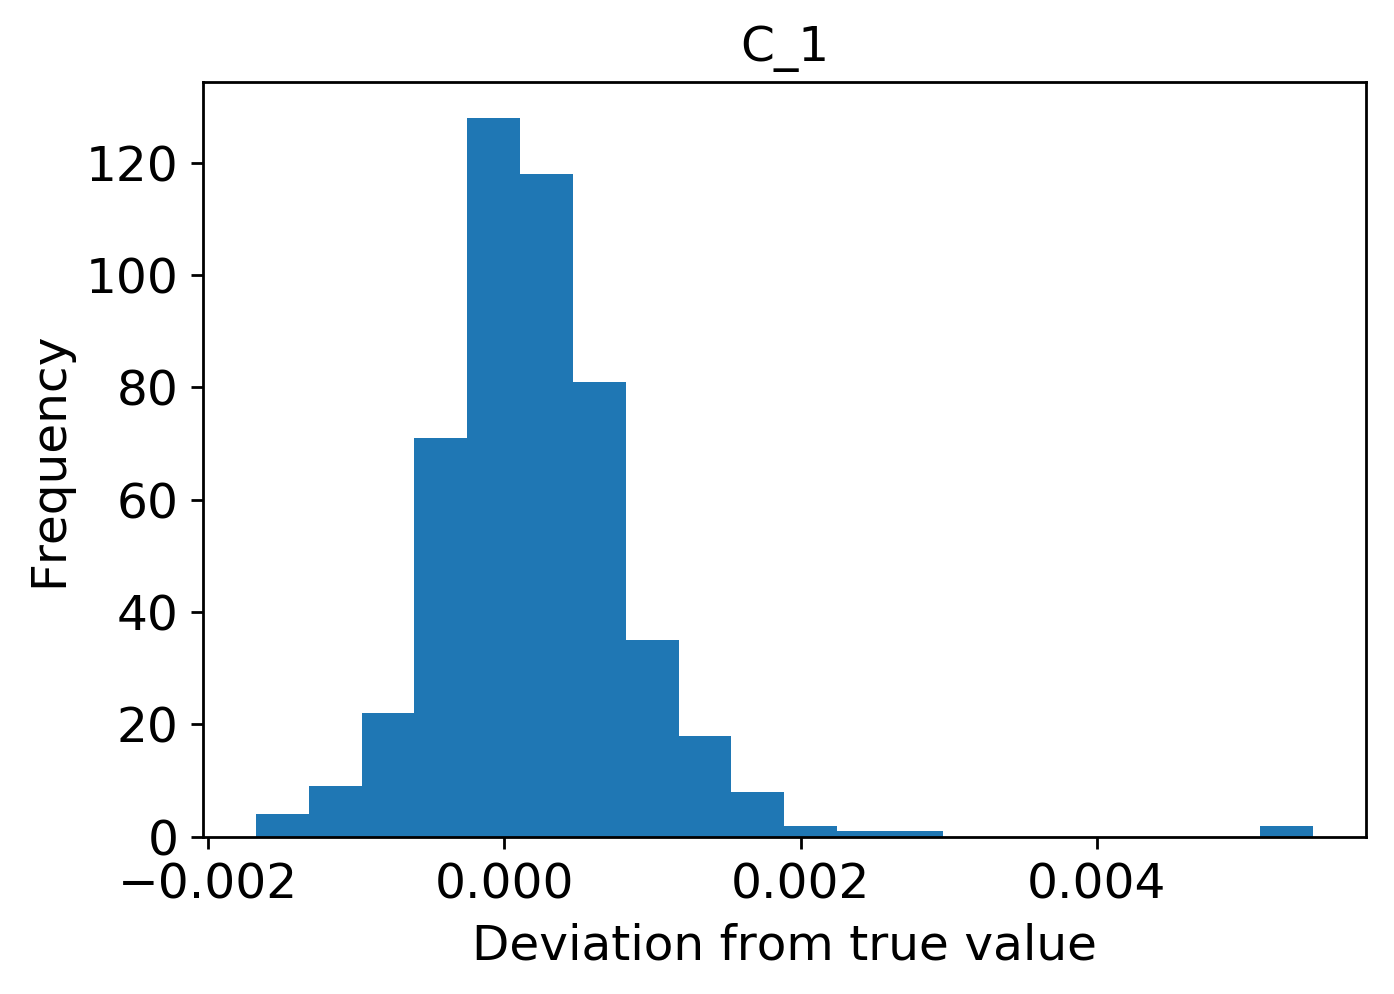

Standard Deviation: 0.000544965793464282
Standard Deviation sample: 0.0005455115780712396
Mean: 0.00010596978776573946
CV: 5.147802874505767


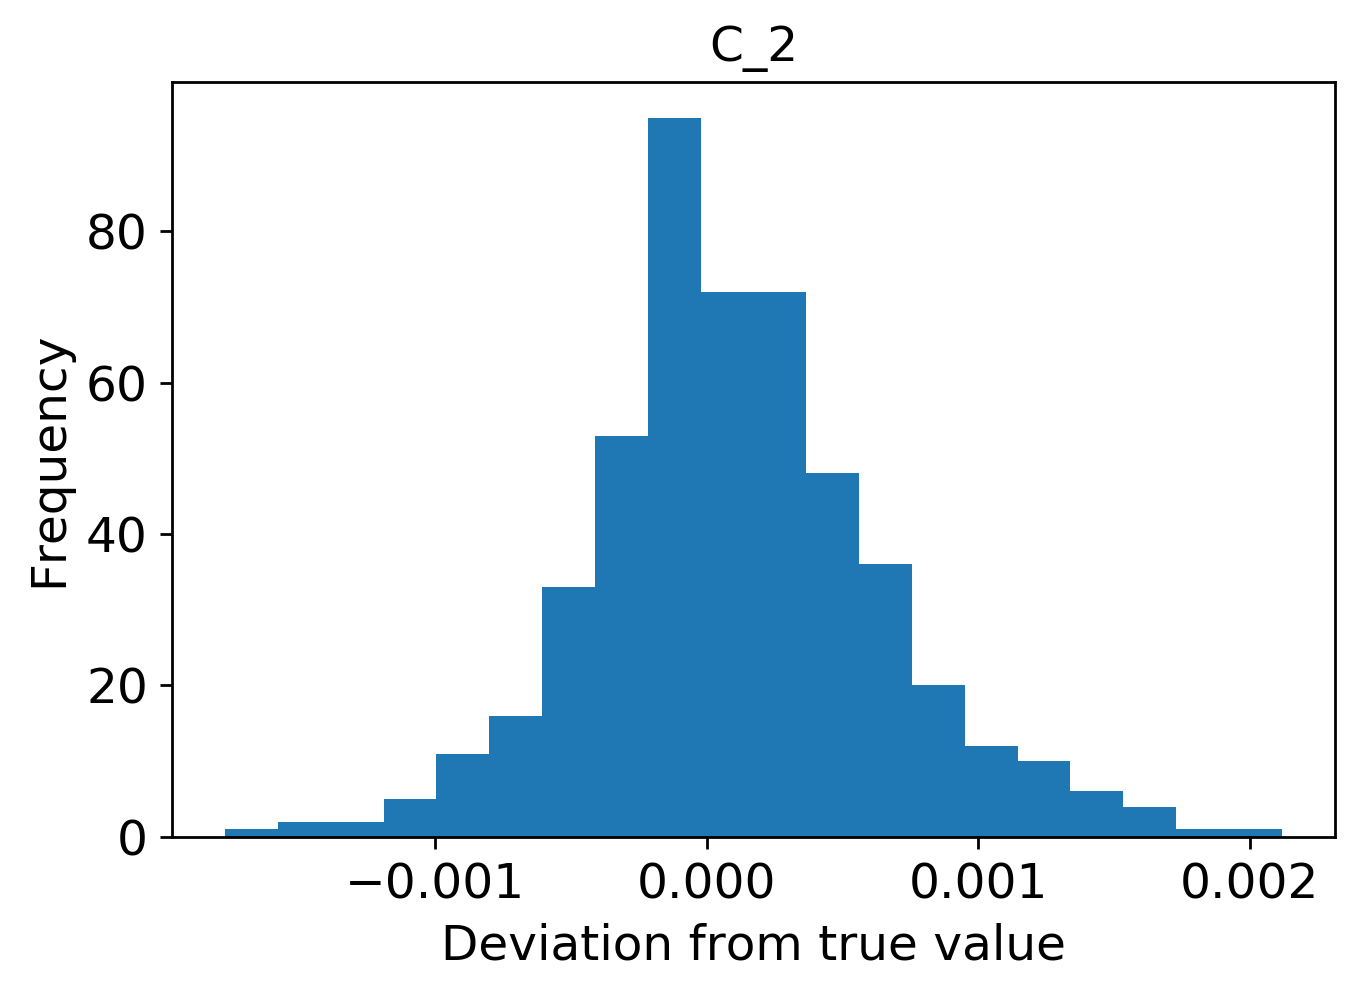

Standard Deviation: 0.0006156840851369275
Standard Deviation sample: 0.0006163006942901009
Mean: -1.3916239392437026e-05
CV: -44.28643952654609


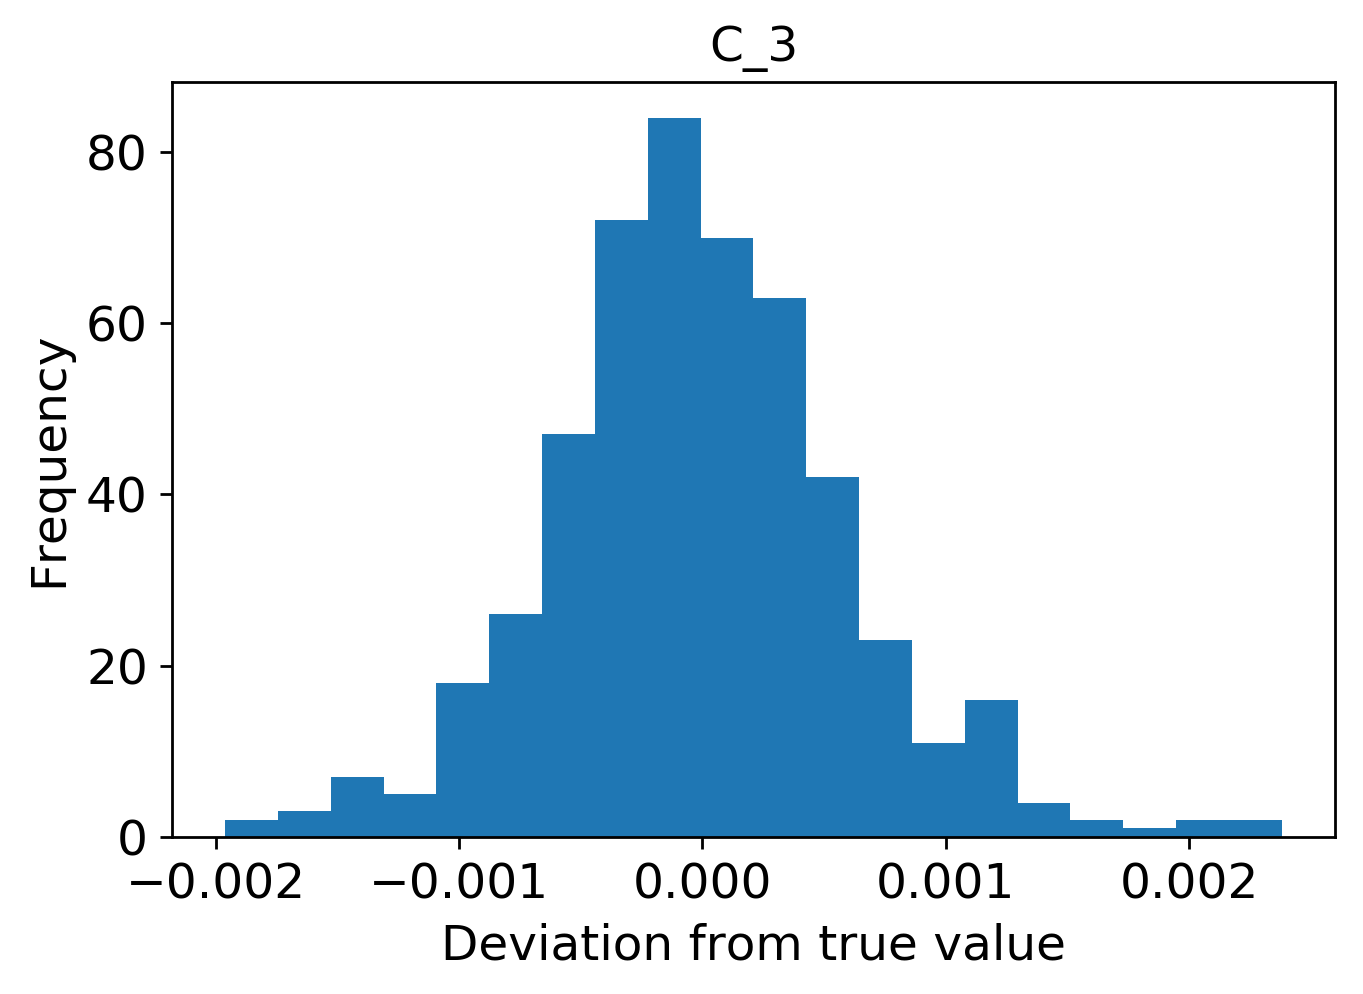

Standard Deviation: 0.0006230574579525649
Standard Deviation sample: 0.0006236814515570788
Mean: 5.9521905997814106e-05
CV: 10.478183470468553


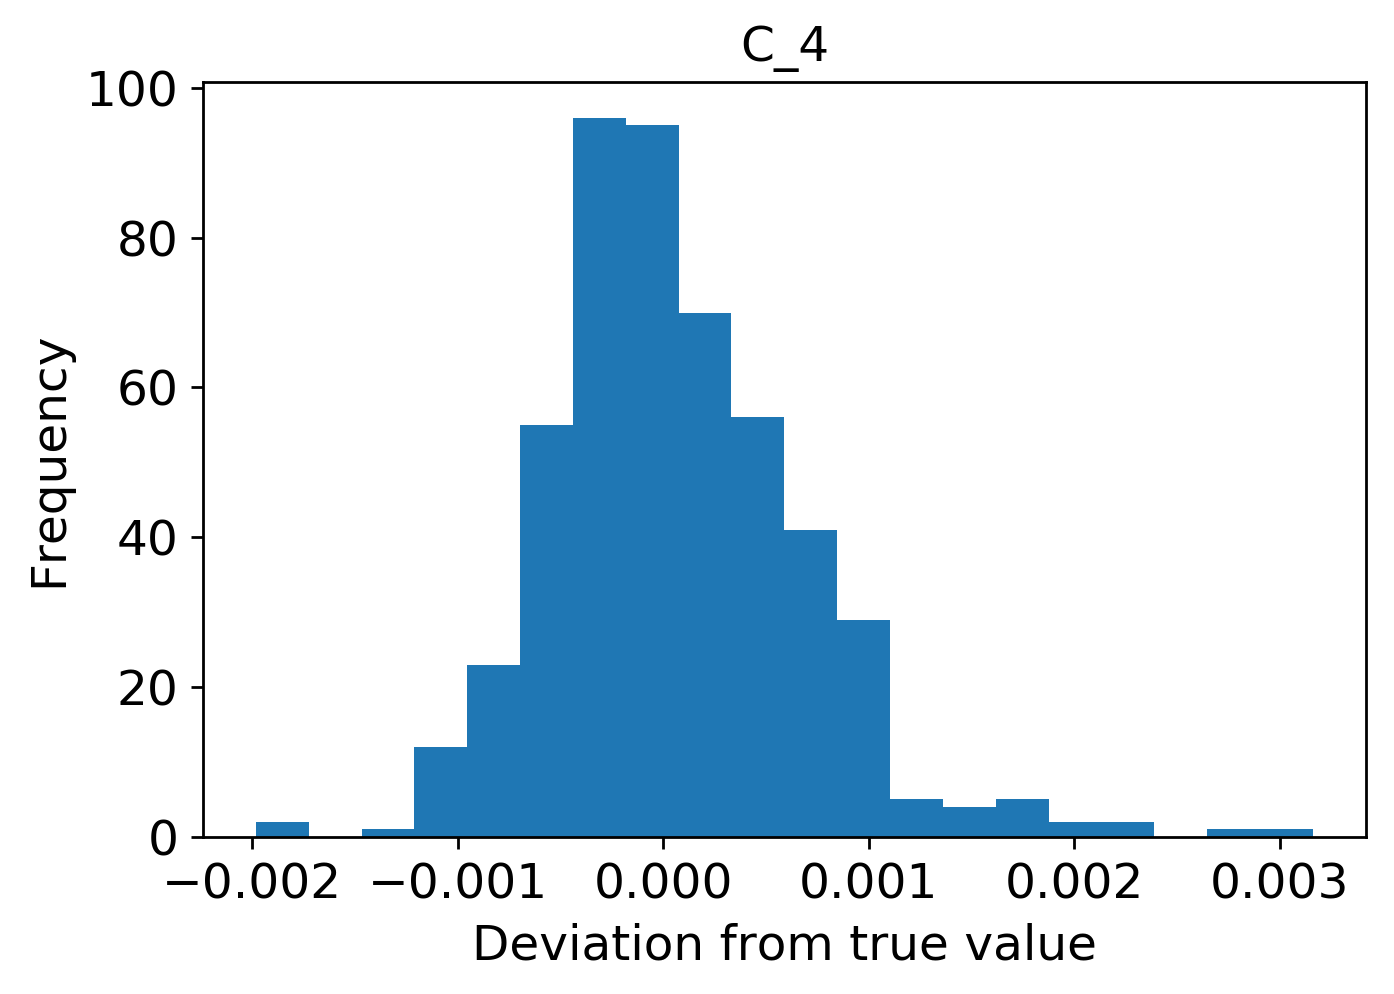

Standard Deviation: 0.000593350689864723
Standard Deviation sample: 0.0005939449320665999
Mean: 7.092363772011223e-05
CV: 8.374428486176923


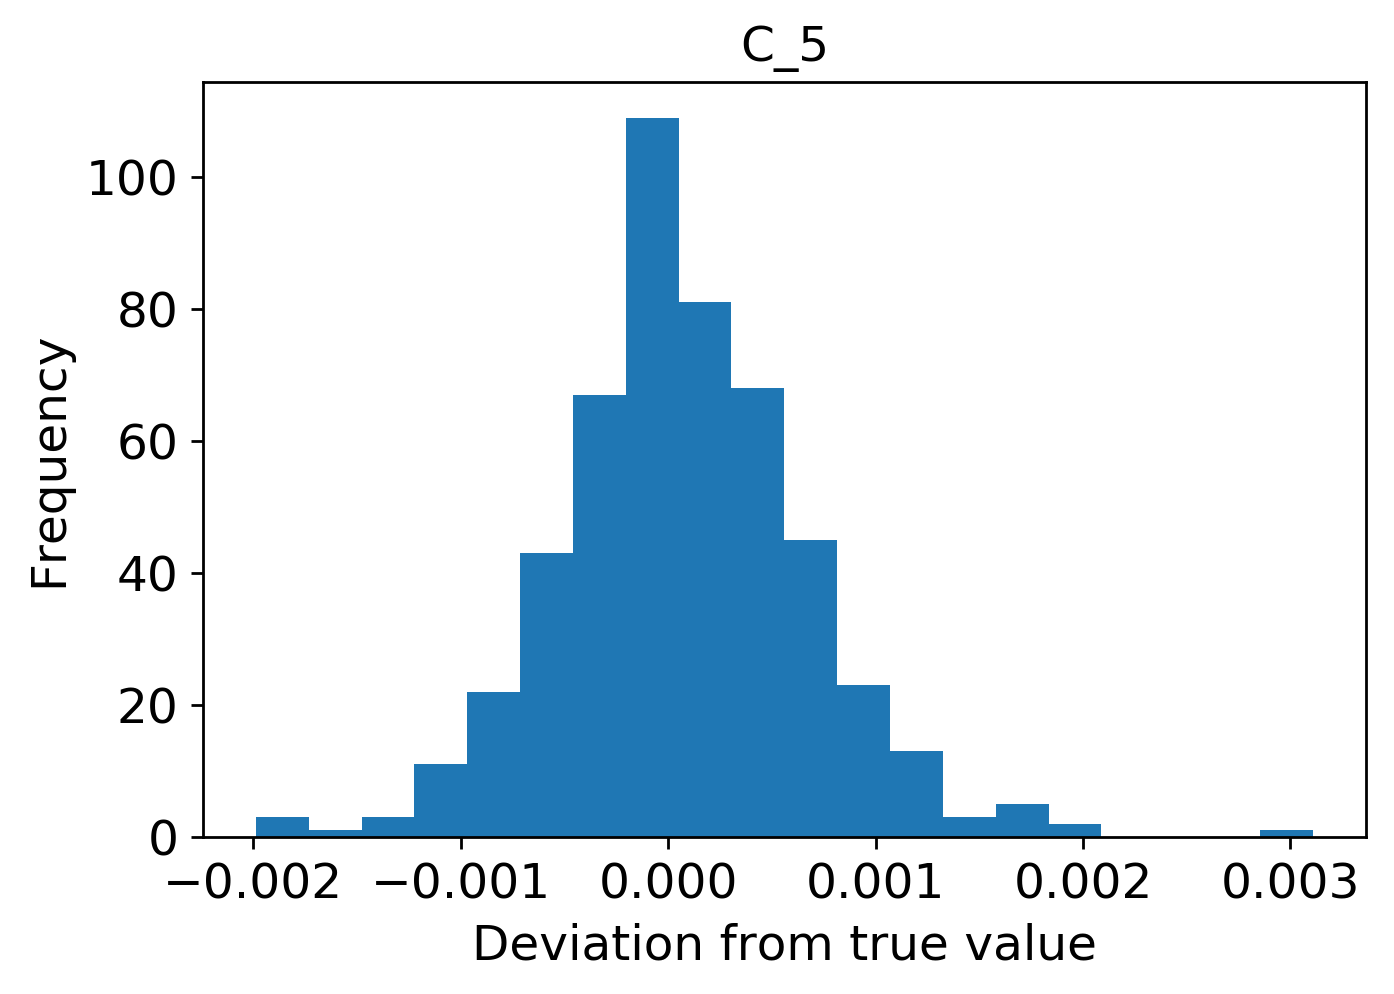

In [2]:
from scipy.stats import variation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1700_thai_revised_1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1700_thai_revised_1/5000/'

test_result = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
icond = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')
print(icond.shape)
resi = test_result - icond
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5']

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation:', np.std(resi[:,i]))
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('CV:', np.std(resi[:,i],ddof=1)/np.mean(resi[:,i]))                           
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist' + '.pdf')
    plt.show()

       distance       726       364       182        91        46
0      0.000000  0.010399  0.029123  0.021142  0.006882  0.000455
1     51.415414  0.004638  0.010623  0.016518  0.016240  0.001981
2    101.541184  0.019090  0.033383  0.021191  0.015271  0.002038
3    132.877704  0.014846  0.036879  0.038916  0.028934  0.003380
4    178.349564  0.000897  0.004421  0.032821  0.048209  0.008753
5    235.252102  0.000248  0.000710  0.009960  0.015168  0.001914
6    267.154762  0.023041  0.013593  0.010173  0.017016  0.003069
7    296.463078  0.012222  0.011268  0.008694  0.012747  0.002035
8    344.938070  0.004596  0.009952  0.017344  0.020869  0.003623
9    414.104500  0.002789  0.004262  0.019079  0.031537  0.006802
10   458.884217  0.000450  0.000735  0.006082  0.009064  0.001527
11   491.715389  0.006784  0.018716  0.026314  0.023898  0.003289
12   525.944070  0.000312  0.000670  0.008444  0.013288  0.002287
13   607.657771  0.006453  0.015906  0.031496  0.038024  0.007074
14   673.2

/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/home/rimali2009/anaconda3/envs/test3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Century Gothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


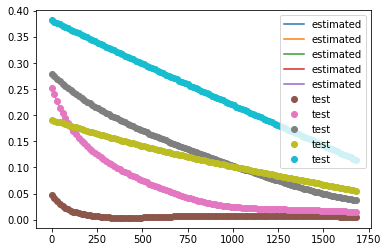

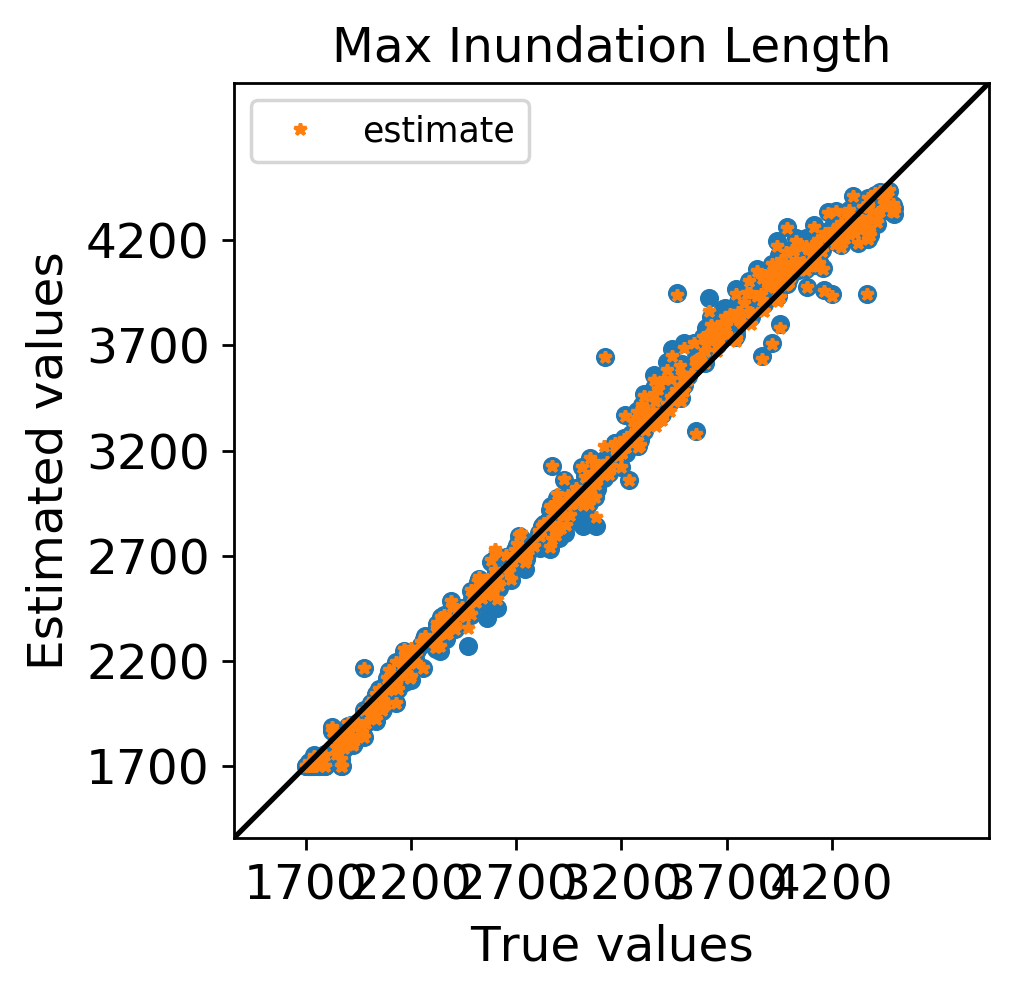

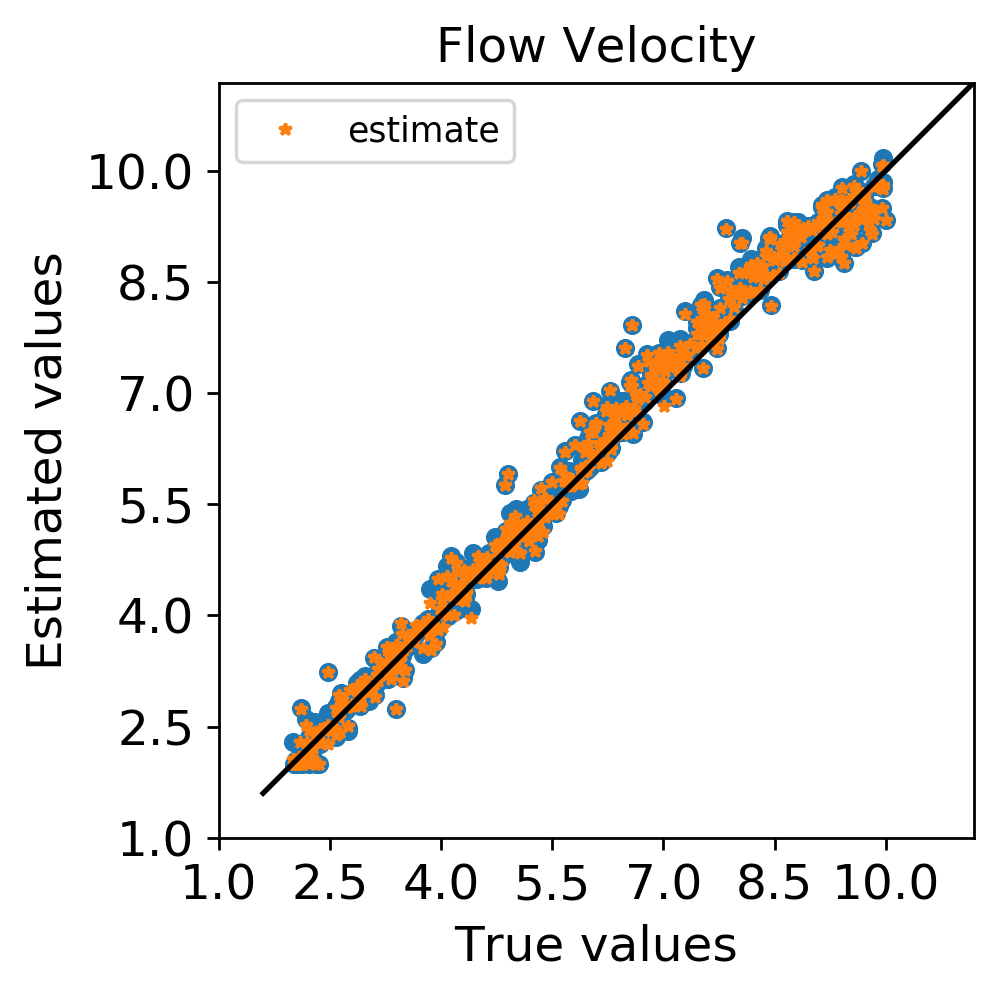

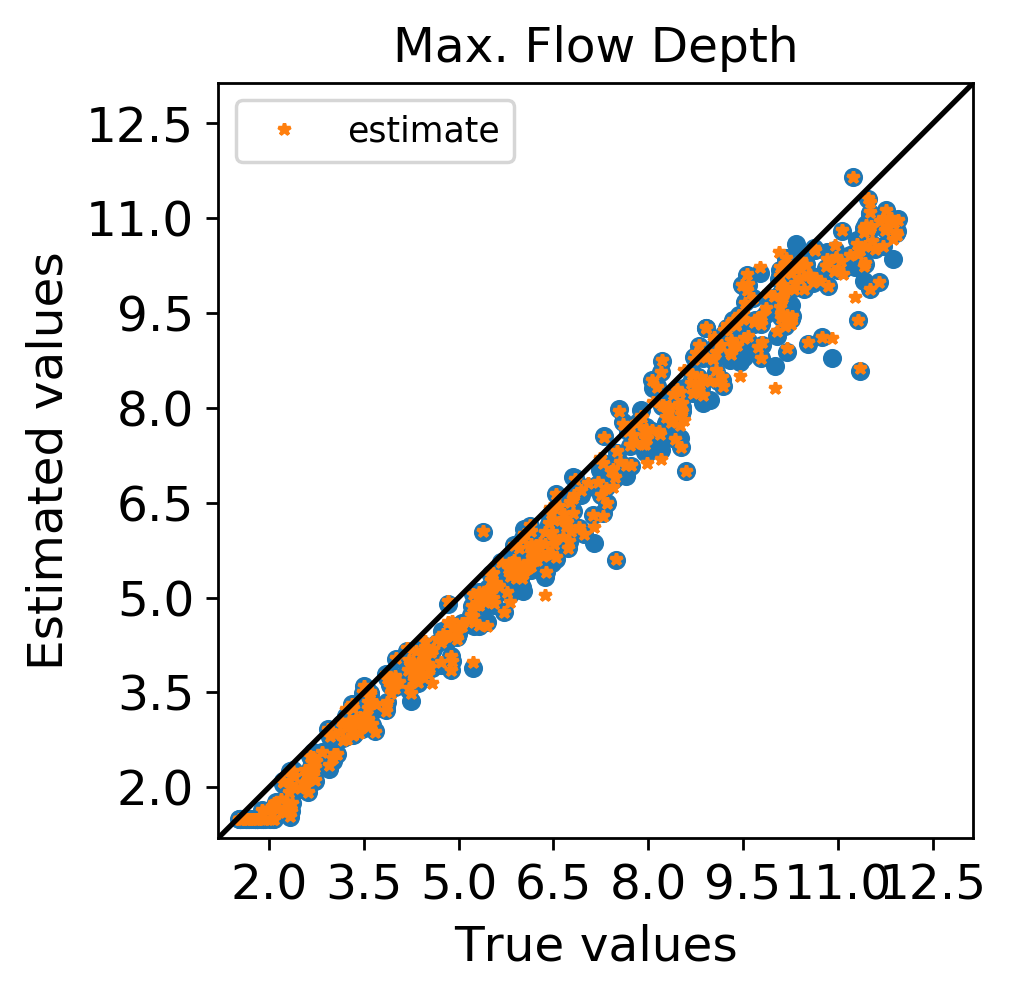

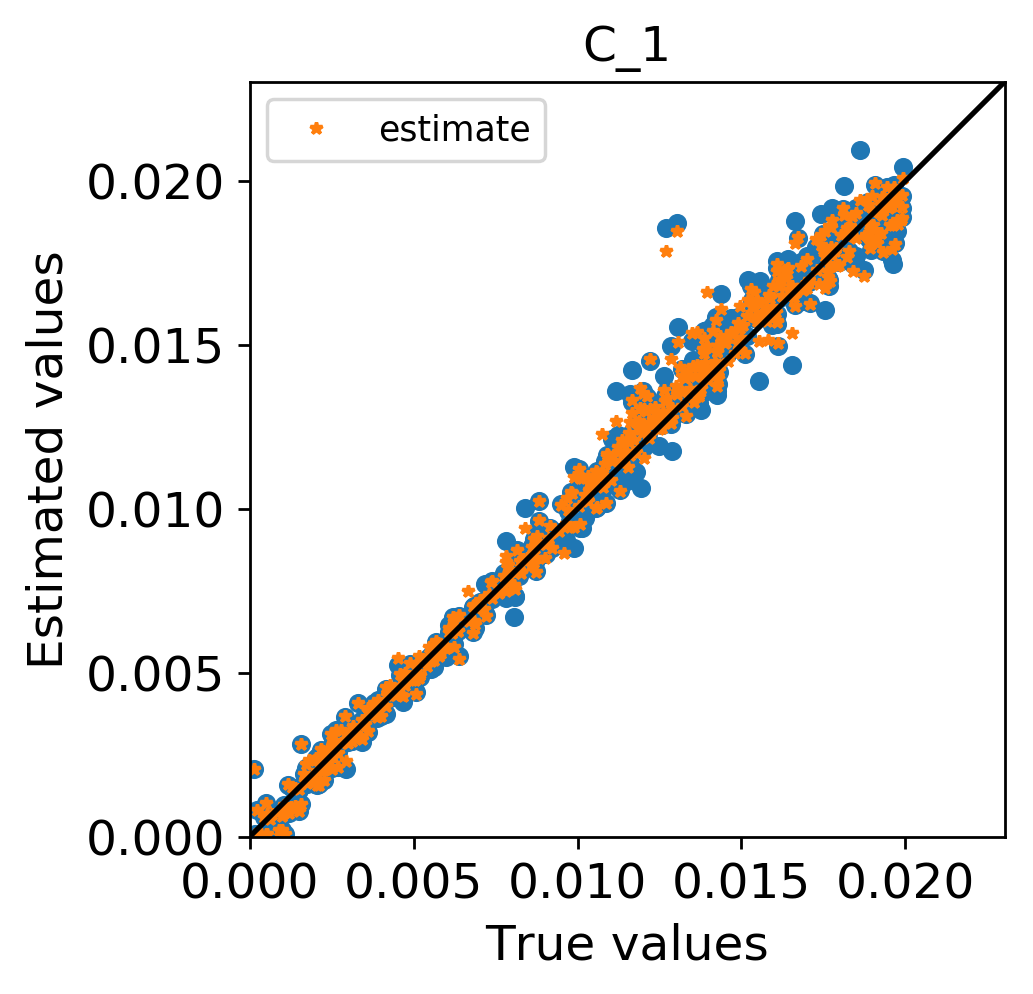

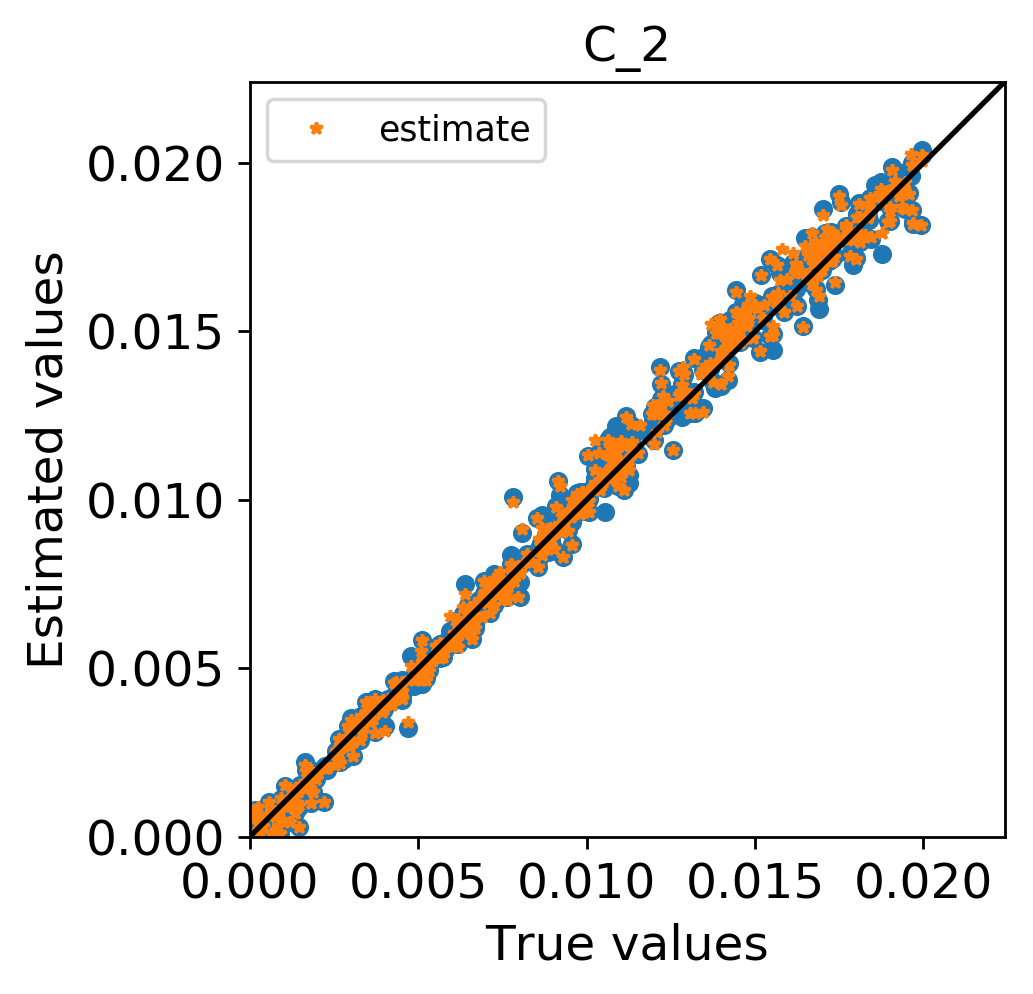

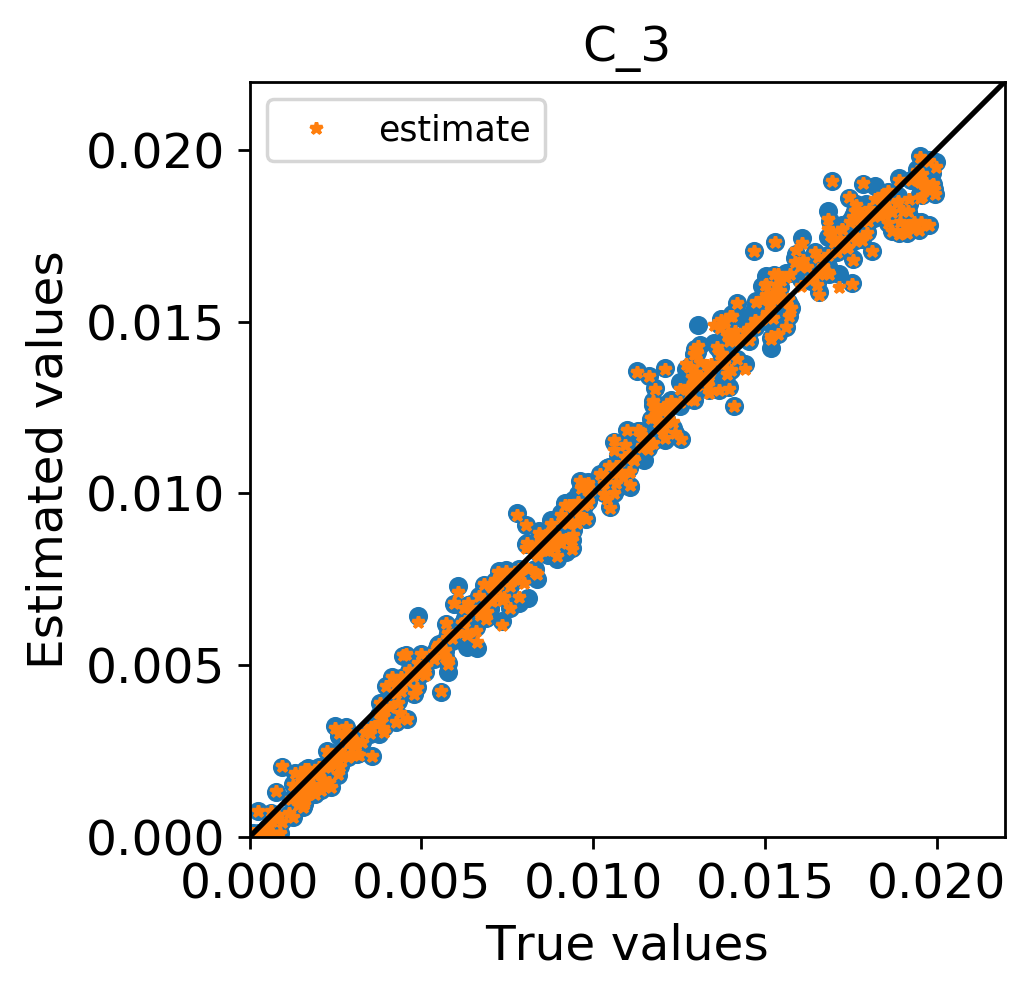

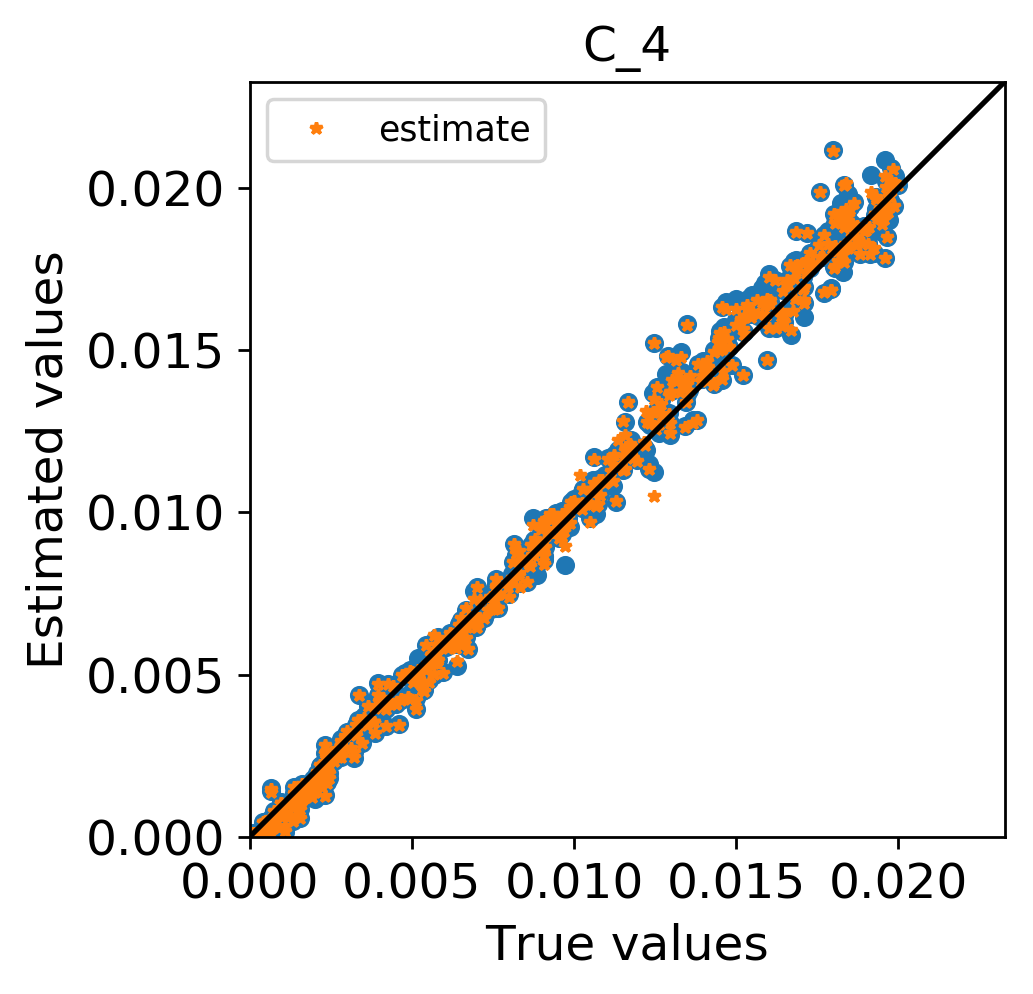

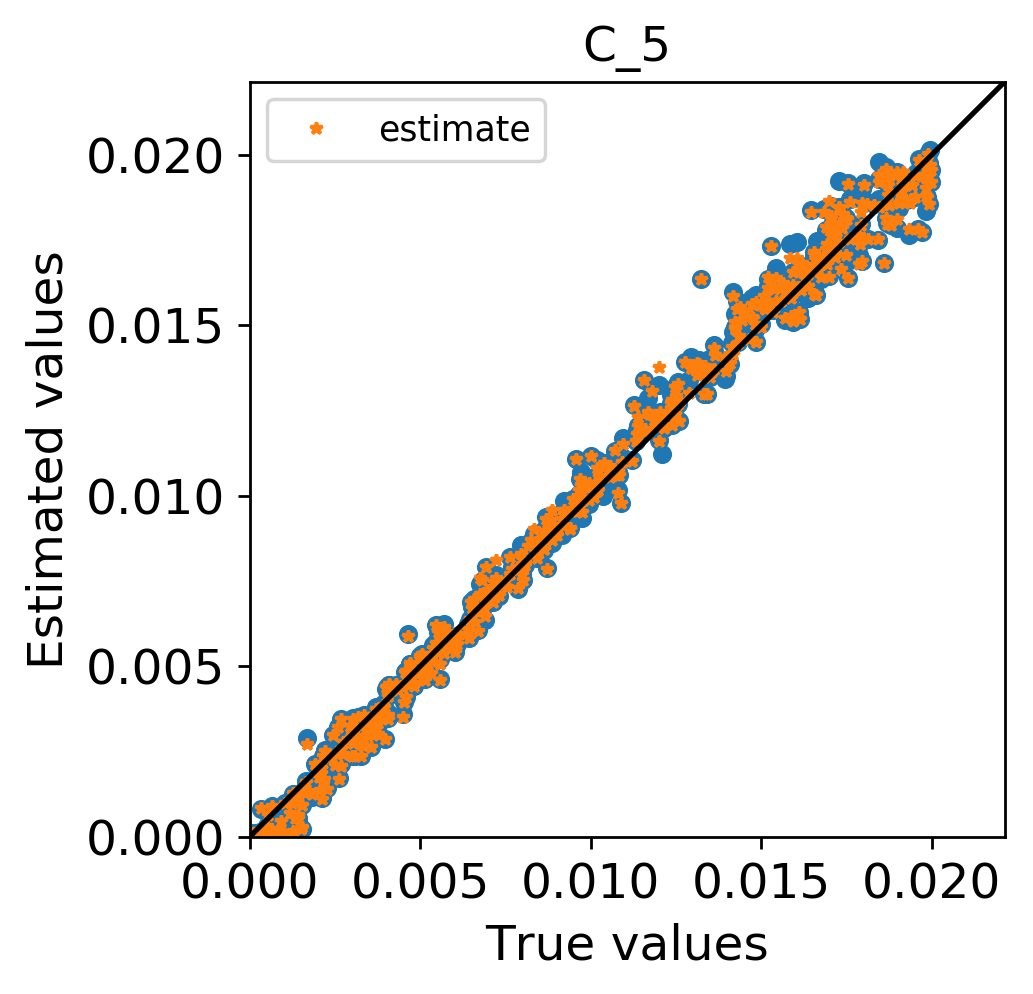

Standard Deviation sample: 96.18856071844029
Mean: 10.826477685023841
mode ModeResult(mode=array([-424.33571495]), count=array([1]))
m 4.348083489871897


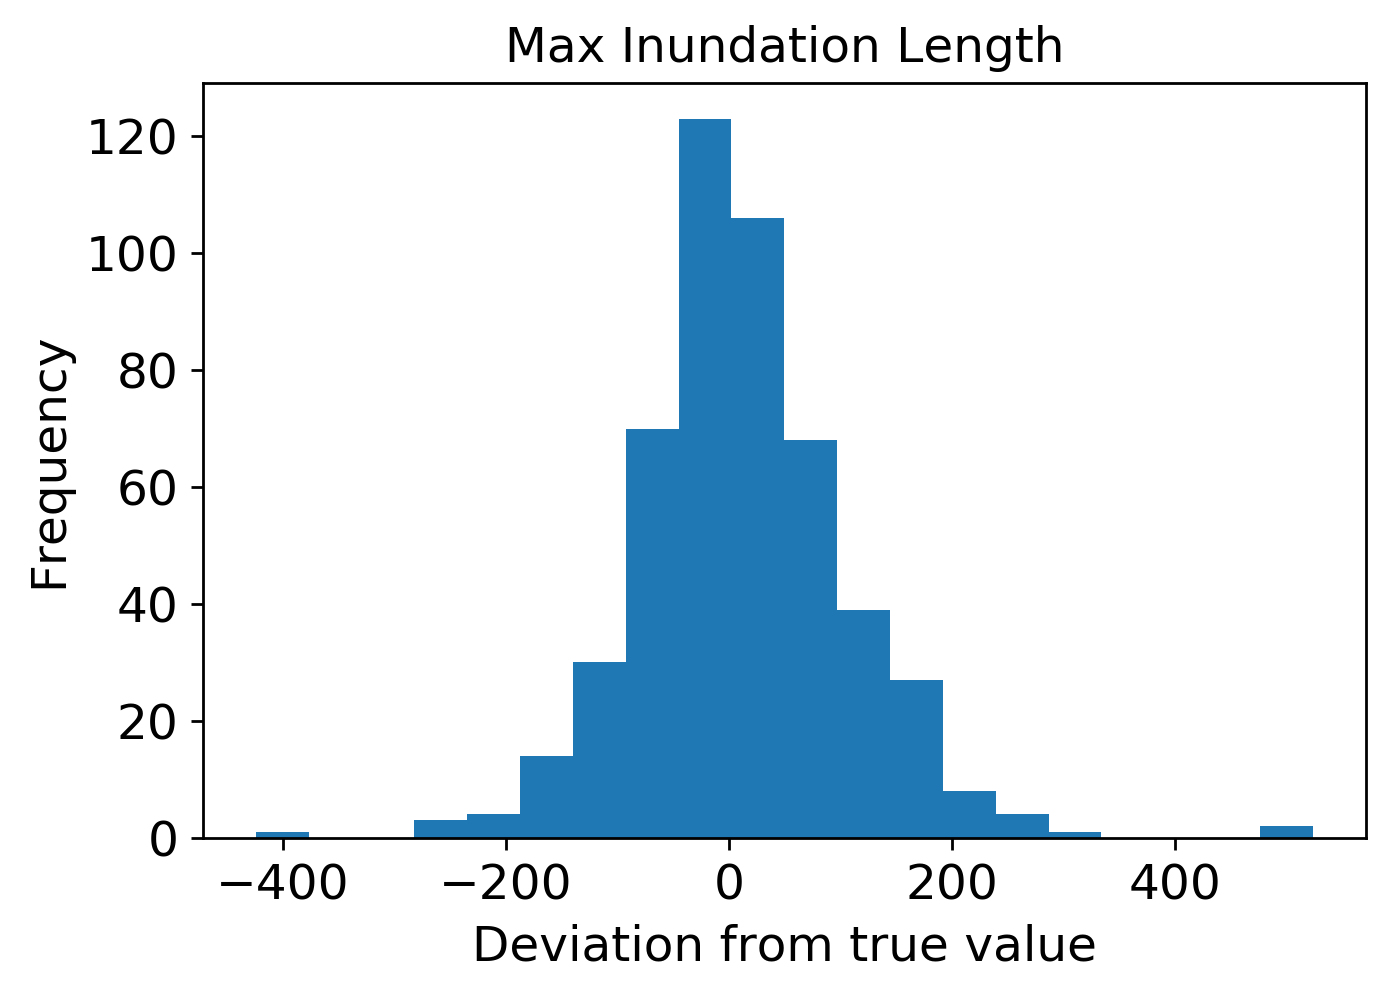

Standard Deviation sample: 0.30042874218935367
Mean: 0.14374991098856446
mode ModeResult(mode=array([-0.6783817]), count=array([1]))
m 0.13331279515799244


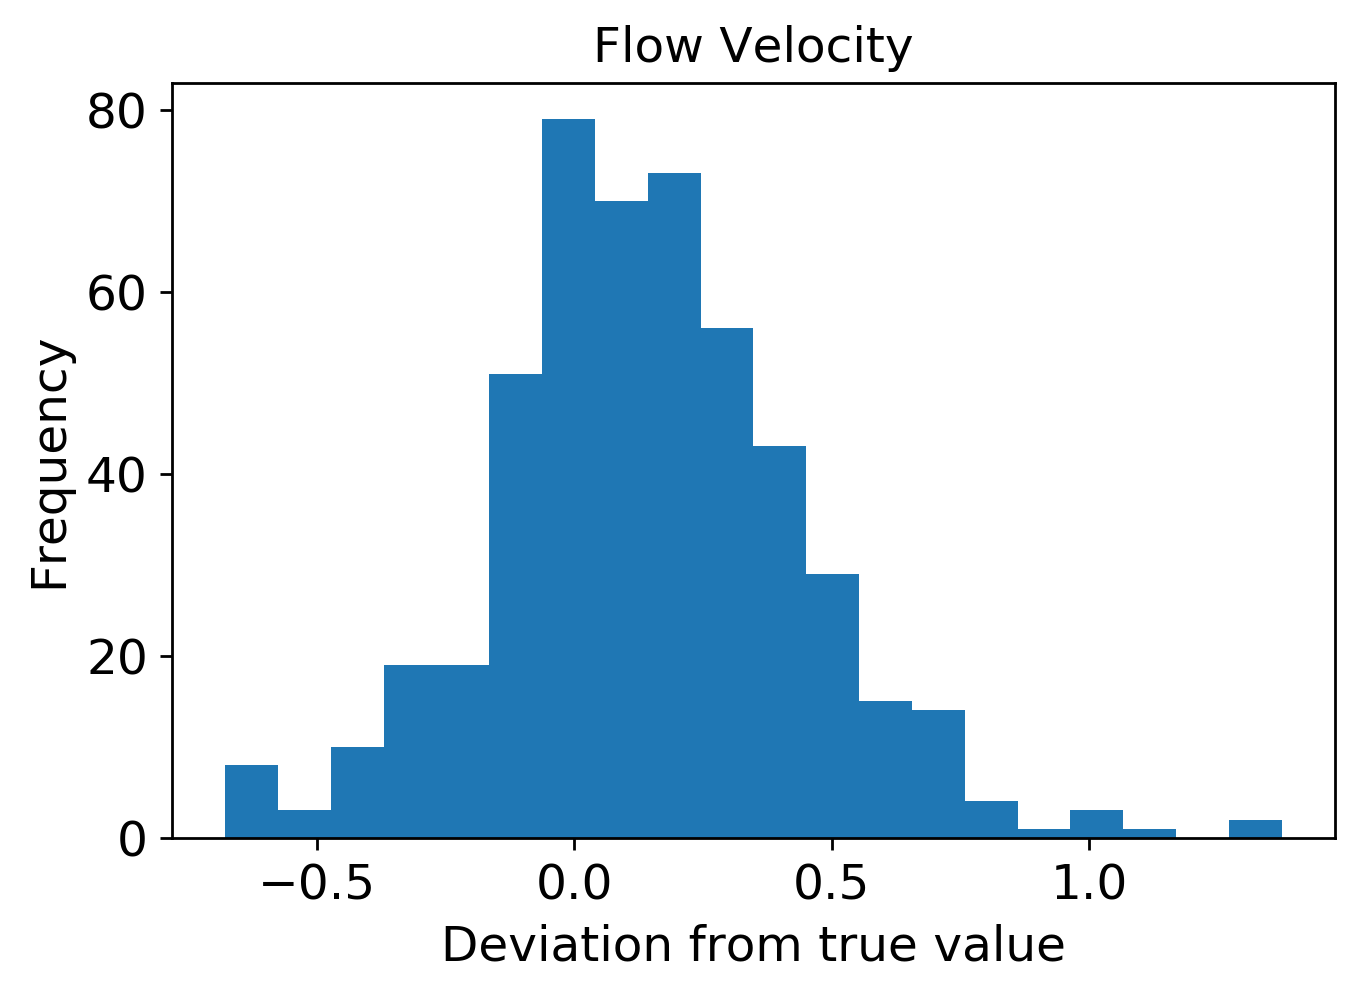

Standard Deviation sample: 0.3798222009616888
Mean: -0.4396633708731241
mode ModeResult(mode=array([-2.76991885]), count=array([1]))
m -0.41296899906683704


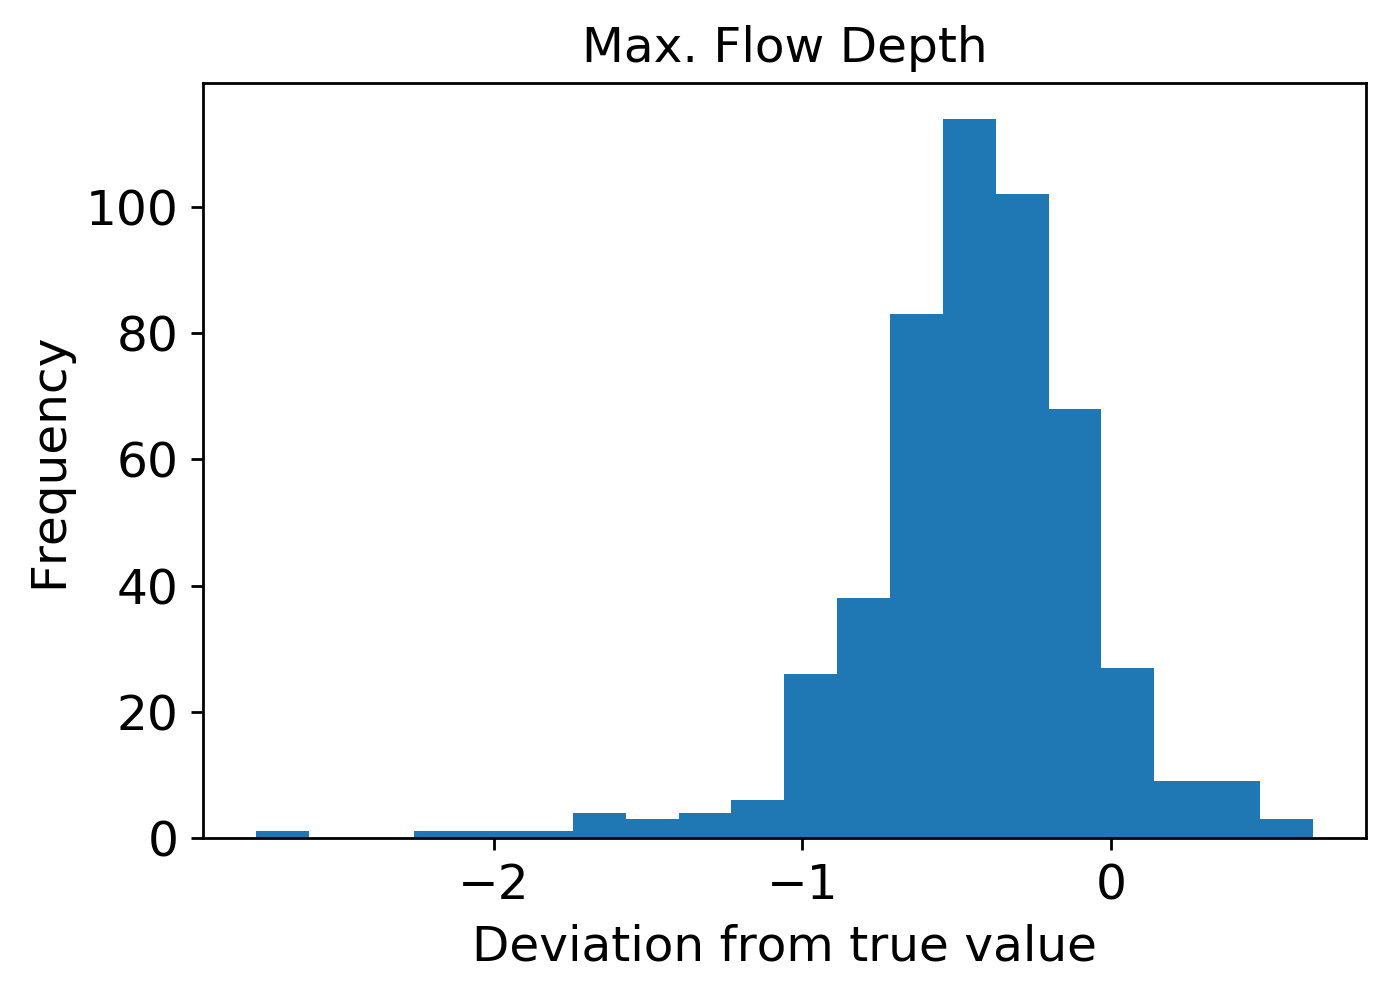

Standard Deviation sample: 0.0007759786344954231
Mean: 0.00017438023478807247
mode ModeResult(mode=array([-0.00217785]), count=array([1]))
m 0.00010714991913968446


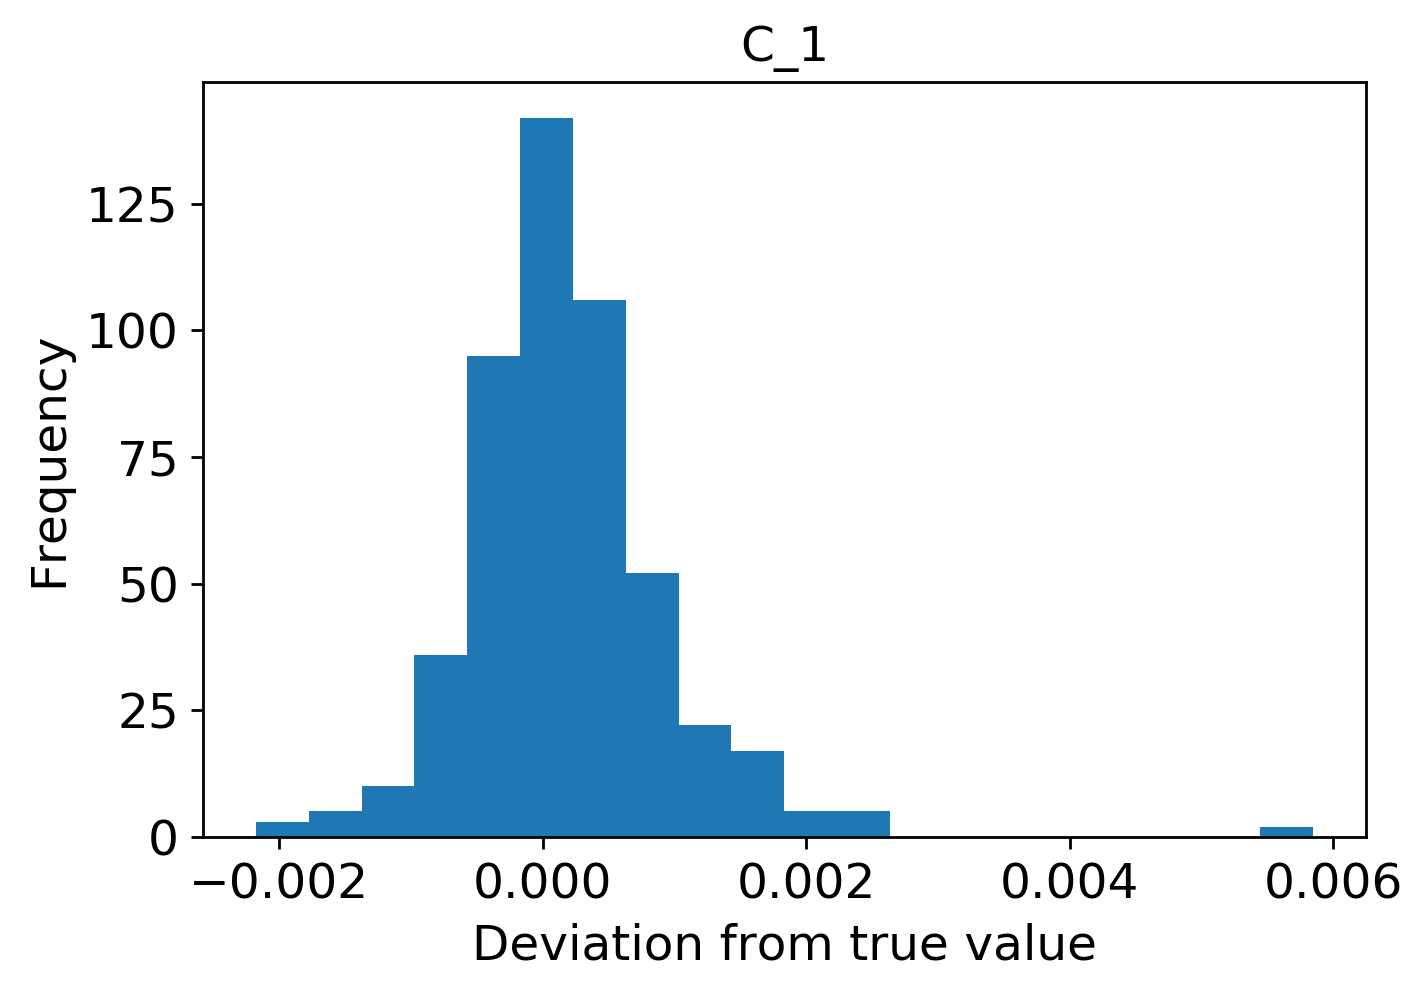

Standard Deviation sample: 0.0005615635178294363
Mean: 8.669206295685833e-05
mode ModeResult(mode=array([-0.0017855]), count=array([1]))
m 3.653126646067147e-05


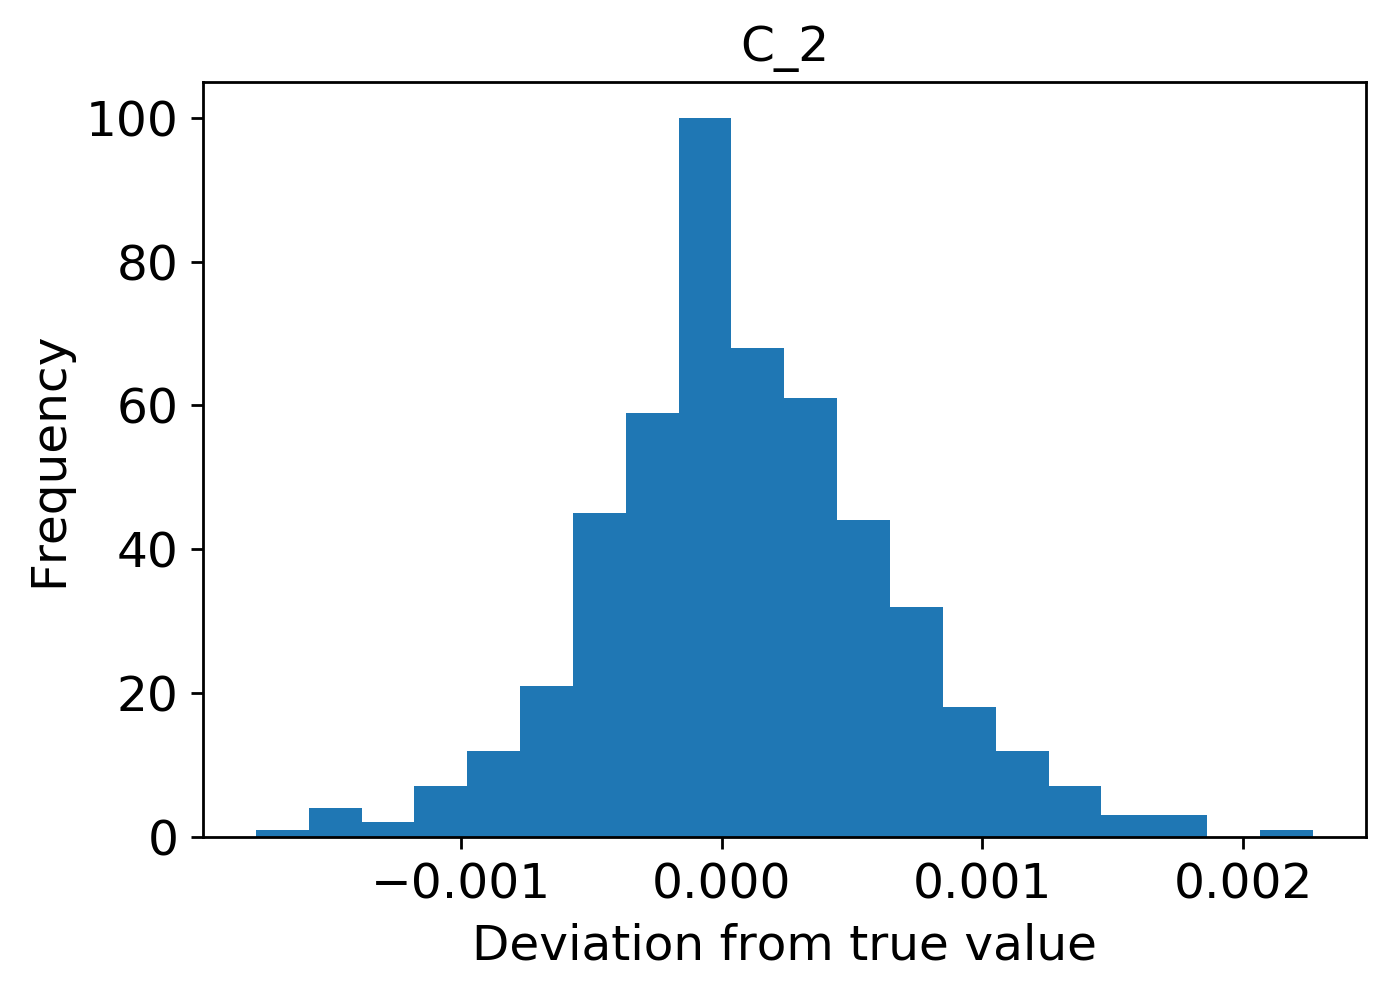

Standard Deviation sample: 0.0006318142911327215
Mean: -2.751205616936085e-06
mode ModeResult(mode=array([-0.00195719]), count=array([1]))
m -4.8493192005724835e-05


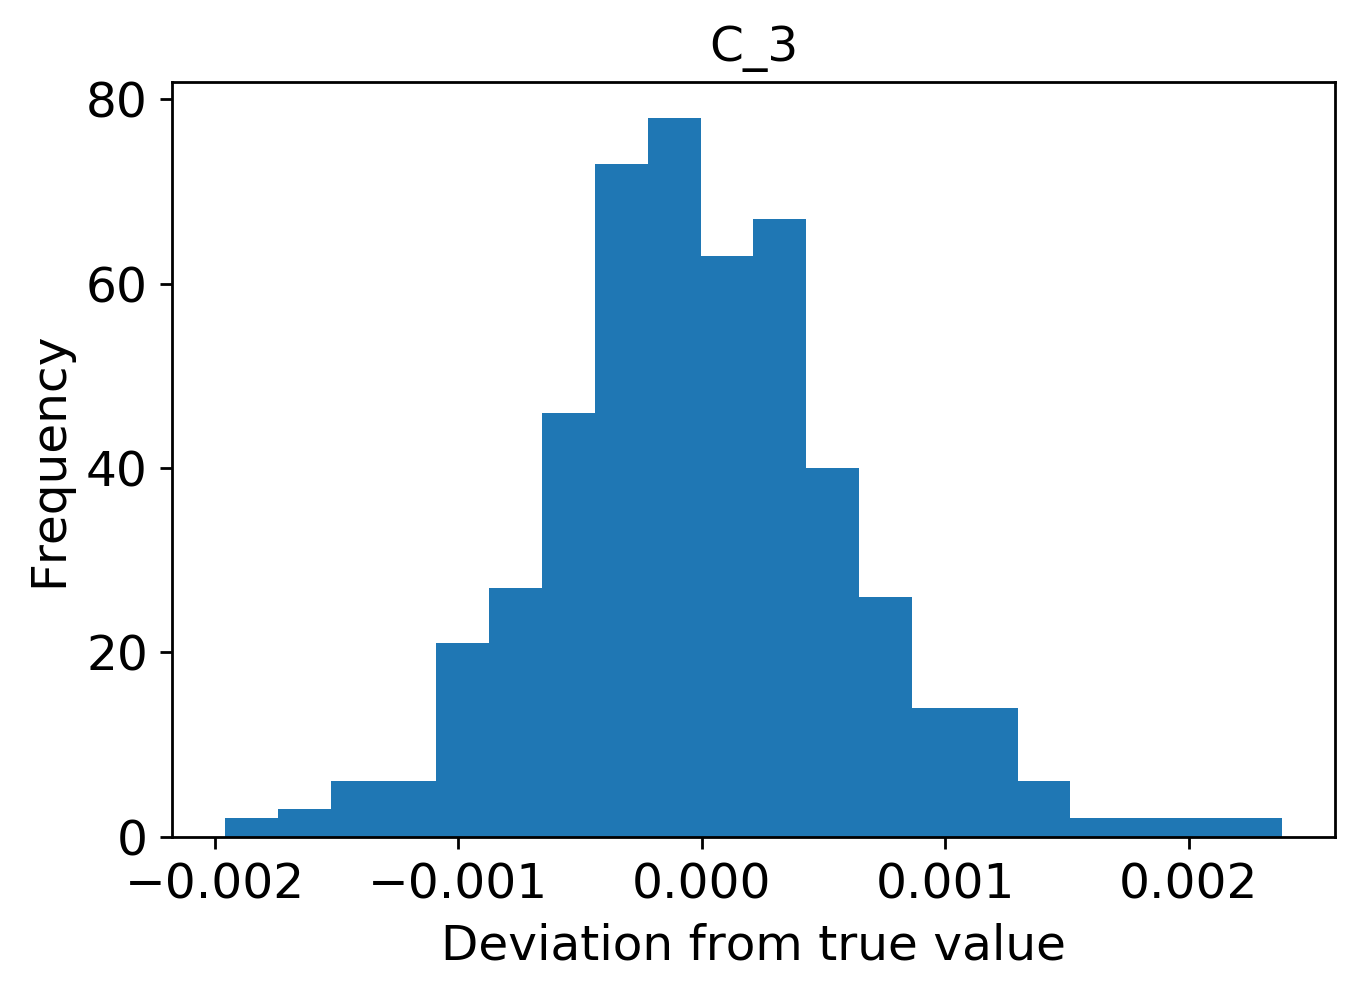

Standard Deviation sample: 0.0006411556691865046
Mean: 6.959635785408159e-05
mode ModeResult(mode=array([-0.00174265]), count=array([1]))
m -2.693748397136742e-05


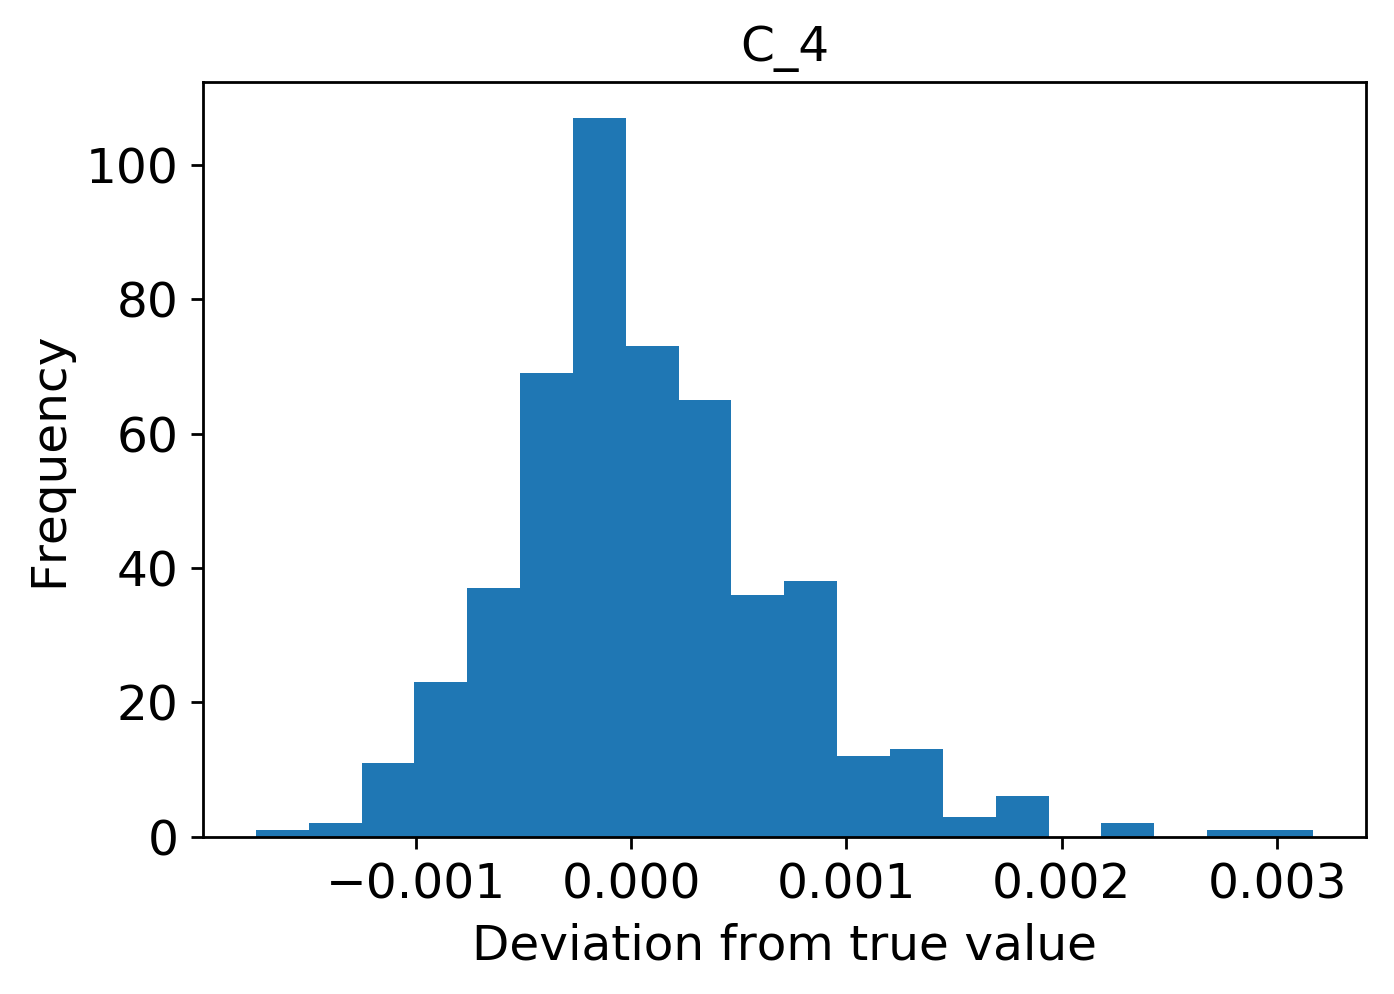

Standard Deviation sample: 0.0006224159772555257
Mean: 8.701643961925226e-05
mode ModeResult(mode=array([-0.00198271]), count=array([1]))
m 3.406903087421059e-05


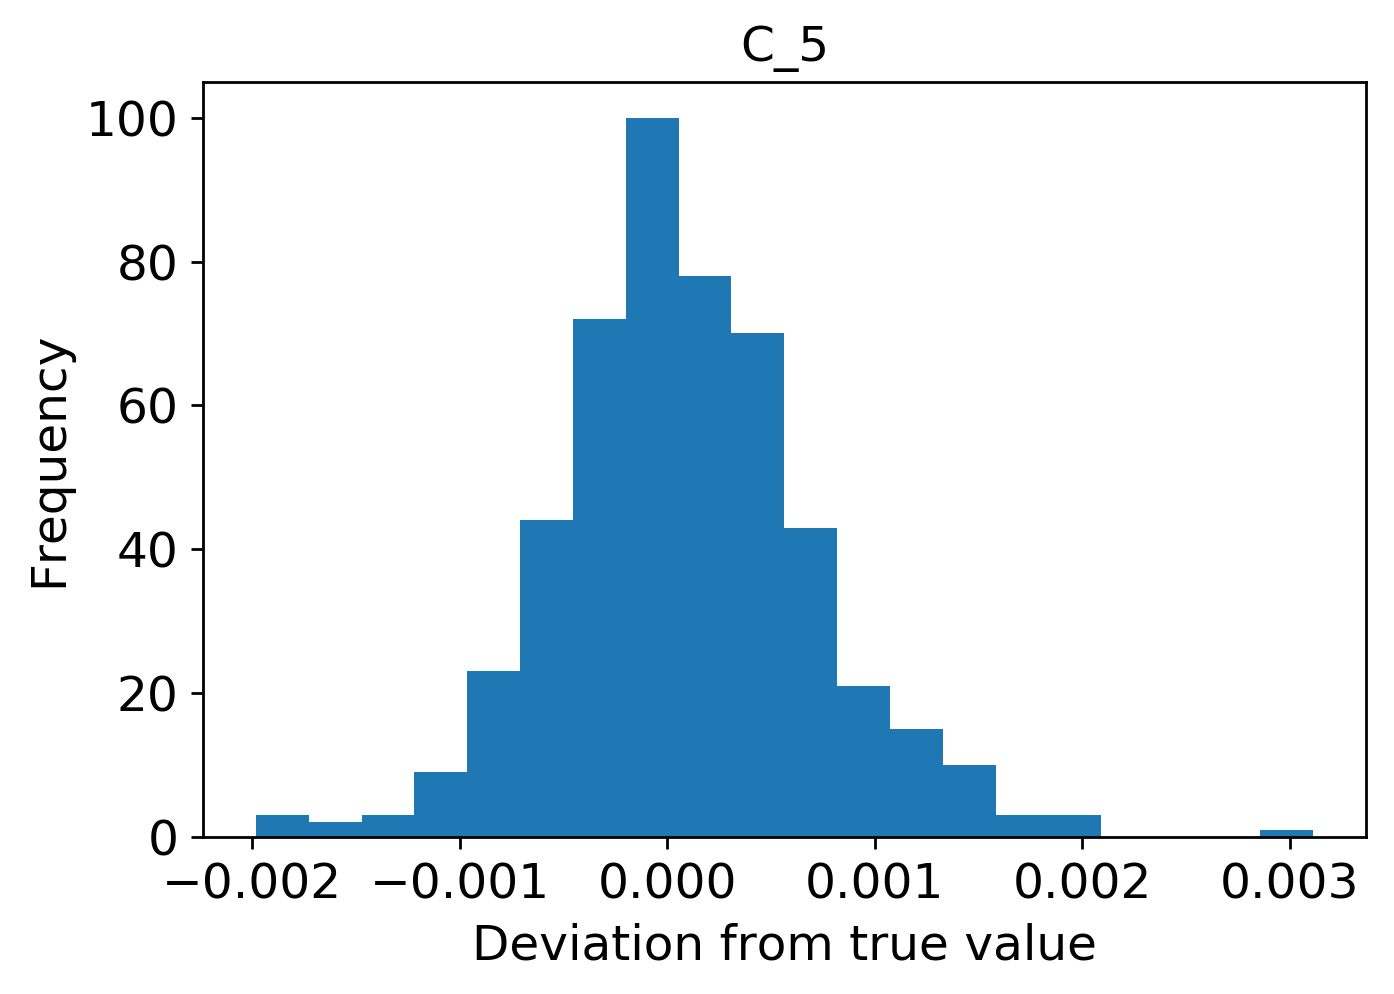

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb
from scipy import stats


#import ipdb
#ipdb.set_trace()

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1700_thai_revised_1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1700_thai_revised_1/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')

# Load test datasets
X_test = np.loadtxt(datadir + 'x_test.txt',delimiter=',')
y_test = np.loadtxt(datadir + 'icond_test.txt',delimiter=',')


# Normalize the test datasets
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
X_test_norm =  (X_test - min_x) / (max_x - min_x)


#gclass = 3
#gclass_label = ["500 $\mu$m","125 $\mu$m","63 $\mu$m"]
gclass = 5
#gclass_label = ["615 ${\mu}m$","406 ${\mu}m$","268 ${\mu}m$","177 ${\mu}m$", "117 ${\mu}m$","77 ${\mu}m$"]
gclass_label = ["726 ${\mu}m$","364 ${\mu}m$","182 ${\mu}m$","91 ${\mu}m$","46 ${\mu}m$"]

topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

# Load outcrop data
outcrop = pd.read_csv('../Journal_2/Thai_gs5_revised_1.csv')
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
outcrop_num = len(outcrop['distance'])
print(outcrop)

#Preparation under interpolation
thick_interp_at_outcrop = np.zeros([X_test.shape[0],outcrop_num*gclass])
thick_interp = np.zeros([X_test.shape[0],coord_num*gclass])#Interpolated sample thickness data
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #Index number of sampling point in inverse analysis system
x = np.arange(0,coord_num*topodx,topodx)

# Interpolation of test datasets at the outcrop locations
for i in range(X_test.shape[0]):
    for j in range(gclass):
        #f = interp1d(x,np.log10(X_test_norm[i,j * coord_num : (j+1) * coord_num]), kind="cubic",bounds_error=False,fill_value='extrapolate')
        f= interp1d(x,X_test_norm[i,j * coord_num : (j+1) * coord_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp_at_outcrop[i,outcrop_num*j:outcrop_num*(j+1)] = f(outcrop['distance']) #Supplemented data

    # Interpolation of test datasets at the grids of the forward model
    for j in range(gclass):
        #f = interp1d(outcrop['distance'],np.log10(thick_interp_at_outcrop[i,j * outcrop_num : (j+1) * outcrop_num]), kind="cubic",bounds_error=False,fill_value='extrapolate')
        f = interp1d(outcrop['distance'],thick_interp_at_outcrop[i,j * outcrop_num : (j+1) * outcrop_num], kind="cubic",bounds_error=False,fill_value='extrapolate')
        thick_interp[i,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data
    
#ipdb.set_trace()
#Kriging Interpolation by
#vparams = np.array([[0.035, 10000., 0.001],[0.006, 10000., 0.002],[0.005, 10000., 0.002],[0.035, 10000., 0.001]])
#for j in range(gclass):
    #okip = OK(outcrop['distance'],np.zeros(outcrop['distance'].shape),outcrop.iloc[:,j+1],variogram_model='linear',)
    #okip.display_variogram_model()
    #ipdata, ipstd = okip.execute('grid',x,np.array([0.]))
    #ipdata = np.squeeze(ipdata)
    #thick_interp[0,coord_num*j:coord_num*(j+1)] = ipdata #Assign complemented d

#Normalize data
thick_interp[thick_interp < 0] = 0

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
np.savetxt('outcrop_location_interp.txt',test_result_outcrop, delimiter=',')
test_result=np.loadtxt('outcrop_location_interp.txt', delimiter=',')
test_result_normal = np.loadtxt(resdir + 'test_result.txt',delimiter=',')
resi=test_result-y_test
titlelabel = ['Max Inundation Length','Flow Velocity', 'Max. Flow Depth', 'C_1', 'C_2', 'C_3', 'C_4','C_5']
hfont = {'fontname':'Century Gothic'}
textcol = 'k'
xymin=[1700,2.0,1.5,0.0001,0.0001,0.0001,0.0001,0.0001]
xymax=[4500,10.0,12.0,0.02,0.02,0.02,0.02,0.02]
xstep=[500,1.5,1.5,0.005,0.005,0.005,0.005,0.005]
stepmin=[1700,1.0,2.0,0.000,0.0000,0.0000,0.0000,0.0000]
stepmax=[4550,10.5,13.0,0.025,0.025,0.025,0.025,0.025]

# Plot curve fitting
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)], label='estimated')
for j in range(gclass):
    plt.plot(x,X_test_norm[0,j * coord_num : (j+1) * coord_num],'o',label='test')
    #plt.plot(outcrop['distance'], thick_interp_at_outcrop[0,outcrop_num*j:outcrop_num*(j+1)],'o',label='test')
plt.plot()
plt.legend()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.plot(y_test[:,i],test_result[:,i],"o", markersize=4.5)
    plt.plot(y_test[:,i],test_result_normal[:,i],"*",label='estimate',markersize=3.5)
    x=y_test[:,i]
    y=test_result[:,i]
    y2= test_result_normal[:, i]
    max_value = np.max([x, y, y2])
    min_value = np.min([x, y, y2])
    y_lim = plt.ylim([min_value * 0.8, max_value * 1.1])
    x_lim = plt.xlim([min_value * 0.8, max_value * 1.1])
    plt.plot(x_lim, y_lim, 'k-', color = 'k')
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('True values',color=textcol,size=14,**hfont)
    plt.ylabel('Estimated values',color=textcol,size=14,**hfont)
    plt.legend()
    plt.axes().set_aspect('equal')
    plt.xticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    plt.yticks(np.arange(stepmin[i],stepmax[i], step=xstep[i]))
    #plt.plot(x_lim, y_lim, color = 'k')
    plt.tick_params(labelsize=14,colors='k')
    plt.savefig(resdir+titlelabel[i] + 'outcrop_location' + '.pdf')
    plt.show()

for i in range(len(titlelabel)):
    plt.figure(num=None,dpi=250, facecolor='w', edgecolor='k')
    plt.hist(resi[:,i],bins=20)
    print('Standard Deviation sample:', np.std(resi[:,i],ddof=1))
    print('Mean:', np.mean(resi[:,i]))
    print('mode',stats.mode(resi[:,i]))
    print('m',np.median(resi[:,i]))
    plt.title(titlelabel[i],color=textcol,size=14,**hfont)
    plt.xlabel('Deviation from true value',color=textcol,size=14,**hfont)
    plt.ylabel('Frequency',color=textcol,size=14,**hfont)
    plt.tick_params(labelsize=14,colors=textcol)
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_location' + '.eps')
    plt.savefig(resdir+titlelabel[i] + 'hist_outcrop_location' + '.pdf')
    plt.show()

       distance       726       364       182        91        46
0      0.000000  0.010399  0.029123  0.021142  0.006882  0.000455
1     51.415414  0.004638  0.010623  0.016518  0.016240  0.001981
2    101.541184  0.019090  0.033383  0.021191  0.015271  0.002038
3    132.877704  0.014846  0.036879  0.038916  0.028934  0.003380
4    178.349564  0.000897  0.004421  0.032821  0.048209  0.008753
5    235.252102  0.000248  0.000710  0.009960  0.015168  0.001914
6    267.154762  0.023041  0.013593  0.010173  0.017016  0.003069
7    296.463078  0.012222  0.011268  0.008694  0.012747  0.002035
8    344.938070  0.004596  0.009952  0.017344  0.020869  0.003623
9    414.104500  0.002789  0.004262  0.019079  0.031537  0.006802
10   458.884217  0.000450  0.000735  0.006082  0.009064  0.001527
11   491.715389  0.006784  0.018716  0.026314  0.023898  0.003289
12   525.944070  0.000312  0.000670  0.008444  0.013288  0.002287
13   607.657771  0.006453  0.015906  0.031496  0.038024  0.007074
14   673.2

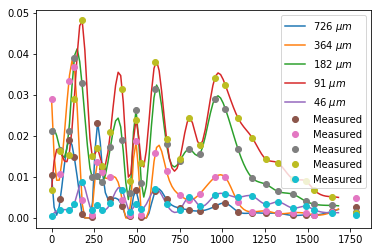

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from scipy import stats
from scipy.interpolate import interp1d 
import pandas as pd
from pykrige import OrdinaryKriging as OK
import ipdb


datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1700_thai_revised_1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1700_thai_revised_1/5000/'
#Initial setting
if not "model" in locals(): 
    model = load_model(resdir+'model3.hdf5')

gclass = 5
gclass_label = ["726 ${\mu}m$","364 ${\mu}m$","182 ${\mu}m$","91 ${\mu}m$","46 ${\mu}m$"]
gclass_name=['726','364','182','91','46']
topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)

#Acquires a value for normalizing input data to [0, 1]
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt',delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt',delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt',delimiter=',')

#Read outcrop data
#dist_max = 21700. #Distance of distal end of learning data
outcrop = pd.read_csv('../Journal_2/Thai_gs5_revised_1.csv')
#outcrop = pd.read_csv('../DeepLearningTurbidite_Fukuda/GA_naruse_v2.csv')
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0],[dist_max,'LocE',0,0,0]], columns=outcrop.columns))
outcrop = outcrop.sort_values('distance')
outcrop['distance'] = outcrop['distance'] - 0
#d = pd.DataFrame(np.zeros((1, 7)),columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#print(d)
#v=np.concatenate((outcrop, d))
#print(v)
#outcrop=pd.DataFrame(v,columns=['distance', 'g1','g2','g3','g4','g5','g6'])
#outcrop['distance'].iloc[-1]=4000
#outcrop = outcrop.append(pd.DataFrame([[0,'Loc0',0,0,0,0]], columns=outcrop.columns))
print(outcrop)

#Preparation under interpolation
thick_interp = np.zeros([1,coord_num*gclass])#補間されたサンプル厚さデータ
outcrop_x_id = np.round(outcrop['distance']/topodx).astype(np.int32) #逆解析システムでのサンプリング地点のindex番号
x = np.arange(0,coord_num*topodx,topodx)

#Complement data
for j in range(gclass):
    f = interp1d(outcrop['distance'],outcrop.iloc[:,j+1], kind="cubic",bounds_error=False,fill_value='extrapolate')
    #f = interp1d(outcrop['distance'],outcrop.iloc[:,j+2], kind="linear",bounds_error=False,fill_value='extrapolate') 
    #Interpolation function of jth granularity level
    thick_interp[0,coord_num*j:coord_num*(j+1)] = f(x) #Supplemented data

#ipdb.set_trace()
#Kriging Interpolation by
#vparams = np.array([[0.035, 10000., 0.001],[0.006, 10000., 0.002],[0.005, 10000., 0.002],[0.035, 10000., 0.001]])
#for j in range(gclass):
    #okip = OK(outcrop['distance'],np.zeros(outcrop['distance'].shape),outcrop.iloc[:,j+1],variogram_model='linear',)
    #okip.display_variogram_model()
    #ipdata, ipstd = okip.execute('grid',x,np.array([0.]))
    #ipdata = np.squeeze(ipdata)
    #thick_interp[0,coord_num*j:coord_num*(j+1)] = ipdata #Assign complemented d

#Normalize data
thick_interp[thick_interp < 0] = 0
thick_interp_norm =  (thick_interp - min_x) / (max_x - min_x)

#Perform inverse analysis
test_result_outcrop = model.predict(thick_interp_norm)
test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
print(test_result_outcrop)
#add=np.array(3000)
#test_result_outcrop_add=np.concatenate((add,test_result_outcrop), axis=None)
#Output results
#print(test_result_outcrop_add)
np.savetxt('outcrop_result_g6_g300_j2_roi1700_thai_cubic_revised_1.txt',test_result_outcrop, delimiter=',')
for i in range(len(gclass_label)):
    plt.plot(x,thick_interp[0,coord_num * i:coord_num * (i+1)],label=gclass_label[i])
for i in range(gclass):
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')


plt.legend()
plt.show()



       distance       726       364       182        91        46
0      0.000000  0.010399  0.029123  0.021142  0.006882  0.000455
1     51.415414  0.004638  0.010623  0.016518  0.016240  0.001981
2    101.541184  0.019090  0.033383  0.021191  0.015271  0.002038
3    132.877704  0.014846  0.036879  0.038916  0.028934  0.003380
4    178.349564  0.000897  0.004421  0.032821  0.048209  0.008753
5    235.252102  0.000248  0.000710  0.009960  0.015168  0.001914
6    267.154762  0.023041  0.013593  0.010173  0.017016  0.003069
7    296.463078  0.012222  0.011268  0.008694  0.012747  0.002035
8    344.938070  0.004596  0.009952  0.017344  0.020869  0.003623
9    414.104500  0.002789  0.004262  0.019079  0.031537  0.006802
10   458.884217  0.000450  0.000735  0.006082  0.009064  0.001527
11   491.715389  0.006784  0.018716  0.026314  0.023898  0.003289
12   525.944070  0.000312  0.000670  0.008444  0.013288  0.002287
13   607.657771  0.006453  0.015906  0.031496  0.038024  0.007074
14   673.2

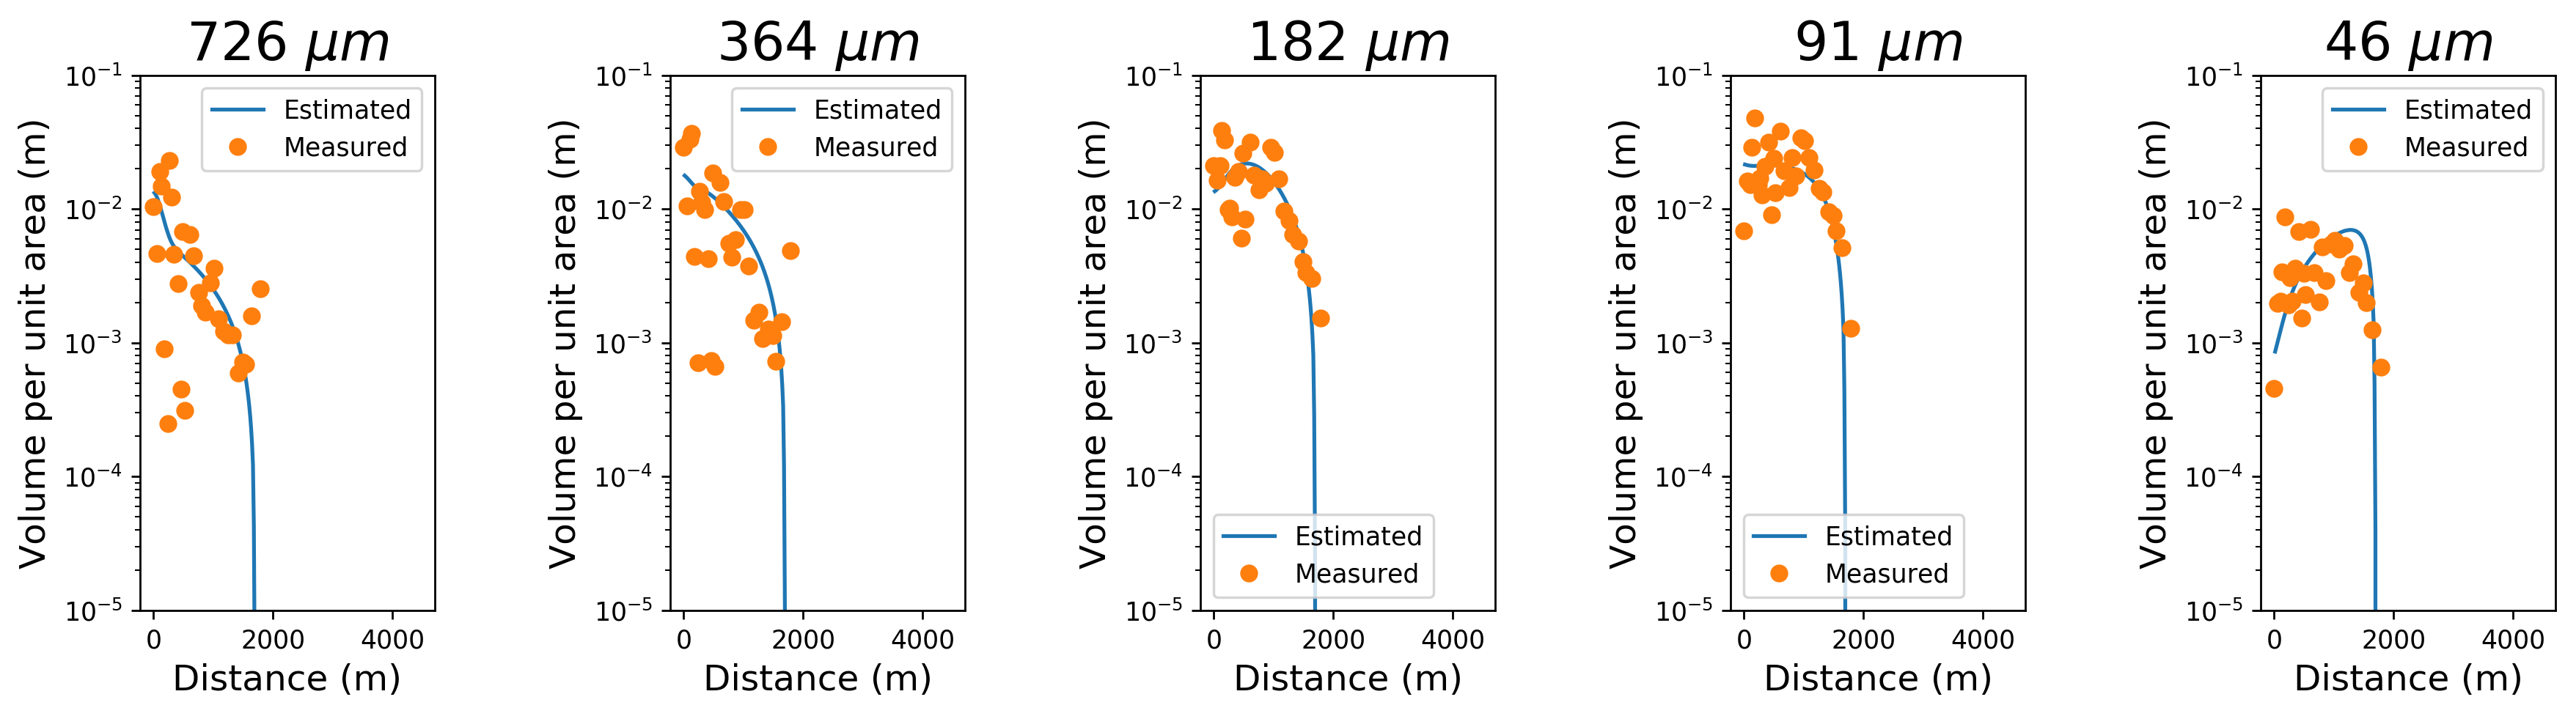

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Forward_model_for_DNN_thai_revised_1 as fmodel
import time
import ipdb
%matplotlib inline

#Basic setting

#dist_max = 3000.
gclass = 5
topodx=15.0
gclass_name = ['726','364','182','91','46']
#gclass_name = ['500micron', '125micron', '63micron']
gname_tex = ["726 ${\mu}m$","364 ${\mu}m$","182 ${\mu}m$","91 ${\mu}m$","46 ${\mu}m$"]
#gname_tex = ['500 $\mu$m','125 $\mu$m','63 $\mu$m']

estimated_icond=np.loadtxt('outcrop_result_g6_g300_j2_roi1700_thai_cubic_revised_1.txt', delimiter=',')
start = time.time()
fmodel.read_setfile("config_g5_300grid_thai_revised_1.ini")
(x,C,x_dep,deposit) = fmodel.forward(estimated_icond)
np.savetxt('eta_estimated_thickness_5K_g6_j2_roi1700_thai.csv', deposit, delimiter=',')
np.savetxt('eta_estimated_Distance_5K_g6_j2_roi1700_thai.csv', x_dep,delimiter=',')
estimated_dep_thickness_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_thickness_5K_g6_j2_roi1700_thai.csv', delimiter=','))
estimated_dep_thickness_5000=pd.DataFrame(estimated_dep_thickness_5000,columns=['726','364','182','91','46'])
estimated_dep_distance_5000=np.transpose(np.loadtxt('/home/rimali2009/Journal_2/'+'eta_estimated_Distance_5K_g6_j2_roi1700_thai.csv', delimiter=','))
estimated_dep_distance_5000=pd.DataFrame(estimated_dep_distance_5000,columns=['distance'])
estimated_dep_5000=pd.concat([estimated_dep_distance_5000,estimated_dep_thickness_5000],axis=1)
np.savetxt('estimated_dep_5K_g6_j2_roi1700_thai.csv',estimated_dep_5000,delimiter=',')
#data_estim=pd.DataFrame(estimated_dep_5000,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])

#Formatting the loaded data
#estimated_dep_df = pd.DataFrame(estimated_dep,columns=['distance','1.5phi','2.5phi','3.5phi','4.5phi'])
#estimated_dep = pd.DataFrame(np.array([x_bed - dist_offset,H1[-1,:],H2[-1,:],H3[-1,:]]).T,columns=['distance','500micron','125micron','63micron'])
estimated_dep_5000= estimated_dep_5000.query('distance > 0')
#estimated_dep_5000 = estimated_dep_5000.query('distance < {}'.format(dist_max))

#Read original data
outcrop = pd.read_csv('../Journal_2/Thai_gs5_revised_1.csv')
outcrop= pd.DataFrame(outcrop,columns=['distance','726','364','182','91','46'])
print(outcrop)

#Plot
plt.figure(num=None, figsize=(17, 4), dpi=250, facecolor='w', edgecolor='g')
hfont = {'fontname':'Sans'}
plt.subplots_adjust(bottom=0.15, wspace=0.8)

for i in range(gclass):
    plt.subplot(1,gclass,i+1)
    plt.plot(estimated_dep_5000['distance'],estimated_dep_5000[gclass_name[i]],'-', label='Estimated')
    plt.plot(outcrop['distance'], outcrop[gclass_name[i]],'o', label='Measured')
    plt.yscale('log')
    plt.ylim([0.00001,0.1])
    plt.title(gname_tex[i], size=21,**hfont)
    plt.xlabel('Distance (m)', size = 14, **hfont)
    plt.ylabel('Volume per unit area (m)', size = 14, **hfont)
    plt.legend(fontsize=10)
    plt.savefig("thickness_distance_curve_5000_g6_j2_roi1700_thai_revised_1.png")
    plt.savefig("thickness_distance_curve_5000_g6_j2_roi1700_thai_revised_1.eps")
    plt.savefig("thickness_distance_curve_5000_g6_j2_roi1700_thai_revised_1.pdf")
plt.show()

       distance       726       364       182        91       46 
0      0.000000  0.010399  0.029123  0.021142  0.006882  0.000455
1     51.415414  0.004638  0.010623  0.016518  0.016240  0.001981
2    101.541184  0.019090  0.033383  0.021191  0.015271  0.002038
3    132.877704  0.014846  0.036879  0.038916  0.028934  0.003380
4    178.349564  0.000897  0.004421  0.032821  0.048209  0.008753
5    235.252102  0.000248  0.000710  0.009960  0.015168  0.001914
6    267.154762  0.023041  0.013593  0.010173  0.017016  0.003069
7    296.463078  0.012222  0.011268  0.008694  0.012747  0.002035
8    344.938070  0.004596  0.009952  0.017344  0.020869  0.003623
9    414.104500  0.002789  0.004262  0.019079  0.031537  0.006802
10   458.884217  0.000450  0.000735  0.006082  0.009064  0.001527
11   491.715389  0.006784  0.018716  0.026314  0.023898  0.003289
12   525.944070  0.000312  0.000670  0.008444  0.013288  0.002287
13   607.657771  0.006453  0.015906  0.031496  0.038024  0.007074
14   673.2

(1, 8)
[[1.70085297e+03 4.67462943e+00 4.76434478e+00 1.70635202e-03
  2.28718107e-03 1.69577486e-03 2.74722717e-03 1.00089395e-04]]
       distance       726       364       182        91       46 
0      0.000000  0.010399  0.029123  0.021142  0.006882  0.000455
1     51.415414  0.004638  0.010623  0.016518  0.016240  0.001981
2    101.541184  0.019090  0.033383  0.021191  0.015271  0.002038
3    132.877704  0.014846  0.036879  0.038916  0.028934  0.003380
4    178.349564  0.000897  0.004421  0.032821  0.048209  0.008753
5    235.252102  0.000248  0.000710  0.009960  0.015168  0.001914
6    267.154762  0.023041  0.013593  0.010173  0.017016  0.003069
7    296.463078  0.012222  0.011268  0.008694  0.012747  0.002035
8    344.938070  0.004596  0.009952  0.017344  0.020869  0.003623
9    414.104500  0.002789  0.004262  0.019079  0.031537  0.006802
10   458.884217  0.000450  0.000735  0.006082  0.009064  0.001527
11   491.715389  0.006784  0.018716  0.026314  0.023898  0.003289
12   525.

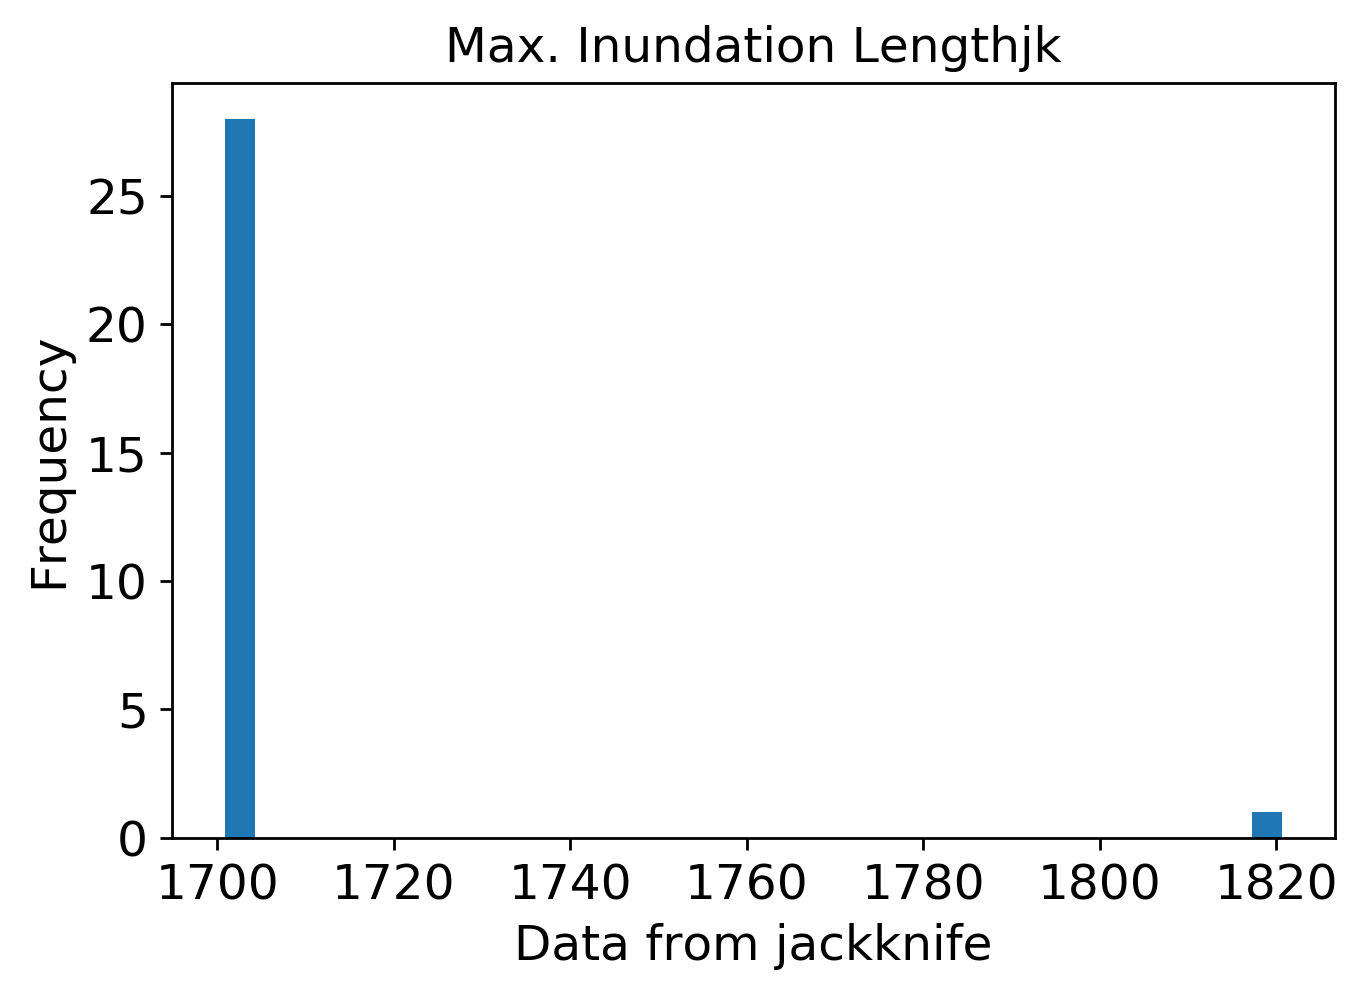

mean: 4.609084574267778
jk_e: 0.10589433693263321
CI 0.2075529003879611


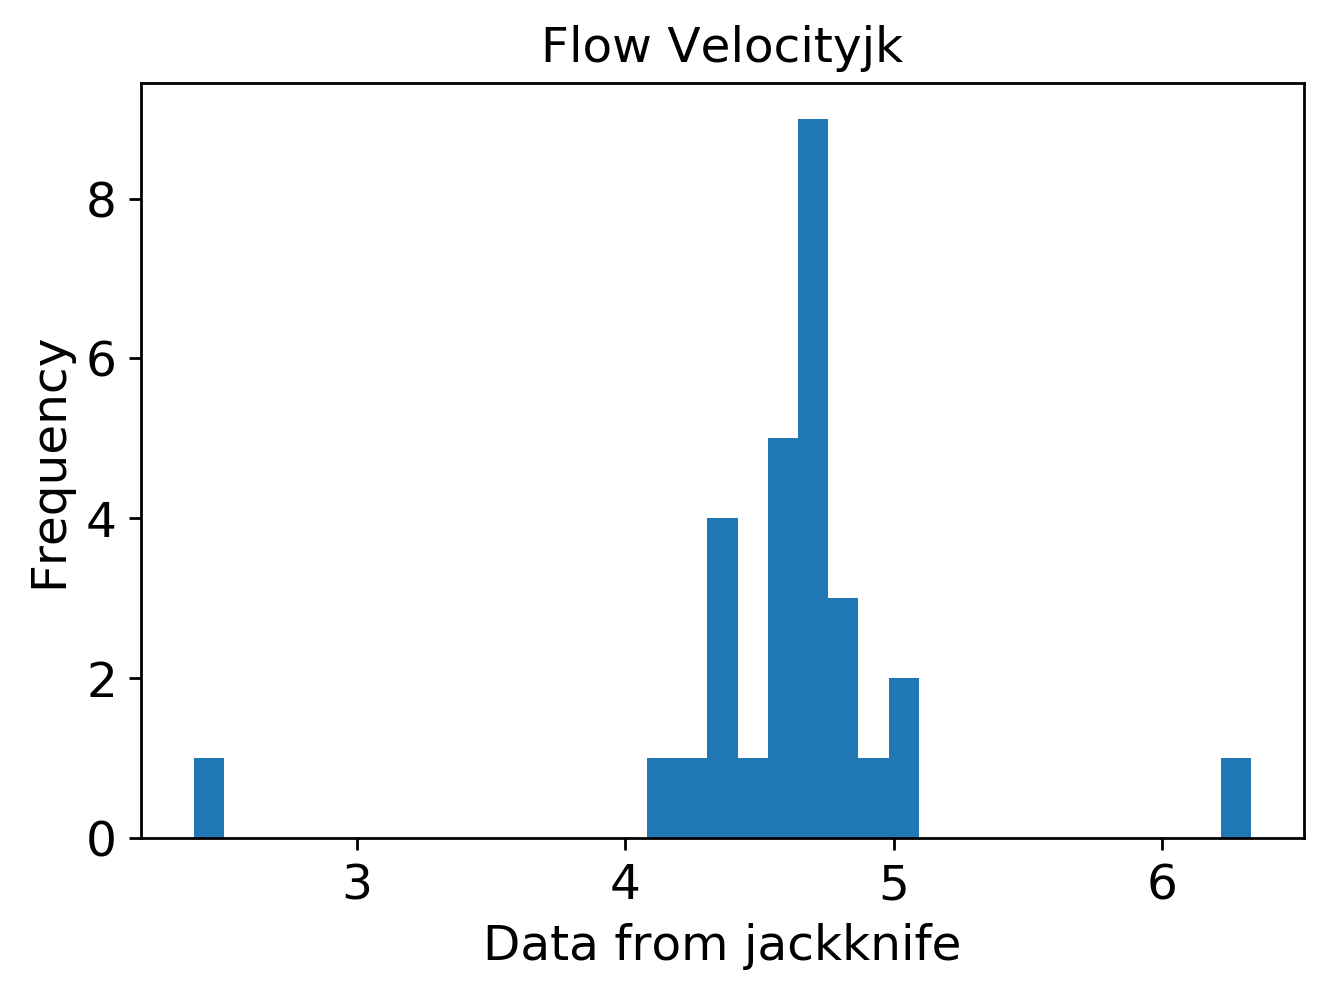

mean: 4.915716453873927
jk_e: 0.12985515008838974
CI 0.2545160941732439


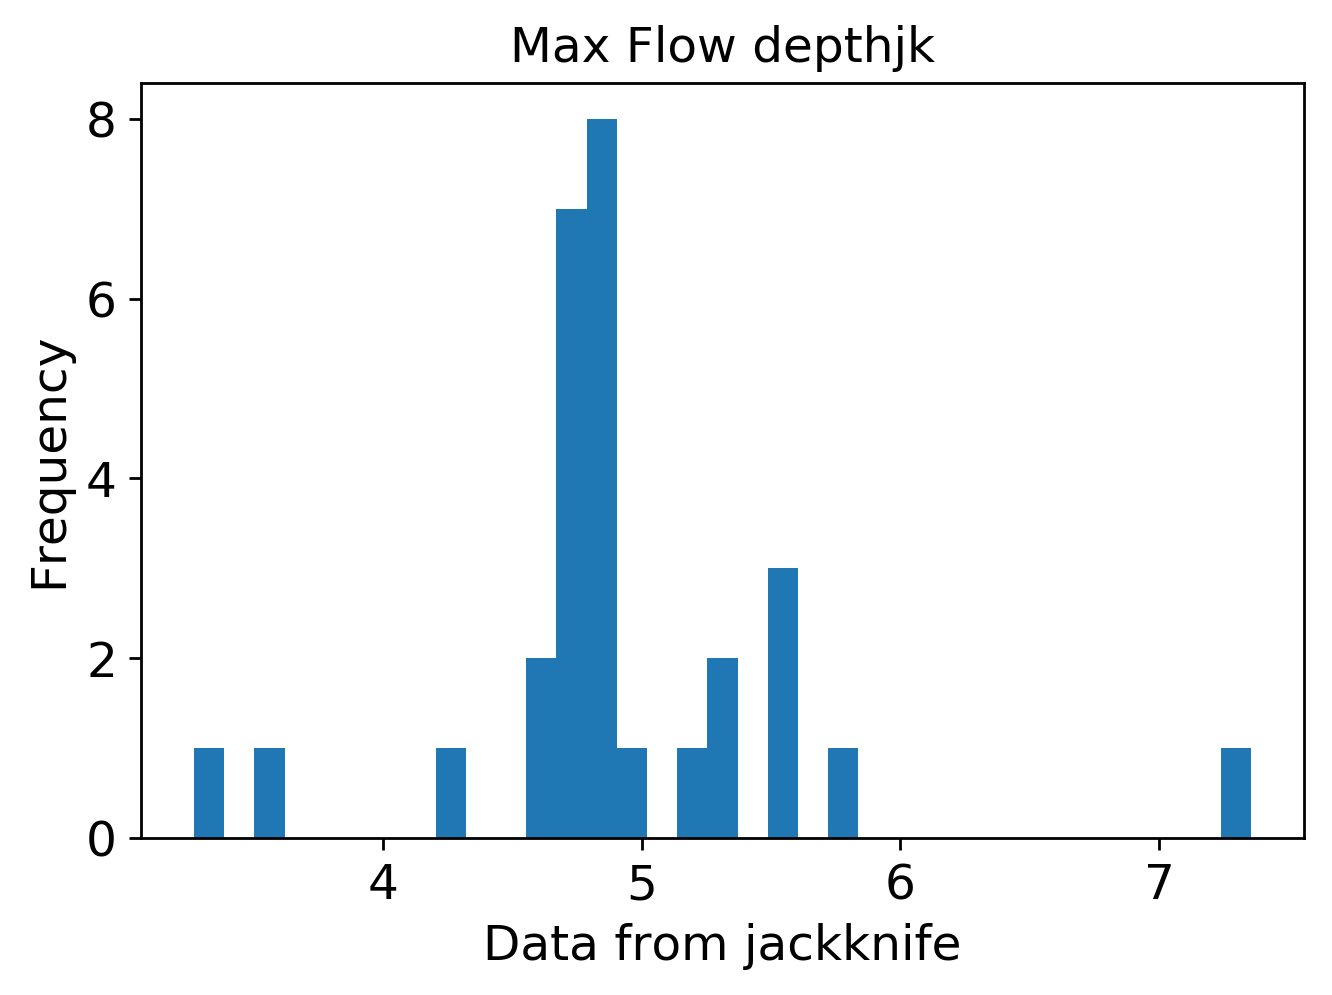

mean: 0.0016887938454381215
jk_e: 9.072078344426682e-05
CI 0.00017781273555076297


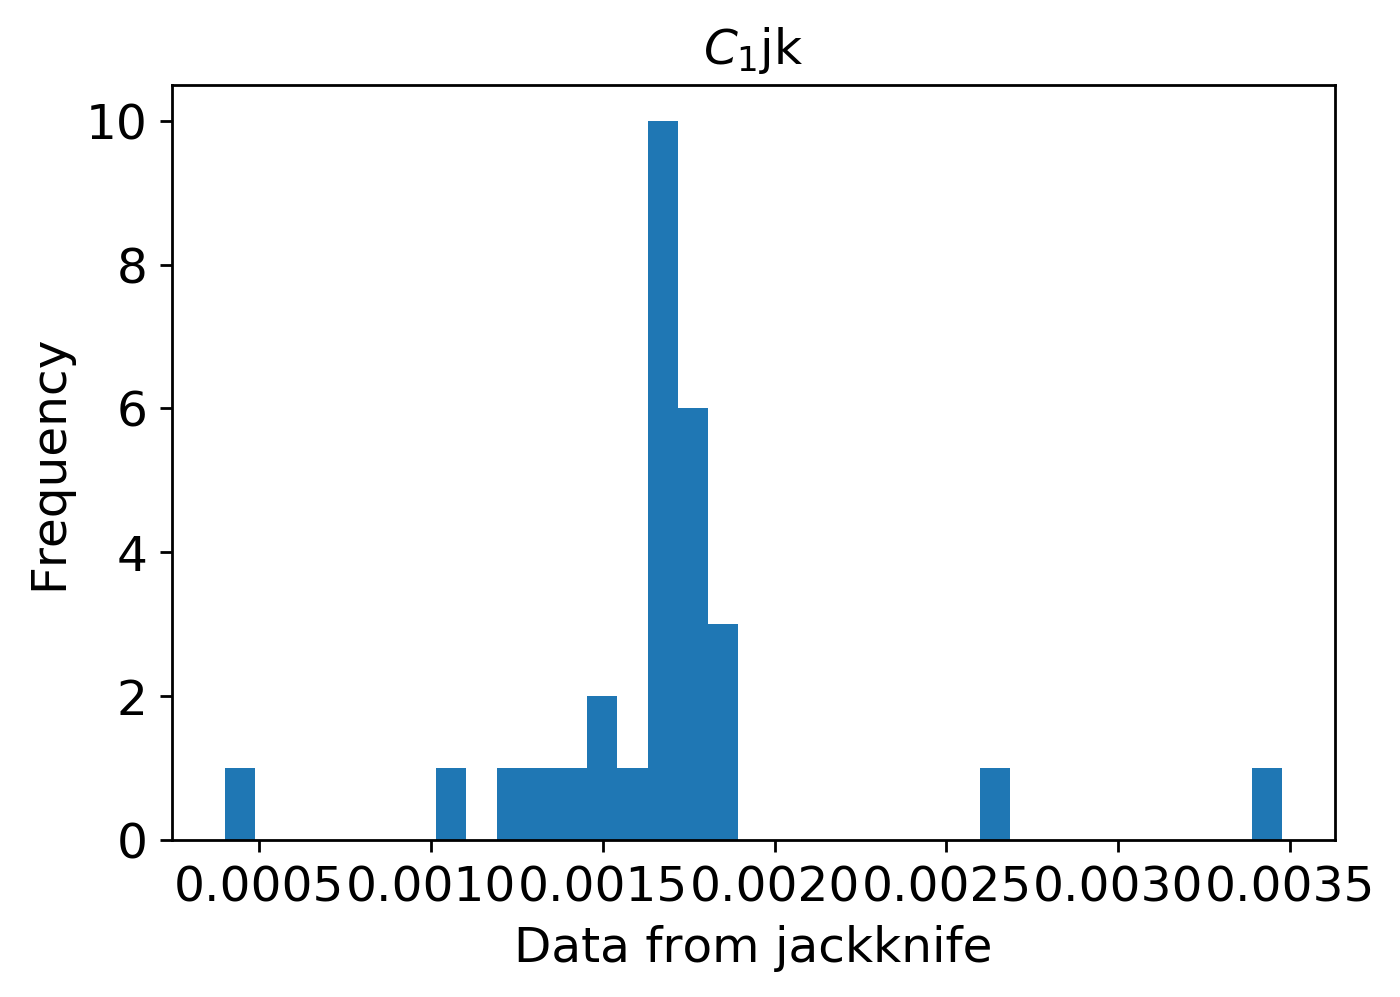

mean: 0.002296449555567366
jk_e: 8.529794699084461e-05
CI 0.00016718397610205544


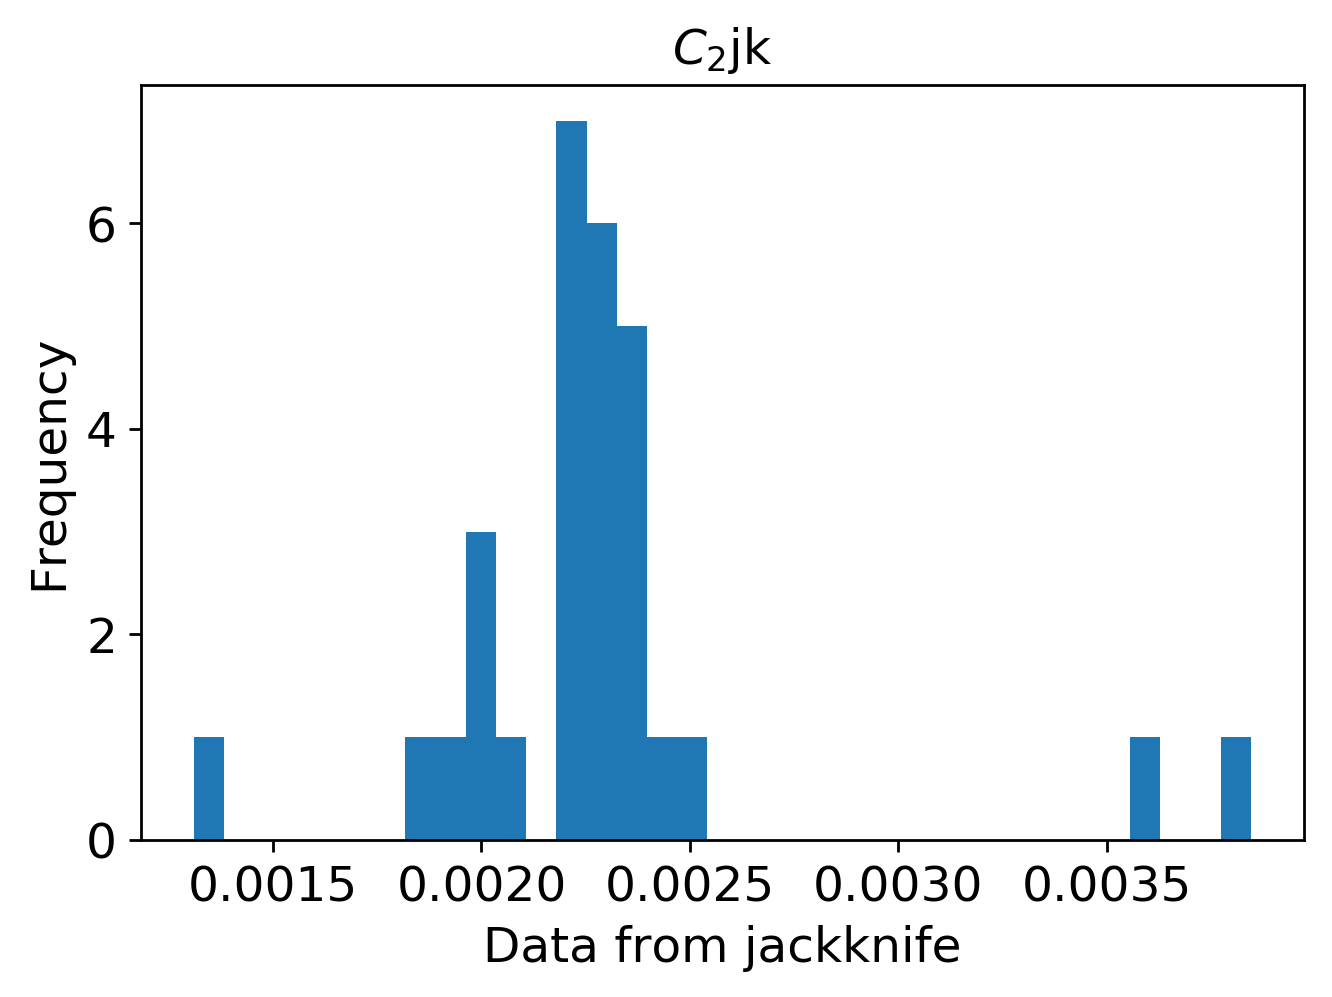

mean: 0.0017792798731598467
jk_e: 0.00016503894543400666
CI 0.00032347633305065303


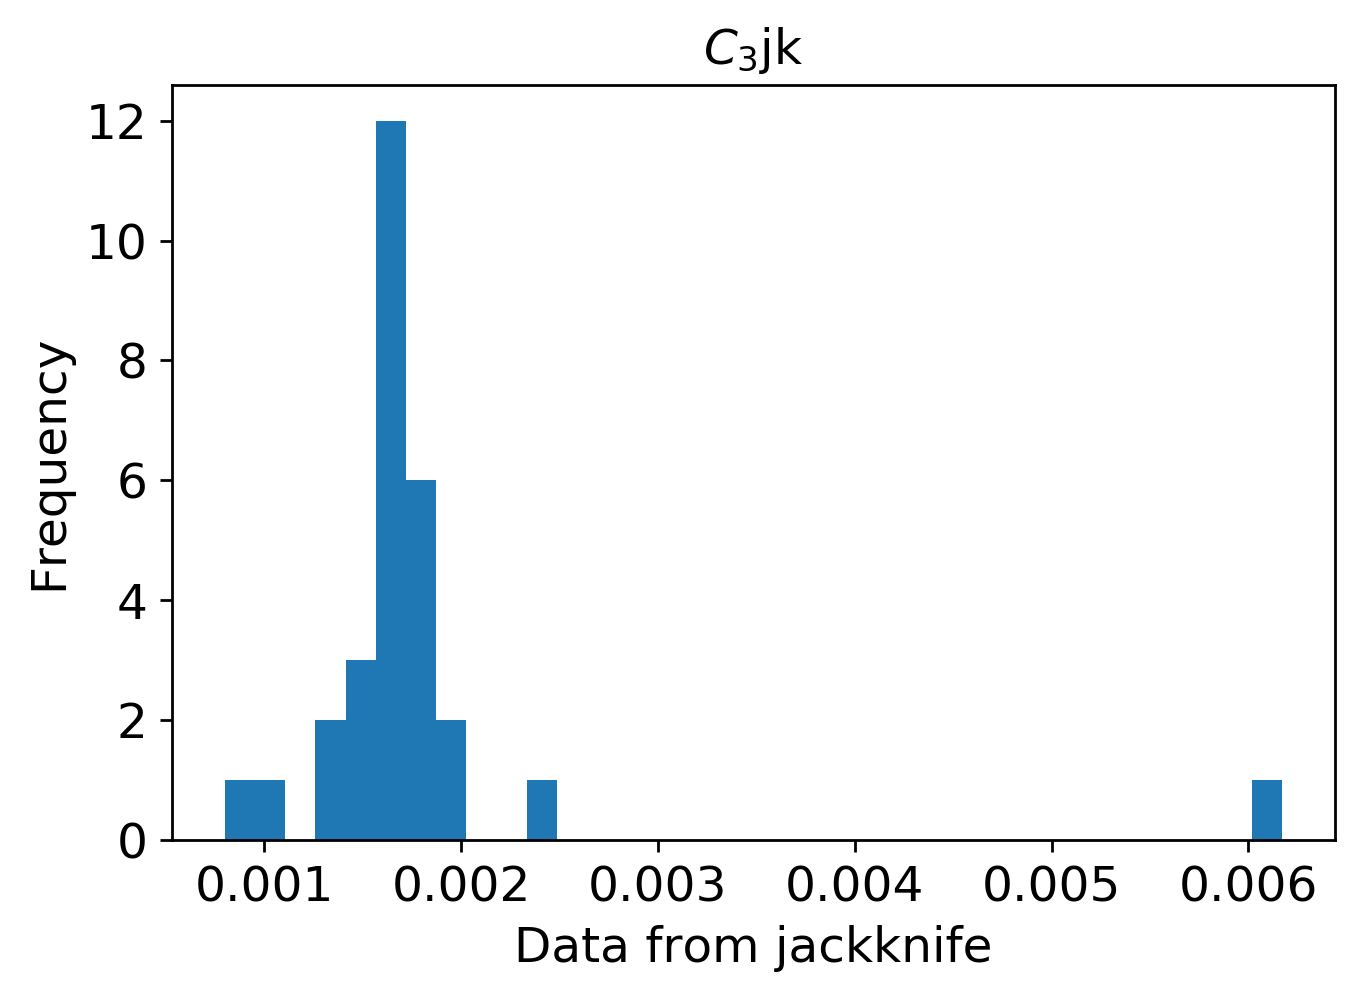

mean: 0.002696816439707401
jk_e: 5.3717981589338593e-05
CI 0.00010528724391510365


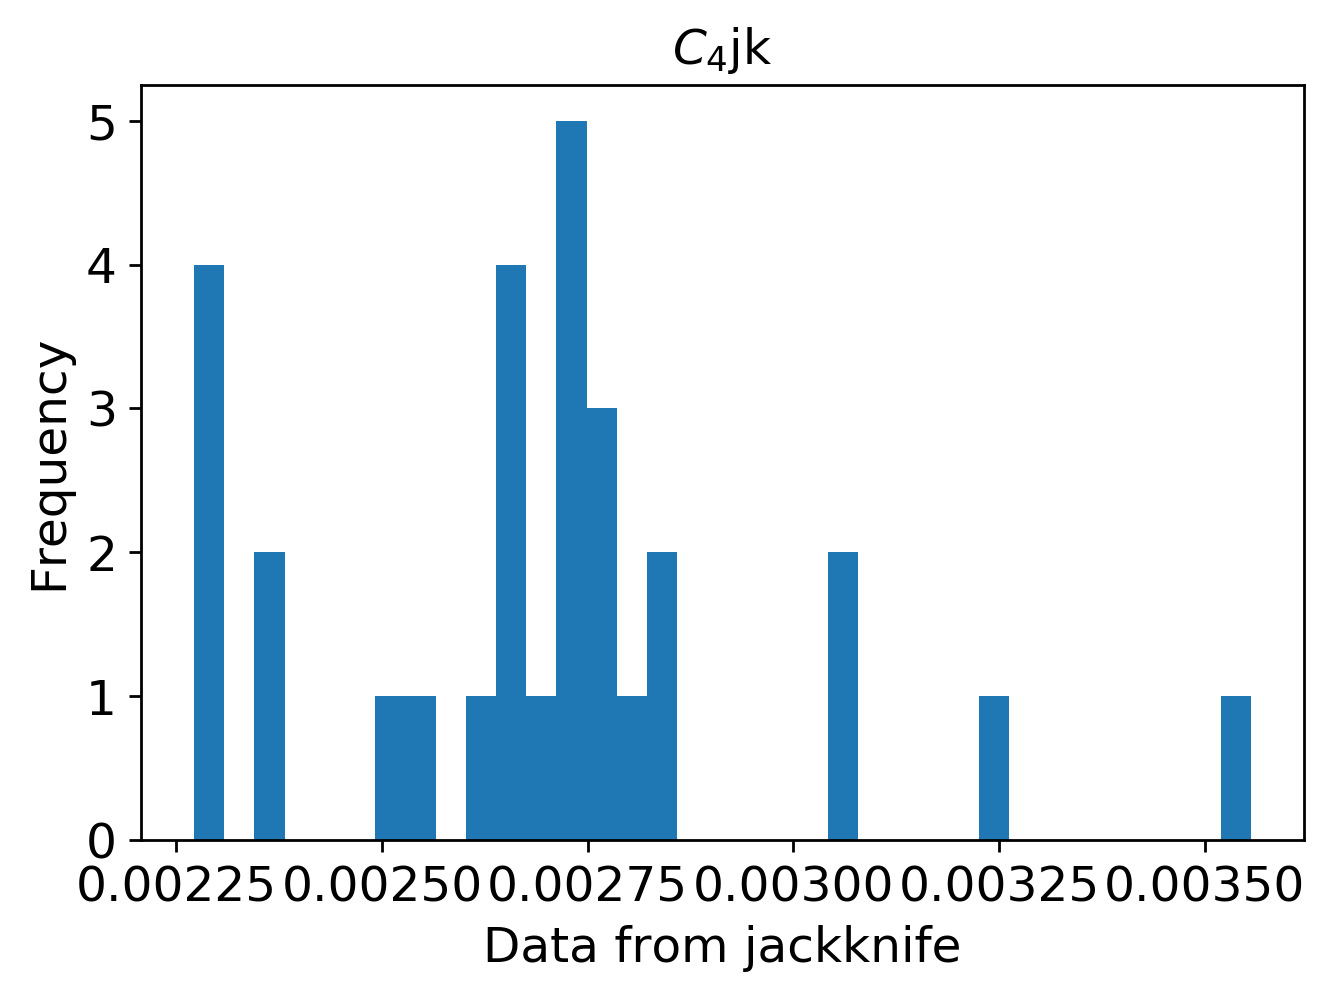

mean: 0.00010625331846118231
jk_e: 6.163923418956562e-06
CI 1.2081289901154862e-05


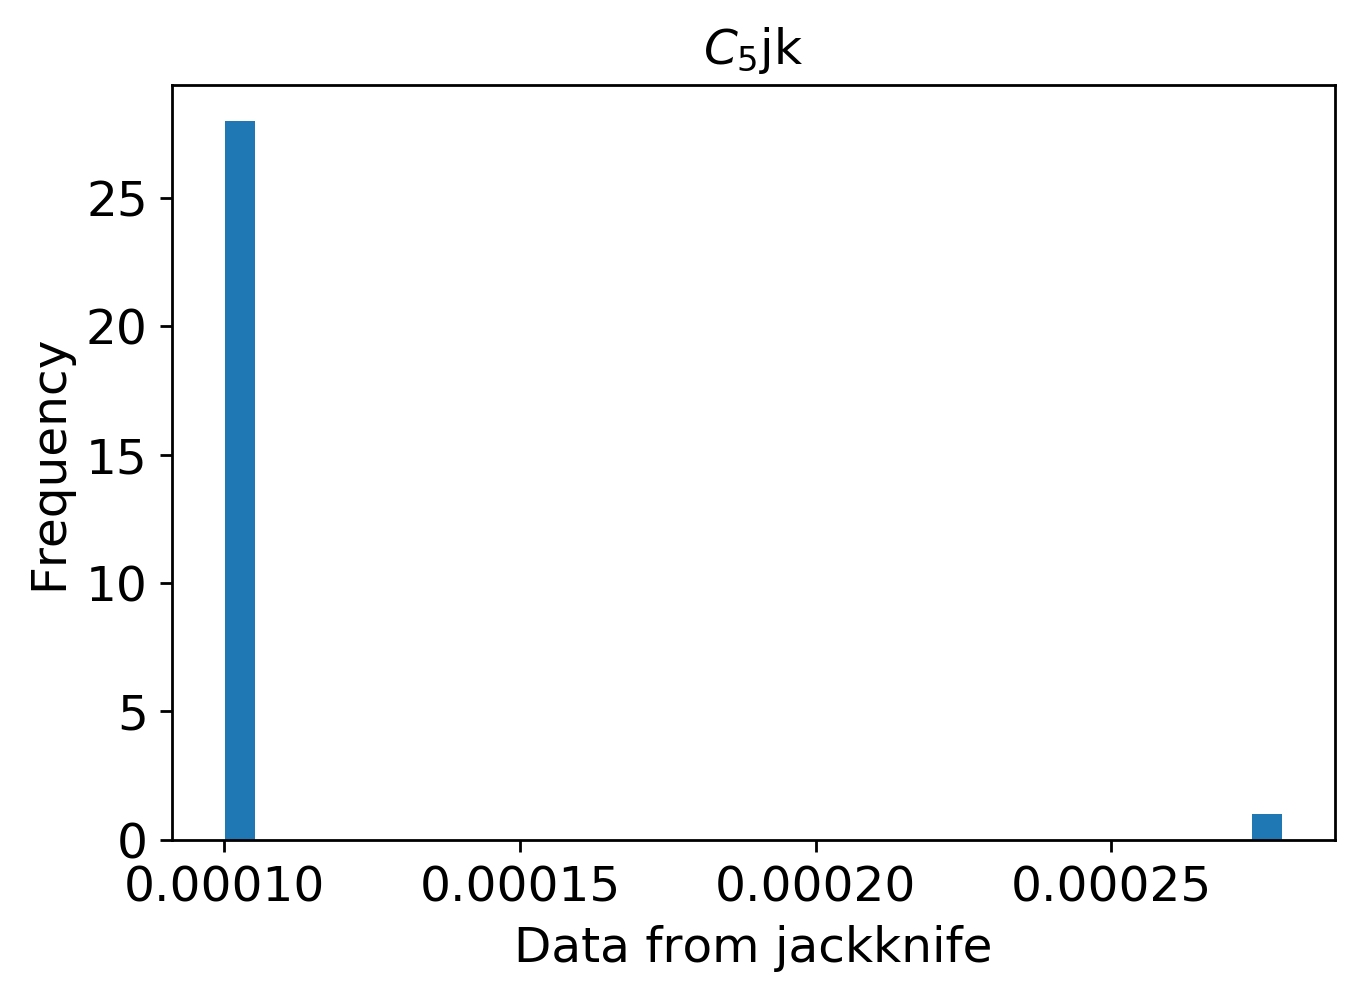

In [9]:
# Jackknife Method
import csv
import numpy as np
import pandas as pd
import math
from keras.models import load_model
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

datadir = '/home/rimali2009/Journal_2/data_g6_j2_roi1700_thai_revised_1/'
resdir = '/home/rimali2009/Journal_2/result_g6_j2_roi1700_thai_revised_1/5000/'
# Initial setting
if not "model" in locals():
    model = load_model(resdir+'model3.hdf5')
gclass = 5

topodx = 15.0
coord_num = int(model.layers[0].input_shape[1]/gclass)
min_x, max_x = np.loadtxt(datadir + 'x_minmax.txt', delimiter=',')
y_min = np.loadtxt(datadir + 'icond_min.txt', delimiter=',')
y_max = np.loadtxt(datadir + 'icond_max.txt', delimiter=',')


a = pd.read_csv(
    '../Journal_2/Thai_gs5_revised_1.csv', delimiter=',')
print(a)
y = pd.DataFrame()
output = []

with open('output_final_j2_roi1700_thai_revised_1.csv', 'w') as outfile:

    # x=[]
    for index in range(len(a)):
        df = y.append(pd.read_csv(
            '../Journal_2/Thai_gs5_revised_1.csv', skiprows=[index+1]))
        print(df)
        df = df.sort_values('distance')
        thick_interp = np.zeros([1, coord_num*gclass])
        x = np.arange(0, coord_num*topodx, topodx)
        for j in range(gclass):
            # Interpolation function of jth granularity level
            f = interp1d(df['distance'], df.iloc[:, j+1],
                         kind="cubic", bounds_error=False,fill_value='extrapolate')
            thick_interp[0, coord_num*j:coord_num*(j+1)] = f(x)
        thick_interp[thick_interp < 0] = 0
        thick_interp_norm = (thick_interp - min_x) / (max_x - min_x)
        test_result_outcrop = model.predict(thick_interp_norm)
        test_result_outcrop = test_result_outcrop * (y_max - y_min) + y_min
        print(test_result_outcrop.shape)
        print(test_result_outcrop)
    # output.append(test_result_outcrop)
        np.savetxt(outfile,test_result_outcrop, delimiter=',')
        # outfile.write('# New iteration\n')
hfont = {'fontname': 'Century Gothic'}
textcol = 'k'
resi = np.loadtxt('output_final_j2_roi1700_thai_revised_1.csv', delimiter=',')
titlelabel = ['Max. Inundation Lengthjk','Flow Velocityjk', 'Max Flow depthjk',
              '$C_1$jk', '$C_2$jk', '$C_3$jk', '$C_4$jk', '$C_5$jk']
jk_er=[]
with open('jk_e_1700_j2_thai_cubic_revised_1.txt','wb') as ftext:
    for i in range(len(titlelabel)):
        plt.figure(num=None, dpi=250, facecolor='w', edgecolor='k')
        plt.hist(resi[:, i], bins=35)
        mean = sum(resi[:,i]) / len(resi[:,i])
        print("mean:",mean)
        var_jk  = sum(pow(x-mean,2) for x in resi[:,i]) / ((len(resi[:,i])-1)*(len(resi[:,i])))
        jk_e= math.sqrt(var_jk)
        #ci_u=mean+(1.96*jk_e)
        #ci_l=mean-(1.96*jk_e)
        CI=(1.96*jk_e)
        print("jk_e:",jk_e)
        #print("CI_u", ci_u)
        #print("CI_l",ci_l)
        print("CI",CI)
        e=np.append(jk_e,jk_er)
        np.savetxt(ftext,e,delimiter=',')
        plt.title(titlelabel[i], color=textcol, size=14, **hfont)
        plt.xlabel('Data from jackknife', color=textcol, size=14, **hfont)
        plt.ylabel('Frequency', color=textcol, size=14, **hfont)
        plt.tick_params(labelsize=14, colors=textcol)
        plt.savefig(resdir+titlelabel[i] + 'jkhist' + '.eps')
        plt.savefig(resdir+titlelabel[i] + 'jkhist' + '.pdf')
        plt.show()
